<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [1]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random
import datetime

In [2]:
#torch.multiprocessing.set_start_method('spawn')
#torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 150
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 100
    
args = Parser()
#torch.manual_seed(args.seed)
#kwargs = {'num_workers': 1, 'pin_memory': False}

use_cuda = not args.no_cuda and torch.cuda.is_available()

#torch.set_default_tensor_type(torch.cuda.FloatTensor)

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if not use_cuda else {}
print(use_cuda)

False


<b>Download MNIST Data using torchvision datasets module</b>

In [4]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.previous_accuracy = 0
        self.previous_params = {}

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        
        
        params1 = self.state_dict()
        #print(self.previous_params, params1)
        params2 = neighbour_model_params #neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    #print("######", params2[name1].shape, params2[name1])
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(name1, params1[name1].shape, neighbour_ptr.shape)
                    
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
                    #x = params1[name1].copy()
                    #x.get()
                    #print("parameter value", x)
        
        #for key, value in params1.items():
        #    print(key, value.shape)
        
                    
        #self.load_state_dict(params1, strict=False)
        self.load_state_dict(params1)
                             
        
    def federated_avg_multi(self, neighbour_model_params, current_worker=None):
    
        if len(neighbour_model_params) == 1:
            self.federated_avg(neighbour_model_params[0], current_worker)
        else:
            params1 = self.state_dict()
            for params2 in neighbour_model_params: 
                #params2 = neighbour_model_params #neighbour_model_params.copy()
                with torch.no_grad():
                    for name1 in params1:
                        if name1 in params2:
                            neighbour_ptr = params2[name1].copy()
                            neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                            params1[name1] = params1[name1]  + neighbour_ptr
            
            #Averaging model weights
            scale = len(neighbour_model_params) + 1
            with torch.no_grad():
                for name in params1:
                    #print("#######param  ", name)
                    params1[name] = params1[name] / scale
                
            #Load back new params to model        
            #self.load_state_dict(params1, strict=False)
            self.load_state_dict(params1)
        
    def rollback_exchange(self):
        self.load_state_dict(self.previous_params, strict=False)
    

In [6]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [7]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,25,83
1,37,93
2,55,81
3,1,45
4,49,99
...,...,...
4945,22,62
4946,20,37
4947,13,46


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [8]:
def rotate_tuple_worker(worker_tuple):
    return worker_tuple[1:] + [worker_tuple[0]]

def generate_worker_split():
    target_worker_split = {}
    total_mnist_numbers = 10
    mnist_numbers = list(range(10))
    for i in range(args.num_of_workers):
        mnist_worker_number = random.sample(mnist_numbers, 3)
        
        for mnist_number in mnist_worker_number:
            if mnist_number in target_worker_split:
                target_worker_split[mnist_number].append(i)
            else:
                target_worker_split[mnist_number] = []
                target_worker_split[mnist_number].append(i)
    
    return target_worker_split
            
    
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    input_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_counter = {}
    ##target_worker_split = {0:0, 1:1, 2:(2,0), 3:1, 4:0, 5:1, 6:2, 7:1, 8:(2,0), 9:2 }  ##target values for 3 workers
    #target_worker_split = {0:0, 1:1, 2:0, 3:1, 4:(1,0), 5:(1,0), 6:(0,1), 7:1, 8:(0,1), 9:0 }    ##target values for 2 workers
    #target_worker_split = {0:0, 1:1, 2:2, 3:0, 4:2, 5:1, 6:2, 7:0, 8:1, 9:2 }
    target_worker_split = generate_worker_split()
    print(target_worker_split)
    for batch_idx, (data,target) in enumerate(train_loader):
        target_value = target.item()
        
        if isinstance(target_worker_split[target_value], list):
            current_worker_idx = target_worker_split[target_value][0]
            target_worker_split[target_value] = rotate_tuple_worker(target_worker_split[target_value])
        else:
            current_worker_idx = target_worker_split[target_value]
        
        #for current_worker_idx in target_worker_split[target_value]:
        if len(target_worker_dataset[current_worker_idx]) == args.batch_size:
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            #cuda#target_values = torch.cat(target_values).to(device)
            input_data = torch.cat(input_data)
            #cuda#input_data = torch.cat(input_data).to(device)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
                      
        target_worker_dataset[current_worker_idx].append((data, target))
            
    for current_worker_idx in range(args.num_of_workers):
        if len(target_worker_dataset[current_worker_idx]):
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            #cuda#target_values = torch.cat(target_values).to(device)
            input_data = torch.cat(input_data)
            #cuda#input_data = torch.cat(input_data).to(device)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
        
    models = [Net() for _ in range(args.num_of_workers)]
    #for model in models:
    #    model.to(device)
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [9]:
def update(data, target, model, optimizer):
    #print(data, target)
    #for key, value in model.state_dict().items():
    #    print(model, key, value, value.shape)
    #CUDA#data, target = data.to(device), target.to(device)
    #print(data, target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    
            
    return model, data, target

In [10]:
def check_accuracy(model, node):
    model.get()
    _, accuracy = test(model, node.id)
    return accuracy, model.send(node)

def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
    worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
    
    #Send worker2 params to worker1 for averaging at worker1
    #accuracy_before_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])
    
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    accuracy_after_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])

    #print("#########Node - {} accuracy before exchange - {} ; accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id1], accuracy_before_exchange, accuracy_after_exchange, worker1_model.previous_accuracy ))
    
    if accuracy_after_exchange < worker1_model.previous_accuracy:
        worker1_model.rollback_exchange()
    else:
        worker1_model.previous_accuracy = accuracy_after_exchange
        worker1_model.previous_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        
    
    #Send worker1 params to worker2 for averaging at worker2
    #accuracy_before_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
    #model_copy = worker2_model.copy()
    accuracy_after_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    #print("###########Node - {} accuracy before exchange - {} ;  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id2], accuracy_before_exchange, accuracy_after_exchange, worker2_model.previous_accuracy ))
    if accuracy_after_exchange < worker2_model.previous_accuracy:
        worker2_model.rollback_exchange()
    else:
        worker2_model.previous_accuracy = accuracy_after_exchange
        worker2_model.previous_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        
    return worker_id1, worker_id2

def exchange_parameters_all(models, data_index):
    exchange_combinations = list(itertools.combinations(range(len(models)), 2))
    random.shuffle(exchange_combinations)
    
    for worker_id1, worker_id2 in exchange_combinations:
        worker1_model = models[worker_id1]
        worker2_model = models[worker_id2]
        #print("####MODELS",worker_id1, worker1_model, worker_id2, worker2_model)
        #for key, value in worker1_model.state_dict().items():
        #    print(worker_id1, key, value, value.shape)
            
        #for key, value in worker2_model.state_dict().items():
        #    print(worker_id2, key, value, value.shape)
            
        worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
        worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
        
        

def exchange_parameters_multiple(models, data_index=None):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    #current_worker_idx = data_index % len(compute_nodes)
    #worker1_model = models[current_worker_idx]
    #worker1_params = worker1_model.state_dict().copy()
    worker_params = [model.state_dict().copy() for model in models]
    idx = 0
    
    for node in compute_nodes:
        other_worker_params = [param for i, param in enumerate(worker_params) if i != idx ]
        models[idx].federated_avg_multi(other_worker_params, compute_nodes[idx])
        idx += 1
    
        
    
    ##Copy the model to other workers
    #new_models = [] #[worker1_model.copy().move(node) for i, node in enumerate(compute_nodes) if i != current_worker_idx]
    #for i, node in enumerate(compute_nodes):
    #    if i == current_worker_idx:
    #        print("###CURRENT######", type(worker1_model), node, worker1_model)
    #        new_models.append(worker1_model)
    #    else:
    #        neighbour_model_ptr = worker1_model.copy()
    #        print("###other######", type(neighbour_model_ptr), node, worker1_model.location, neighbour_model_ptr)
    #        neighbour_model_ptr.move(node)
    #        new_models.append(neighbour_model_ptr)
    #        print("###After mive######", type(neighbour_model_ptr), node, neighbour_model_ptr)
    
    #return new_models
    
   

In [11]:
def train(models, compute_nodes, remote_dataset, optimizers, epoch_id, federated_average=False, decentralized=False):
    
    #for key, value in models[0].state_dict().items():
    #    print("BEFORE START - 0",models[0], key, value, value.shape)
    
    #for key, value in models[59].state_dict().items():
    #    print("before START - 59", models[59], key, value, value.size())
    
    #print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n", models[59].to(device), models[59].to(device).state_dict())
    
    if federated_average:
        #cuda#models = [models.copy().to(device) for _ in range(args.num_of_workers)]
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    
    #for key, value in models[59].state_dict().items():
    #    print("before START - 59", models[59], key, value, value.size())
        
    #models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    
    #print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    #for key, value in models[59].state_dict().items():
    #    print("AFTER SEND- 59", models[59], key, value, value.size())
    
    
    #print("#############################")
    
    for remote_index in range(len(compute_nodes)):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for data_index in range(len(remote_dataset[remote_index])):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index], data, target = update(data, target, models[remote_index], optimizers[remote_index])
            remote_dataset[remote_index][data_index] = (data, target)
        
    
       #Exchange of parameter between two remote models.
    if decentralized:
        worker_id1, worker_id2 = exchange_parameters(models, epoch_id)
        #exchange_parameters_all(models, epoch_id)
        for i in range(len(models)):
            if i not in (worker_id1, worker_id2):
                print(i, worker_id1, worker_id2)
                accuracy, models[i] = check_accuracy(models[i], compute_nodes[i])
                if accuracy < models[i].previous_accuracy:
                    models[i].rollback_exchange()
                
        #exchange_parameters_multiple(models, epoch_id)
        
        
    for i, model in enumerate(models):
        model.get()
        #if federated_average:
        #    _, current_accuracy = test(model, compute_nodes[i])
        #    print("###########Federated Average Node - {}  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[i], current_accuracy, model.previous_accuracy ))
        #    model.previous_accuracy = current_accuracy
        
        
    
    #if exchange:
    #    return models
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [12]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #cuda#data, target = data.to(device), target.to(device)
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    #print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [13]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if decentralized:
            #models = train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        elif federated_average:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format("federated_avg_local", avg_loss, avg_accuracy))
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
        else:
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [14]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-27 15:24:03.736529
{8: [0, 1, 7, 8, 10, 11, 12, 15, 19, 20, 21, 25, 26, 31, 37, 39, 43, 44, 47, 51, 54, 59, 60, 64, 65, 66, 67, 68, 73, 75, 76, 82, 83, 84, 85, 88, 93, 94, 95, 97, 99], 7: [0, 9, 13, 14, 16, 18, 20, 22, 24, 25, 27, 36, 40, 44, 49, 50, 58, 59, 69, 70, 72, 77, 83, 89, 90, 94, 98], 9: [0, 2, 3, 4, 5, 6, 9, 10, 17, 18, 27, 29, 33, 35, 39, 41, 42, 43, 44, 45, 52, 61, 62, 63, 72, 75, 80, 81, 82, 86, 87], 3: [1, 3, 4, 10, 11, 14, 24, 29, 30, 35, 36, 37, 38, 42, 45, 48, 49, 54, 55, 56, 57, 68, 70, 71, 72, 75, 76, 78, 79, 81, 85, 87, 91, 92, 95, 96, 97, 98], 5: [1, 2, 5, 7, 8, 20, 32, 38, 40, 51, 56, 62, 64, 67, 70, 78, 80, 84, 88, 93, 98, 99], 1: [2, 11, 12, 13, 16, 17, 23, 32, 35, 45, 46, 48, 53, 56, 60, 63, 65, 68, 71, 73, 74, 77, 79, 82, 87, 91, 94, 96], 2: [3, 6, 7, 8, 21, 23, 24, 26, 28, 31, 33, 34, 40, 41, 47, 48, 52, 58, 59, 60, 65, 67, 73, 79, 80, 84, 88, 89, 92, 93], 6: [4, 12, 15, 16, 17, 19, 22, 25, 28, 30, 31, 33, 36, 46, 50, 53, 55, 57, 58, 63, 6

Test set for worker worker-87: Average loss: 2.6903 & Average Accuracy : 0.2105
Test set for worker worker-88: Average loss: 2.6944 & Average Accuracy : 0.0993
Test set for worker worker-89: Average loss: 2.5416 & Average Accuracy : 0.1934
Test set for worker worker-90: Average loss: 2.6192 & Average Accuracy : 0.2302
Test set for worker worker-91: Average loss: 2.4954 & Average Accuracy : 0.1120
Test set for worker worker-92: Average loss: 2.4414 & Average Accuracy : 0.0983
Test set for worker worker-93: Average loss: 2.4781 & Average Accuracy : 0.0892
Test set for worker worker-94: Average loss: 2.7130 & Average Accuracy : 0.1295
Test set for worker worker-95: Average loss: 2.6465 & Average Accuracy : 0.1796
Test set for worker worker-96: Average loss: 2.4056 & Average Accuracy : 0.2098
Test set for worker worker-97: Average loss: 2.3792 & Average Accuracy : 0.1194
Test set for worker worker-98: Average loss: 2.7915 & Average Accuracy : 0.1856
Test set for worker worker-99: Average l

Test set for worker worker-89: Average loss: 3.6613 & Average Accuracy : 0.2809
Test set for worker worker-90: Average loss: 3.7952 & Average Accuracy : 0.2782
Test set for worker worker-91: Average loss: 3.5746 & Average Accuracy : 0.2398
Test set for worker worker-92: Average loss: 3.3702 & Average Accuracy : 0.1968
Test set for worker worker-93: Average loss: 3.4230 & Average Accuracy : 0.1091
Test set for worker worker-94: Average loss: 3.8334 & Average Accuracy : 0.2554
Test set for worker worker-95: Average loss: 3.5403 & Average Accuracy : 0.1995
Test set for worker worker-96: Average loss: 3.2640 & Average Accuracy : 0.2106
Test set for worker worker-97: Average loss: 3.0040 & Average Accuracy : 0.1428
Test set for worker worker-98: Average loss: 3.8885 & Average Accuracy : 0.1919
Test set for worker worker-99: Average loss: 3.7835 & Average Accuracy : 0.1854
Communication time over the network 184.84 s

Epoch Number 3
Test set for worker worker-0: Average loss: 4.3339 & Averag

Test set for worker worker-91: Average loss: 4.5336 & Average Accuracy : 0.2972
Test set for worker worker-92: Average loss: 4.0694 & Average Accuracy : 0.1965
Test set for worker worker-93: Average loss: 4.1962 & Average Accuracy : 0.1474
Test set for worker worker-94: Average loss: 4.7116 & Average Accuracy : 0.2883
Test set for worker worker-95: Average loss: 4.1528 & Average Accuracy : 0.2423
Test set for worker worker-96: Average loss: 4.1463 & Average Accuracy : 0.2487
Test set for worker worker-97: Average loss: 3.7008 & Average Accuracy : 0.2297
Test set for worker worker-98: Average loss: 4.6215 & Average Accuracy : 0.2295
Test set for worker worker-99: Average loss: 4.4966 & Average Accuracy : 0.2104
Communication time over the network 185.93 s

Epoch Number 4
Test set for worker worker-0: Average loss: 4.9093 & Average Accuracy : 0.2723
Test set for worker worker-1: Average loss: 4.7970 & Average Accuracy : 0.2144
Test set for worker worker-2: Average loss: 6.0149 & Average 

Test set for worker worker-93: Average loss: 4.7868 & Average Accuracy : 0.1663
Test set for worker worker-94: Average loss: 5.4410 & Average Accuracy : 0.2930
Test set for worker worker-95: Average loss: 4.6199 & Average Accuracy : 0.2638
Test set for worker worker-96: Average loss: 4.8375 & Average Accuracy : 0.2899
Test set for worker worker-97: Average loss: 4.2211 & Average Accuracy : 0.2521
Test set for worker worker-98: Average loss: 5.1936 & Average Accuracy : 0.2576
Test set for worker worker-99: Average loss: 5.0368 & Average Accuracy : 0.2221
Communication time over the network 198.93 s

Epoch Number 5
Test set for worker worker-0: Average loss: 5.3989 & Average Accuracy : 0.2567
Test set for worker worker-1: Average loss: 5.2342 & Average Accuracy : 0.2188
Test set for worker worker-2: Average loss: 6.7869 & Average Accuracy : 0.2920
Test set for worker worker-3: Average loss: 5.4651 & Average Accuracy : 0.2528
Test set for worker worker-4: Average loss: 5.0654 & Average Ac

Test set for worker worker-95: Average loss: 5.0050 & Average Accuracy : 0.2708
Test set for worker worker-96: Average loss: 5.4167 & Average Accuracy : 0.3016
Test set for worker worker-97: Average loss: 4.6651 & Average Accuracy : 0.2595
Test set for worker worker-98: Average loss: 5.7105 & Average Accuracy : 0.2668
Test set for worker worker-99: Average loss: 5.4388 & Average Accuracy : 0.2377
Communication time over the network 200.28 s

Epoch Number 6
Test set for worker worker-0: Average loss: 5.9988 & Average Accuracy : 0.2300
Test set for worker worker-1: Average loss: 5.5539 & Average Accuracy : 0.1962
Test set for worker worker-2: Average loss: 7.3856 & Average Accuracy : 0.2935
Test set for worker worker-3: Average loss: 5.8032 & Average Accuracy : 0.2638
Test set for worker worker-4: Average loss: 5.5695 & Average Accuracy : 0.2837
Test set for worker worker-5: Average loss: 6.4519 & Average Accuracy : 0.2487
Test set for worker worker-6: Average loss: 5.6682 & Average Accu

Test set for worker worker-97: Average loss: 5.0804 & Average Accuracy : 0.2621
Test set for worker worker-98: Average loss: 6.1992 & Average Accuracy : 0.2669
Test set for worker worker-99: Average loss: 5.6800 & Average Accuracy : 0.2513
Communication time over the network 190.94 s

Epoch Number 7
Test set for worker worker-0: Average loss: 5.4878 & Average Accuracy : 0.2756
Test set for worker worker-1: Average loss: 5.2570 & Average Accuracy : 0.1698
Test set for worker worker-2: Average loss: 7.8865 & Average Accuracy : 0.2944
Test set for worker worker-3: Average loss: 6.0887 & Average Accuracy : 0.2619
Test set for worker worker-4: Average loss: 6.0183 & Average Accuracy : 0.2835
Test set for worker worker-5: Average loss: 6.7607 & Average Accuracy : 0.2501
Test set for worker worker-6: Average loss: 5.8733 & Average Accuracy : 0.2370
Test set for worker worker-7: Average loss: 5.7911 & Average Accuracy : 0.2153
Test set for worker worker-8: Average loss: 6.1191 & Average Accura

Test set for worker worker-99: Average loss: 5.6193 & Average Accuracy : 0.2542
Communication time over the network 188.08 s

Epoch Number 8
Test set for worker worker-0: Average loss: 5.9887 & Average Accuracy : 0.2751
Test set for worker worker-1: Average loss: 5.3832 & Average Accuracy : 0.2463
Test set for worker worker-2: Average loss: 8.3056 & Average Accuracy : 0.2954
Test set for worker worker-3: Average loss: 6.2617 & Average Accuracy : 0.2604
Test set for worker worker-4: Average loss: 6.3918 & Average Accuracy : 0.2840
Test set for worker worker-5: Average loss: 6.8426 & Average Accuracy : 0.2406
Test set for worker worker-6: Average loss: 5.7648 & Average Accuracy : 0.2797
Test set for worker worker-7: Average loss: 5.9622 & Average Accuracy : 0.2364
Test set for worker worker-8: Average loss: 6.2146 & Average Accuracy : 0.2584
Test set for worker worker-9: Average loss: 5.8015 & Average Accuracy : 0.2537
Test set for worker worker-10: Average loss: 5.7161 & Average Accurac

Test set for worker worker-1: Average loss: 5.8869 & Average Accuracy : 0.1836
Test set for worker worker-2: Average loss: 8.6645 & Average Accuracy : 0.2962
Test set for worker worker-3: Average loss: 6.2821 & Average Accuracy : 0.2750
Test set for worker worker-4: Average loss: 6.6951 & Average Accuracy : 0.2848
Test set for worker worker-5: Average loss: 6.9513 & Average Accuracy : 0.2645
Test set for worker worker-6: Average loss: 5.9296 & Average Accuracy : 0.2805
Test set for worker worker-7: Average loss: 6.1548 & Average Accuracy : 0.2477
Test set for worker worker-8: Average loss: 6.2609 & Average Accuracy : 0.2653
Test set for worker worker-9: Average loss: 6.0027 & Average Accuracy : 0.2647
Test set for worker worker-10: Average loss: 5.8302 & Average Accuracy : 0.2649
Test set for worker worker-11: Average loss: 7.3462 & Average Accuracy : 0.2871
Test set for worker worker-12: Average loss: 7.0561 & Average Accuracy : 0.2784
Test set for worker worker-13: Average loss: 7.88

Test set for worker worker-3: Average loss: 6.3068 & Average Accuracy : 0.2837
Test set for worker worker-4: Average loss: 6.9464 & Average Accuracy : 0.2866
Test set for worker worker-5: Average loss: 7.2694 & Average Accuracy : 0.2723
Test set for worker worker-6: Average loss: 6.0371 & Average Accuracy : 0.2830
Test set for worker worker-7: Average loss: 6.3498 & Average Accuracy : 0.2562
Test set for worker worker-8: Average loss: 6.3847 & Average Accuracy : 0.2676
Test set for worker worker-9: Average loss: 6.2153 & Average Accuracy : 0.2668
Test set for worker worker-10: Average loss: 5.9815 & Average Accuracy : 0.2679
Test set for worker worker-11: Average loss: 7.2954 & Average Accuracy : 0.2931
Test set for worker worker-12: Average loss: 7.2687 & Average Accuracy : 0.2800
Test set for worker worker-13: Average loss: 8.0907 & Average Accuracy : 0.3091
Test set for worker worker-14: Average loss: 7.2146 & Average Accuracy : 0.2950
Test set for worker worker-15: Average loss: 6.

Test set for worker worker-5: Average loss: 7.4899 & Average Accuracy : 0.2723
Test set for worker worker-6: Average loss: 6.1680 & Average Accuracy : 0.2844
Test set for worker worker-7: Average loss: 6.5390 & Average Accuracy : 0.2604
Test set for worker worker-8: Average loss: 6.5128 & Average Accuracy : 0.2686
Test set for worker worker-9: Average loss: 6.3832 & Average Accuracy : 0.2713
Test set for worker worker-10: Average loss: 6.1669 & Average Accuracy : 0.2719
Test set for worker worker-11: Average loss: 7.5139 & Average Accuracy : 0.2919
Test set for worker worker-12: Average loss: 7.4519 & Average Accuracy : 0.2806
Test set for worker worker-13: Average loss: 8.2727 & Average Accuracy : 0.3095
Test set for worker worker-14: Average loss: 7.4134 & Average Accuracy : 0.2950
Test set for worker worker-15: Average loss: 7.0027 & Average Accuracy : 0.2788
Test set for worker worker-16: Average loss: 8.2228 & Average Accuracy : 0.3042
Test set for worker worker-17: Average loss: 

Test set for worker worker-7: Average loss: 6.7131 & Average Accuracy : 0.2635
Test set for worker worker-8: Average loss: 6.6289 & Average Accuracy : 0.2694
Test set for worker worker-9: Average loss: 6.5520 & Average Accuracy : 0.2791
Test set for worker worker-10: Average loss: 6.3449 & Average Accuracy : 0.2749
Test set for worker worker-11: Average loss: 7.6114 & Average Accuracy : 0.2930
Test set for worker worker-12: Average loss: 7.6103 & Average Accuracy : 0.2817
Test set for worker worker-13: Average loss: 8.4338 & Average Accuracy : 0.3096
Test set for worker worker-14: Average loss: 7.5902 & Average Accuracy : 0.2951
Test set for worker worker-15: Average loss: 7.2019 & Average Accuracy : 0.2799
Test set for worker worker-16: Average loss: 8.3714 & Average Accuracy : 0.3042
Test set for worker worker-17: Average loss: 8.9006 & Average Accuracy : 0.3048
Test set for worker worker-18: Average loss: 6.7722 & Average Accuracy : 0.2666
Test set for worker worker-19: Average loss

Test set for worker worker-9: Average loss: 6.6495 & Average Accuracy : 0.2699
Test set for worker worker-10: Average loss: 6.5107 & Average Accuracy : 0.2773
Test set for worker worker-11: Average loss: 7.7016 & Average Accuracy : 0.2940
Test set for worker worker-12: Average loss: 7.7493 & Average Accuracy : 0.2824
Test set for worker worker-13: Average loss: 8.5789 & Average Accuracy : 0.3097
Test set for worker worker-14: Average loss: 7.7486 & Average Accuracy : 0.2949
Test set for worker worker-15: Average loss: 7.3849 & Average Accuracy : 0.2811
Test set for worker worker-16: Average loss: 8.5056 & Average Accuracy : 0.3044
Test set for worker worker-17: Average loss: 9.0701 & Average Accuracy : 0.3050
Test set for worker worker-18: Average loss: 6.9645 & Average Accuracy : 0.2711
Test set for worker worker-19: Average loss: 7.2327 & Average Accuracy : 0.2776
Test set for worker worker-20: Average loss: 8.0713 & Average Accuracy : 0.2674
Test set for worker worker-21: Average lo

Test set for worker worker-11: Average loss: 7.7847 & Average Accuracy : 0.2946
Test set for worker worker-12: Average loss: 7.8721 & Average Accuracy : 0.2831
Test set for worker worker-13: Average loss: 8.7089 & Average Accuracy : 0.3098
Test set for worker worker-14: Average loss: 7.8935 & Average Accuracy : 0.2951
Test set for worker worker-15: Average loss: 7.5531 & Average Accuracy : 0.2815
Test set for worker worker-16: Average loss: 8.6298 & Average Accuracy : 0.3044
Test set for worker worker-17: Average loss: 9.2191 & Average Accuracy : 0.3050
Test set for worker worker-18: Average loss: 7.1438 & Average Accuracy : 0.2728
Test set for worker worker-19: Average loss: 7.3807 & Average Accuracy : 0.2780
Test set for worker worker-20: Average loss: 8.2270 & Average Accuracy : 0.2692
Test set for worker worker-21: Average loss: 7.3069 & Average Accuracy : 0.2849
Test set for worker worker-22: Average loss: 8.0260 & Average Accuracy : 0.2880
Test set for worker worker-23: Average l

Test set for worker worker-13: Average loss: 8.8274 & Average Accuracy : 0.3097
Test set for worker worker-14: Average loss: 8.0264 & Average Accuracy : 0.2951
Test set for worker worker-15: Average loss: 7.7096 & Average Accuracy : 0.2817
Test set for worker worker-16: Average loss: 8.7445 & Average Accuracy : 0.3048
Test set for worker worker-17: Average loss: 9.3516 & Average Accuracy : 0.3053
Test set for worker worker-18: Average loss: 7.3032 & Average Accuracy : 0.2731
Test set for worker worker-19: Average loss: 7.5124 & Average Accuracy : 0.2784
Test set for worker worker-20: Average loss: 8.3702 & Average Accuracy : 0.2702
Test set for worker worker-21: Average loss: 7.3768 & Average Accuracy : 0.2848
Test set for worker worker-22: Average loss: 8.1494 & Average Accuracy : 0.2880
Test set for worker worker-23: Average loss: 8.5655 & Average Accuracy : 0.3078
Test set for worker worker-24: Average loss: 8.0382 & Average Accuracy : 0.2894
Test set for worker worker-25: Average l

Test set for worker worker-15: Average loss: 7.8554 & Average Accuracy : 0.2824
Test set for worker worker-16: Average loss: 8.8529 & Average Accuracy : 0.3049
Test set for worker worker-17: Average loss: 9.4695 & Average Accuracy : 0.3058
Test set for worker worker-18: Average loss: 7.4423 & Average Accuracy : 0.2734
Test set for worker worker-19: Average loss: 7.6290 & Average Accuracy : 0.2792
Test set for worker worker-20: Average loss: 8.5035 & Average Accuracy : 0.2712
Test set for worker worker-21: Average loss: 7.4422 & Average Accuracy : 0.2847
Test set for worker worker-22: Average loss: 8.2611 & Average Accuracy : 0.2882
Test set for worker worker-23: Average loss: 8.6703 & Average Accuracy : 0.3083
Test set for worker worker-24: Average loss: 8.1626 & Average Accuracy : 0.2906
Test set for worker worker-25: Average loss: 7.7791 & Average Accuracy : 0.2832
Test set for worker worker-26: Average loss: 7.0155 & Average Accuracy : 0.2889
Test set for worker worker-27: Average l

Test set for worker worker-17: Average loss: 9.5770 & Average Accuracy : 0.3060
Test set for worker worker-18: Average loss: 7.5586 & Average Accuracy : 0.2736
Test set for worker worker-19: Average loss: 7.7316 & Average Accuracy : 0.2798
Test set for worker worker-20: Average loss: 8.6266 & Average Accuracy : 0.2721
Test set for worker worker-21: Average loss: 7.5017 & Average Accuracy : 0.2848
Test set for worker worker-22: Average loss: 8.3641 & Average Accuracy : 0.2886
Test set for worker worker-23: Average loss: 8.7675 & Average Accuracy : 0.3084
Test set for worker worker-24: Average loss: 8.2782 & Average Accuracy : 0.2910
Test set for worker worker-25: Average loss: 7.8714 & Average Accuracy : 0.2843
Test set for worker worker-26: Average loss: 7.0938 & Average Accuracy : 0.2890
Test set for worker worker-27: Average loss: 6.8448 & Average Accuracy : 0.2879
Test set for worker worker-28: Average loss: 7.3099 & Average Accuracy : 0.2861
Test set for worker worker-29: Average l

Test set for worker worker-19: Average loss: 7.8225 & Average Accuracy : 0.2805
Test set for worker worker-20: Average loss: 8.7391 & Average Accuracy : 0.2725
Test set for worker worker-21: Average loss: 7.5569 & Average Accuracy : 0.2853
Test set for worker worker-22: Average loss: 8.4582 & Average Accuracy : 0.2888
Test set for worker worker-23: Average loss: 8.8572 & Average Accuracy : 0.3086
Test set for worker worker-24: Average loss: 8.3853 & Average Accuracy : 0.2916
Test set for worker worker-25: Average loss: 7.9564 & Average Accuracy : 0.2855
Test set for worker worker-26: Average loss: 7.1669 & Average Accuracy : 0.2891
Test set for worker worker-27: Average loss: 6.8978 & Average Accuracy : 0.2880
Test set for worker worker-28: Average loss: 7.3787 & Average Accuracy : 0.2866
Test set for worker worker-29: Average loss: 8.1395 & Average Accuracy : 0.2921
Test set for worker worker-30: Average loss: 7.9099 & Average Accuracy : 0.2897
Test set for worker worker-31: Average l

Test set for worker worker-21: Average loss: 7.6083 & Average Accuracy : 0.2854
Test set for worker worker-22: Average loss: 8.5465 & Average Accuracy : 0.2888
Test set for worker worker-23: Average loss: 8.9401 & Average Accuracy : 0.3086
Test set for worker worker-24: Average loss: 8.4857 & Average Accuracy : 0.2915
Test set for worker worker-25: Average loss: 8.0360 & Average Accuracy : 0.2857
Test set for worker worker-26: Average loss: 7.2343 & Average Accuracy : 0.2892
Test set for worker worker-27: Average loss: 6.9485 & Average Accuracy : 0.2885
Test set for worker worker-28: Average loss: 7.4413 & Average Accuracy : 0.2871
Test set for worker worker-29: Average loss: 8.2185 & Average Accuracy : 0.2923
Test set for worker worker-30: Average loss: 7.9864 & Average Accuracy : 0.2899
Test set for worker worker-31: Average loss: 7.1956 & Average Accuracy : 0.2871
Test set for worker worker-32: Average loss: 9.0160 & Average Accuracy : 0.2950
Test set for worker worker-33: Average l

Test set for worker worker-23: Average loss: 9.0176 & Average Accuracy : 0.3087
Test set for worker worker-24: Average loss: 8.5788 & Average Accuracy : 0.2916
Test set for worker worker-25: Average loss: 8.1112 & Average Accuracy : 0.2858
Test set for worker worker-26: Average loss: 7.2971 & Average Accuracy : 0.2892
Test set for worker worker-27: Average loss: 6.9968 & Average Accuracy : 0.2889
Test set for worker worker-28: Average loss: 7.4979 & Average Accuracy : 0.2875
Test set for worker worker-29: Average loss: 8.2924 & Average Accuracy : 0.2923
Test set for worker worker-30: Average loss: 8.0577 & Average Accuracy : 0.2900
Test set for worker worker-31: Average loss: 7.2762 & Average Accuracy : 0.2873
Test set for worker worker-32: Average loss: 9.0842 & Average Accuracy : 0.2951
Test set for worker worker-33: Average loss: 7.6235 & Average Accuracy : 0.2931
Test set for worker worker-34: Average loss: 8.2475 & Average Accuracy : 0.2936
Test set for worker worker-35: Average l

Test set for worker worker-25: Average loss: 8.1820 & Average Accuracy : 0.2861
Test set for worker worker-26: Average loss: 7.3558 & Average Accuracy : 0.2892
Test set for worker worker-27: Average loss: 7.0438 & Average Accuracy : 0.2892
Test set for worker worker-28: Average loss: 7.5488 & Average Accuracy : 0.2878
Test set for worker worker-29: Average loss: 8.3607 & Average Accuracy : 0.2924
Test set for worker worker-30: Average loss: 8.1239 & Average Accuracy : 0.2901
Test set for worker worker-31: Average loss: 7.3505 & Average Accuracy : 0.2875
Test set for worker worker-32: Average loss: 9.1474 & Average Accuracy : 0.2951
Test set for worker worker-33: Average loss: 7.7024 & Average Accuracy : 0.2930
Test set for worker worker-34: Average loss: 8.3201 & Average Accuracy : 0.2936
Test set for worker worker-35: Average loss: 9.6907 & Average Accuracy : 0.3064
Test set for worker worker-36: Average loss: 8.4911 & Average Accuracy : 0.2915
Test set for worker worker-37: Average l

Test set for worker worker-27: Average loss: 7.0894 & Average Accuracy : 0.2893
Test set for worker worker-28: Average loss: 7.5949 & Average Accuracy : 0.2879
Test set for worker worker-29: Average loss: 8.4224 & Average Accuracy : 0.2924
Test set for worker worker-30: Average loss: 8.1862 & Average Accuracy : 0.2901
Test set for worker worker-31: Average loss: 7.4201 & Average Accuracy : 0.2877
Test set for worker worker-32: Average loss: 9.2069 & Average Accuracy : 0.2950
Test set for worker worker-33: Average loss: 7.7795 & Average Accuracy : 0.2930
Test set for worker worker-34: Average loss: 8.3880 & Average Accuracy : 0.2937
Test set for worker worker-35: Average loss: 9.7722 & Average Accuracy : 0.3065
Test set for worker worker-36: Average loss: 8.5718 & Average Accuracy : 0.2918
Test set for worker worker-37: Average loss: 6.9310 & Average Accuracy : 0.2792
Test set for worker worker-38: Average loss: 7.7399 & Average Accuracy : 0.2780
Test set for worker worker-39: Average l

Test set for worker worker-29: Average loss: 8.4796 & Average Accuracy : 0.2924
Test set for worker worker-30: Average loss: 8.2442 & Average Accuracy : 0.2902
Test set for worker worker-31: Average loss: 7.4848 & Average Accuracy : 0.2877
Test set for worker worker-32: Average loss: 9.2618 & Average Accuracy : 0.2950
Test set for worker worker-33: Average loss: 7.8526 & Average Accuracy : 0.2932
Test set for worker worker-34: Average loss: 8.4525 & Average Accuracy : 0.2938
Test set for worker worker-35: Average loss: 9.8487 & Average Accuracy : 0.3066
Test set for worker worker-36: Average loss: 8.6483 & Average Accuracy : 0.2918
Test set for worker worker-37: Average loss: 6.9428 & Average Accuracy : 0.2804
Test set for worker worker-38: Average loss: 7.8166 & Average Accuracy : 0.2779
Test set for worker worker-39: Average loss: 7.4574 & Average Accuracy : 0.2797
Test set for worker worker-40: Average loss: 9.5911 & Average Accuracy : 0.2828
Test set for worker worker-41: Average l

Test set for worker worker-31: Average loss: 7.5450 & Average Accuracy : 0.2877
Test set for worker worker-32: Average loss: 9.3138 & Average Accuracy : 0.2951
Test set for worker worker-33: Average loss: 7.9250 & Average Accuracy : 0.2936
Test set for worker worker-34: Average loss: 8.5132 & Average Accuracy : 0.2939
Test set for worker worker-35: Average loss: 9.9214 & Average Accuracy : 0.3066
Test set for worker worker-36: Average loss: 8.7218 & Average Accuracy : 0.2920
Test set for worker worker-37: Average loss: 6.9538 & Average Accuracy : 0.2813
Test set for worker worker-38: Average loss: 7.8894 & Average Accuracy : 0.2780
Test set for worker worker-39: Average loss: 7.5324 & Average Accuracy : 0.2797
Test set for worker worker-40: Average loss: 9.6476 & Average Accuracy : 0.2833
Test set for worker worker-41: Average loss: 6.6899 & Average Accuracy : 0.2893
Test set for worker worker-42: Average loss: 7.6433 & Average Accuracy : 0.2852
Test set for worker worker-43: Average l

Test set for worker worker-33: Average loss: 7.9939 & Average Accuracy : 0.2936
Test set for worker worker-34: Average loss: 8.5713 & Average Accuracy : 0.2939
Test set for worker worker-35: Average loss: 9.9890 & Average Accuracy : 0.3068
Test set for worker worker-36: Average loss: 8.7926 & Average Accuracy : 0.2921
Test set for worker worker-37: Average loss: 6.9683 & Average Accuracy : 0.2821
Test set for worker worker-38: Average loss: 7.9619 & Average Accuracy : 0.2781
Test set for worker worker-39: Average loss: 7.6036 & Average Accuracy : 0.2798
Test set for worker worker-40: Average loss: 9.7003 & Average Accuracy : 0.2834
Test set for worker worker-41: Average loss: 6.7276 & Average Accuracy : 0.2894
Test set for worker worker-42: Average loss: 7.7037 & Average Accuracy : 0.2853
Test set for worker worker-43: Average loss: 7.4443 & Average Accuracy : 0.2865
Test set for worker worker-44: Average loss: 8.3739 & Average Accuracy : 0.2814
Test set for worker worker-45: Average l

Test set for worker worker-35: Average loss: 10.0532 & Average Accuracy : 0.3068
Test set for worker worker-36: Average loss: 8.8612 & Average Accuracy : 0.2924
Test set for worker worker-37: Average loss: 6.9816 & Average Accuracy : 0.2833
Test set for worker worker-38: Average loss: 8.0293 & Average Accuracy : 0.2780
Test set for worker worker-39: Average loss: 7.6696 & Average Accuracy : 0.2806
Test set for worker worker-40: Average loss: 9.7506 & Average Accuracy : 0.2837
Test set for worker worker-41: Average loss: 6.7626 & Average Accuracy : 0.2893
Test set for worker worker-42: Average loss: 7.7614 & Average Accuracy : 0.2855
Test set for worker worker-43: Average loss: 7.5015 & Average Accuracy : 0.2866
Test set for worker worker-44: Average loss: 8.4180 & Average Accuracy : 0.2815
Test set for worker worker-45: Average loss: 9.7753 & Average Accuracy : 0.3069
Test set for worker worker-46: Average loss: 9.9231 & Average Accuracy : 0.3034
Test set for worker worker-47: Average 

Test set for worker worker-37: Average loss: 6.9977 & Average Accuracy : 0.2838
Test set for worker worker-38: Average loss: 8.0966 & Average Accuracy : 0.2783
Test set for worker worker-39: Average loss: 7.7324 & Average Accuracy : 0.2809
Test set for worker worker-40: Average loss: 9.7963 & Average Accuracy : 0.2840
Test set for worker worker-41: Average loss: 6.7953 & Average Accuracy : 0.2898
Test set for worker worker-42: Average loss: 7.8186 & Average Accuracy : 0.2855
Test set for worker worker-43: Average loss: 7.5563 & Average Accuracy : 0.2867
Test set for worker worker-44: Average loss: 8.4577 & Average Accuracy : 0.2817
Test set for worker worker-45: Average loss: 9.8192 & Average Accuracy : 0.3072
Test set for worker worker-46: Average loss: 9.9905 & Average Accuracy : 0.3035
Test set for worker worker-47: Average loss: 8.2704 & Average Accuracy : 0.2874
Test set for worker worker-48: Average loss: 9.5690 & Average Accuracy : 0.3108
Test set for worker worker-49: Average l

Test set for worker worker-39: Average loss: 7.7910 & Average Accuracy : 0.2819
Test set for worker worker-40: Average loss: 9.8417 & Average Accuracy : 0.2842
Test set for worker worker-41: Average loss: 6.8270 & Average Accuracy : 0.2899
Test set for worker worker-42: Average loss: 7.8735 & Average Accuracy : 0.2855
Test set for worker worker-43: Average loss: 7.6084 & Average Accuracy : 0.2869
Test set for worker worker-44: Average loss: 8.4942 & Average Accuracy : 0.2817
Test set for worker worker-45: Average loss: 9.8611 & Average Accuracy : 0.3075
Test set for worker worker-46: Average loss: 10.0556 & Average Accuracy : 0.3035
Test set for worker worker-47: Average loss: 8.3098 & Average Accuracy : 0.2876
Test set for worker worker-48: Average loss: 9.6382 & Average Accuracy : 0.3107
Test set for worker worker-49: Average loss: 8.7140 & Average Accuracy : 0.2943
Test set for worker worker-50: Average loss: 8.7514 & Average Accuracy : 0.2911
Test set for worker worker-51: Average 

Test set for worker worker-41: Average loss: 6.8574 & Average Accuracy : 0.2899
Test set for worker worker-42: Average loss: 7.9281 & Average Accuracy : 0.2857
Test set for worker worker-43: Average loss: 7.6583 & Average Accuracy : 0.2871
Test set for worker worker-44: Average loss: 8.5280 & Average Accuracy : 0.2819
Test set for worker worker-45: Average loss: 9.9001 & Average Accuracy : 0.3076
Test set for worker worker-46: Average loss: 10.1190 & Average Accuracy : 0.3034
Test set for worker worker-47: Average loss: 8.3466 & Average Accuracy : 0.2877
Test set for worker worker-48: Average loss: 9.7055 & Average Accuracy : 0.3105
Test set for worker worker-49: Average loss: 8.7474 & Average Accuracy : 0.2943
Test set for worker worker-50: Average loss: 8.7952 & Average Accuracy : 0.2914
Test set for worker worker-51: Average loss: 8.8337 & Average Accuracy : 0.2764
Test set for worker worker-52: Average loss: 8.7591 & Average Accuracy : 0.2935
Test set for worker worker-53: Average 

Test set for worker worker-43: Average loss: 7.7068 & Average Accuracy : 0.2872
Test set for worker worker-44: Average loss: 8.5598 & Average Accuracy : 0.2820
Test set for worker worker-45: Average loss: 9.9399 & Average Accuracy : 0.3077
Test set for worker worker-46: Average loss: 10.1793 & Average Accuracy : 0.3034
Test set for worker worker-47: Average loss: 8.3835 & Average Accuracy : 0.2878
Test set for worker worker-48: Average loss: 9.7708 & Average Accuracy : 0.3103
Test set for worker worker-49: Average loss: 8.7793 & Average Accuracy : 0.2943
Test set for worker worker-50: Average loss: 8.8368 & Average Accuracy : 0.2914
Test set for worker worker-51: Average loss: 8.8863 & Average Accuracy : 0.2764
Test set for worker worker-52: Average loss: 8.8138 & Average Accuracy : 0.2937
Test set for worker worker-53: Average loss: 9.9560 & Average Accuracy : 0.3038
Test set for worker worker-54: Average loss: 6.8631 & Average Accuracy : 0.2851
Test set for worker worker-55: Average 

Test set for worker worker-45: Average loss: 9.9754 & Average Accuracy : 0.3079
Test set for worker worker-46: Average loss: 10.2375 & Average Accuracy : 0.3034
Test set for worker worker-47: Average loss: 8.4170 & Average Accuracy : 0.2879
Test set for worker worker-48: Average loss: 9.8338 & Average Accuracy : 0.3105
Test set for worker worker-49: Average loss: 8.8090 & Average Accuracy : 0.2944
Test set for worker worker-50: Average loss: 8.8768 & Average Accuracy : 0.2914
Test set for worker worker-51: Average loss: 8.9377 & Average Accuracy : 0.2766
Test set for worker worker-52: Average loss: 8.8674 & Average Accuracy : 0.2938
Test set for worker worker-53: Average loss: 10.0062 & Average Accuracy : 0.3039
Test set for worker worker-54: Average loss: 6.8971 & Average Accuracy : 0.2851
Test set for worker worker-55: Average loss: 9.0521 & Average Accuracy : 0.2872
Test set for worker worker-56: Average loss: 10.6255 & Average Accuracy : 0.2947
Test set for worker worker-57: Averag

Test set for worker worker-47: Average loss: 8.4507 & Average Accuracy : 0.2880
Test set for worker worker-48: Average loss: 9.8956 & Average Accuracy : 0.3106
Test set for worker worker-49: Average loss: 8.8381 & Average Accuracy : 0.2944
Test set for worker worker-50: Average loss: 8.9155 & Average Accuracy : 0.2914
Test set for worker worker-51: Average loss: 8.9857 & Average Accuracy : 0.2767
Test set for worker worker-52: Average loss: 8.9184 & Average Accuracy : 0.2938
Test set for worker worker-53: Average loss: 10.0561 & Average Accuracy : 0.3039
Test set for worker worker-54: Average loss: 6.9303 & Average Accuracy : 0.2851
Test set for worker worker-55: Average loss: 9.1052 & Average Accuracy : 0.2872
Test set for worker worker-56: Average loss: 10.6552 & Average Accuracy : 0.2947
Test set for worker worker-57: Average loss: 9.0780 & Average Accuracy : 0.2908
Test set for worker worker-58: Average loss: 7.5652 & Average Accuracy : 0.2922
Test set for worker worker-59: Average

Test set for worker worker-49: Average loss: 8.8666 & Average Accuracy : 0.2946
Test set for worker worker-50: Average loss: 8.9525 & Average Accuracy : 0.2914
Test set for worker worker-51: Average loss: 9.0327 & Average Accuracy : 0.2768
Test set for worker worker-52: Average loss: 8.9692 & Average Accuracy : 0.2938
Test set for worker worker-53: Average loss: 10.1036 & Average Accuracy : 0.3040
Test set for worker worker-54: Average loss: 6.9657 & Average Accuracy : 0.2851
Test set for worker worker-55: Average loss: 9.1565 & Average Accuracy : 0.2874
Test set for worker worker-56: Average loss: 10.6828 & Average Accuracy : 0.2947
Test set for worker worker-57: Average loss: 9.1225 & Average Accuracy : 0.2908
Test set for worker worker-58: Average loss: 7.6051 & Average Accuracy : 0.2926
Test set for worker worker-59: Average loss: 9.2664 & Average Accuracy : 0.2903
Test set for worker worker-60: Average loss: 9.5755 & Average Accuracy : 0.3049
Test set for worker worker-61: Average

Test set for worker worker-51: Average loss: 9.0776 & Average Accuracy : 0.2772
Test set for worker worker-52: Average loss: 9.0173 & Average Accuracy : 0.2941
Test set for worker worker-53: Average loss: 10.1503 & Average Accuracy : 0.3042
Test set for worker worker-54: Average loss: 6.9995 & Average Accuracy : 0.2854
Test set for worker worker-55: Average loss: 9.2070 & Average Accuracy : 0.2874
Test set for worker worker-56: Average loss: 10.7106 & Average Accuracy : 0.2948
Test set for worker worker-57: Average loss: 9.1650 & Average Accuracy : 0.2909
Test set for worker worker-58: Average loss: 7.6446 & Average Accuracy : 0.2928
Test set for worker worker-59: Average loss: 9.3180 & Average Accuracy : 0.2902
Test set for worker worker-60: Average loss: 9.6084 & Average Accuracy : 0.3049
Test set for worker worker-61: Average loss: 8.2308 & Average Accuracy : 0.2895
Test set for worker worker-62: Average loss: 9.7477 & Average Accuracy : 0.2773
Test set for worker worker-63: Average

Test set for worker worker-53: Average loss: 10.1950 & Average Accuracy : 0.3043
Test set for worker worker-54: Average loss: 7.0346 & Average Accuracy : 0.2857
Test set for worker worker-55: Average loss: 9.2562 & Average Accuracy : 0.2876
Test set for worker worker-56: Average loss: 10.7383 & Average Accuracy : 0.2948
Test set for worker worker-57: Average loss: 9.2068 & Average Accuracy : 0.2912
Test set for worker worker-58: Average loss: 7.6838 & Average Accuracy : 0.2929
Test set for worker worker-59: Average loss: 9.3686 & Average Accuracy : 0.2904
Test set for worker worker-60: Average loss: 9.6403 & Average Accuracy : 0.3050
Test set for worker worker-61: Average loss: 8.2719 & Average Accuracy : 0.2894
Test set for worker worker-62: Average loss: 9.8176 & Average Accuracy : 0.2776
Test set for worker worker-63: Average loss: 9.9982 & Average Accuracy : 0.3064
Test set for worker worker-64: Average loss: 8.5037 & Average Accuracy : 0.2758
Test set for worker worker-65: Average

Test set for worker worker-55: Average loss: 9.3048 & Average Accuracy : 0.2877
Test set for worker worker-56: Average loss: 10.7656 & Average Accuracy : 0.2949
Test set for worker worker-57: Average loss: 9.2471 & Average Accuracy : 0.2913
Test set for worker worker-58: Average loss: 7.7217 & Average Accuracy : 0.2930
Test set for worker worker-59: Average loss: 9.4175 & Average Accuracy : 0.2903
Test set for worker worker-60: Average loss: 9.6724 & Average Accuracy : 0.3053
Test set for worker worker-61: Average loss: 8.3117 & Average Accuracy : 0.2894
Test set for worker worker-62: Average loss: 9.8864 & Average Accuracy : 0.2776
Test set for worker worker-63: Average loss: 10.0433 & Average Accuracy : 0.3064
Test set for worker worker-64: Average loss: 8.5414 & Average Accuracy : 0.2758
Test set for worker worker-65: Average loss: 9.3276 & Average Accuracy : 0.3065
Test set for worker worker-66: Average loss: 9.1828 & Average Accuracy : 0.2851
Test set for worker worker-67: Average

Test set for worker worker-57: Average loss: 9.2861 & Average Accuracy : 0.2914
Test set for worker worker-58: Average loss: 7.7588 & Average Accuracy : 0.2934
Test set for worker worker-59: Average loss: 9.4647 & Average Accuracy : 0.2903
Test set for worker worker-60: Average loss: 9.7033 & Average Accuracy : 0.3054
Test set for worker worker-61: Average loss: 8.3514 & Average Accuracy : 0.2894
Test set for worker worker-62: Average loss: 9.9526 & Average Accuracy : 0.2777
Test set for worker worker-63: Average loss: 10.0884 & Average Accuracy : 0.3064
Test set for worker worker-64: Average loss: 8.5770 & Average Accuracy : 0.2759
Test set for worker worker-65: Average loss: 9.3783 & Average Accuracy : 0.3066
Test set for worker worker-66: Average loss: 9.2279 & Average Accuracy : 0.2852
Test set for worker worker-67: Average loss: 8.3631 & Average Accuracy : 0.2802
Test set for worker worker-68: Average loss: 10.1127 & Average Accuracy : 0.2998
Test set for worker worker-69: Average

Test set for worker worker-59: Average loss: 9.5124 & Average Accuracy : 0.2904
Test set for worker worker-60: Average loss: 9.7335 & Average Accuracy : 0.3056
Test set for worker worker-61: Average loss: 8.3893 & Average Accuracy : 0.2893
Test set for worker worker-62: Average loss: 10.0176 & Average Accuracy : 0.2779
Test set for worker worker-63: Average loss: 10.1320 & Average Accuracy : 0.3063
Test set for worker worker-64: Average loss: 8.6112 & Average Accuracy : 0.2763
Test set for worker worker-65: Average loss: 9.4274 & Average Accuracy : 0.3066
Test set for worker worker-66: Average loss: 9.2720 & Average Accuracy : 0.2853
Test set for worker worker-67: Average loss: 8.3757 & Average Accuracy : 0.2803
Test set for worker worker-68: Average loss: 10.1450 & Average Accuracy : 0.2997
Test set for worker worker-69: Average loss: 8.9171 & Average Accuracy : 0.2919
Test set for worker worker-70: Average loss: 8.4297 & Average Accuracy : 0.2818
Test set for worker worker-71: Averag

Test set for worker worker-61: Average loss: 8.4269 & Average Accuracy : 0.2891
Test set for worker worker-62: Average loss: 10.0800 & Average Accuracy : 0.2780
Test set for worker worker-63: Average loss: 10.1772 & Average Accuracy : 0.3063
Test set for worker worker-64: Average loss: 8.6452 & Average Accuracy : 0.2766
Test set for worker worker-65: Average loss: 9.4758 & Average Accuracy : 0.3067
Test set for worker worker-66: Average loss: 9.3139 & Average Accuracy : 0.2854
Test set for worker worker-67: Average loss: 8.3887 & Average Accuracy : 0.2804
Test set for worker worker-68: Average loss: 10.1758 & Average Accuracy : 0.2996
Test set for worker worker-69: Average loss: 8.9534 & Average Accuracy : 0.2919
Test set for worker worker-70: Average loss: 8.4589 & Average Accuracy : 0.2818
Test set for worker worker-71: Average loss: 11.0170 & Average Accuracy : 0.3028
Test set for worker worker-72: Average loss: 8.7320 & Average Accuracy : 0.2928
Test set for worker worker-73: Avera

Test set for worker worker-63: Average loss: 10.2211 & Average Accuracy : 0.3064
Test set for worker worker-64: Average loss: 8.6785 & Average Accuracy : 0.2766
Test set for worker worker-65: Average loss: 9.5228 & Average Accuracy : 0.3067
Test set for worker worker-66: Average loss: 9.3561 & Average Accuracy : 0.2853
Test set for worker worker-67: Average loss: 8.4009 & Average Accuracy : 0.2804
Test set for worker worker-68: Average loss: 10.2083 & Average Accuracy : 0.2998
Test set for worker worker-69: Average loss: 8.9892 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 8.4867 & Average Accuracy : 0.2818
Test set for worker worker-71: Average loss: 11.0596 & Average Accuracy : 0.3030
Test set for worker worker-72: Average loss: 8.7696 & Average Accuracy : 0.2931
Test set for worker worker-73: Average loss: 8.8996 & Average Accuracy : 0.3052
Test set for worker worker-74: Average loss: 9.7938 & Average Accuracy : 0.3028
Test set for worker worker-75: Averag

Test set for worker worker-65: Average loss: 9.5688 & Average Accuracy : 0.3067
Test set for worker worker-66: Average loss: 9.3964 & Average Accuracy : 0.2854
Test set for worker worker-67: Average loss: 8.4130 & Average Accuracy : 0.2804
Test set for worker worker-68: Average loss: 10.2388 & Average Accuracy : 0.2997
Test set for worker worker-69: Average loss: 9.0246 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 8.5141 & Average Accuracy : 0.2821
Test set for worker worker-71: Average loss: 11.1006 & Average Accuracy : 0.3030
Test set for worker worker-72: Average loss: 8.8069 & Average Accuracy : 0.2935
Test set for worker worker-73: Average loss: 8.9136 & Average Accuracy : 0.3051
Test set for worker worker-74: Average loss: 9.8316 & Average Accuracy : 0.3027
Test set for worker worker-75: Average loss: 8.1026 & Average Accuracy : 0.2852
Test set for worker worker-76: Average loss: 7.4295 & Average Accuracy : 0.2849
Test set for worker worker-77: Average

Test set for worker worker-67: Average loss: 8.4233 & Average Accuracy : 0.2804
Test set for worker worker-68: Average loss: 10.2704 & Average Accuracy : 0.2998
Test set for worker worker-69: Average loss: 9.0583 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 8.5430 & Average Accuracy : 0.2823
Test set for worker worker-71: Average loss: 11.1398 & Average Accuracy : 0.3030
Test set for worker worker-72: Average loss: 8.8436 & Average Accuracy : 0.2935
Test set for worker worker-73: Average loss: 8.9281 & Average Accuracy : 0.3051
Test set for worker worker-74: Average loss: 9.8695 & Average Accuracy : 0.3027
Test set for worker worker-75: Average loss: 8.1405 & Average Accuracy : 0.2852
Test set for worker worker-76: Average loss: 7.4559 & Average Accuracy : 0.2850
Test set for worker worker-77: Average loss: 11.2041 & Average Accuracy : 0.3108
Test set for worker worker-78: Average loss: 9.4407 & Average Accuracy : 0.2808
Test set for worker worker-79: Averag

Test set for worker worker-69: Average loss: 9.0922 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 8.5700 & Average Accuracy : 0.2826
Test set for worker worker-71: Average loss: 11.1784 & Average Accuracy : 0.3030
Test set for worker worker-72: Average loss: 8.8799 & Average Accuracy : 0.2937
Test set for worker worker-73: Average loss: 8.9420 & Average Accuracy : 0.3054
Test set for worker worker-74: Average loss: 9.9055 & Average Accuracy : 0.3028
Test set for worker worker-75: Average loss: 8.1766 & Average Accuracy : 0.2855
Test set for worker worker-76: Average loss: 7.4810 & Average Accuracy : 0.2851
Test set for worker worker-77: Average loss: 11.2441 & Average Accuracy : 0.3109
Test set for worker worker-78: Average loss: 9.4670 & Average Accuracy : 0.2807
Test set for worker worker-79: Average loss: 9.7969 & Average Accuracy : 0.3125
Test set for worker worker-80: Average loss: 9.3706 & Average Accuracy : 0.2858
Test set for worker worker-81: Average

Test set for worker worker-71: Average loss: 11.2164 & Average Accuracy : 0.3031
Test set for worker worker-72: Average loss: 8.9151 & Average Accuracy : 0.2940
Test set for worker worker-73: Average loss: 8.9563 & Average Accuracy : 0.3055
Test set for worker worker-74: Average loss: 9.9411 & Average Accuracy : 0.3028
Test set for worker worker-75: Average loss: 8.2124 & Average Accuracy : 0.2858
Test set for worker worker-76: Average loss: 7.5073 & Average Accuracy : 0.2851
Test set for worker worker-77: Average loss: 11.2831 & Average Accuracy : 0.3109
Test set for worker worker-78: Average loss: 9.4927 & Average Accuracy : 0.2807
Test set for worker worker-79: Average loss: 9.8167 & Average Accuracy : 0.3125
Test set for worker worker-80: Average loss: 9.4041 & Average Accuracy : 0.2858
Test set for worker worker-81: Average loss: 9.1317 & Average Accuracy : 0.2939
Test set for worker worker-82: Average loss: 10.2974 & Average Accuracy : 0.3024
Test set for worker worker-83: Averag

Test set for worker worker-73: Average loss: 8.9710 & Average Accuracy : 0.3057
Test set for worker worker-74: Average loss: 9.9743 & Average Accuracy : 0.3028
Test set for worker worker-75: Average loss: 8.2469 & Average Accuracy : 0.2859
Test set for worker worker-76: Average loss: 7.5335 & Average Accuracy : 0.2851
Test set for worker worker-77: Average loss: 11.3213 & Average Accuracy : 0.3111
Test set for worker worker-78: Average loss: 9.5144 & Average Accuracy : 0.2807
Test set for worker worker-79: Average loss: 9.8375 & Average Accuracy : 0.3125
Test set for worker worker-80: Average loss: 9.4362 & Average Accuracy : 0.2858
Test set for worker worker-81: Average loss: 9.1730 & Average Accuracy : 0.2939
Test set for worker worker-82: Average loss: 10.3390 & Average Accuracy : 0.3024
Test set for worker worker-83: Average loss: 9.9739 & Average Accuracy : 0.2919
Test set for worker worker-84: Average loss: 8.2671 & Average Accuracy : 0.2787
Test set for worker worker-85: Average

Test set for worker worker-75: Average loss: 8.2804 & Average Accuracy : 0.2860
Test set for worker worker-76: Average loss: 7.5592 & Average Accuracy : 0.2852
Test set for worker worker-77: Average loss: 11.3574 & Average Accuracy : 0.3111
Test set for worker worker-78: Average loss: 9.5393 & Average Accuracy : 0.2807
Test set for worker worker-79: Average loss: 9.8563 & Average Accuracy : 0.3126
Test set for worker worker-80: Average loss: 9.4688 & Average Accuracy : 0.2859
Test set for worker worker-81: Average loss: 9.2146 & Average Accuracy : 0.2939
Test set for worker worker-82: Average loss: 10.3806 & Average Accuracy : 0.3025
Test set for worker worker-83: Average loss: 10.0161 & Average Accuracy : 0.2919
Test set for worker worker-84: Average loss: 8.2803 & Average Accuracy : 0.2791
Test set for worker worker-85: Average loss: 8.6932 & Average Accuracy : 0.2858
Test set for worker worker-86: Average loss: 7.9757 & Average Accuracy : 0.2879
Test set for worker worker-87: Averag

Test set for worker worker-77: Average loss: 11.3934 & Average Accuracy : 0.3111
Test set for worker worker-78: Average loss: 9.5608 & Average Accuracy : 0.2807
Test set for worker worker-79: Average loss: 9.8761 & Average Accuracy : 0.3128
Test set for worker worker-80: Average loss: 9.5003 & Average Accuracy : 0.2859
Test set for worker worker-81: Average loss: 9.2560 & Average Accuracy : 0.2939
Test set for worker worker-82: Average loss: 10.4208 & Average Accuracy : 0.3026
Test set for worker worker-83: Average loss: 10.0566 & Average Accuracy : 0.2918
Test set for worker worker-84: Average loss: 8.2952 & Average Accuracy : 0.2793
Test set for worker worker-85: Average loss: 8.7242 & Average Accuracy : 0.2861
Test set for worker worker-86: Average loss: 7.9904 & Average Accuracy : 0.2879
Test set for worker worker-87: Average loss: 10.4866 & Average Accuracy : 0.3102
Test set for worker worker-88: Average loss: 7.9536 & Average Accuracy : 0.2826
Test set for worker worker-89: Avera

Test set for worker worker-79: Average loss: 9.8959 & Average Accuracy : 0.3128
Test set for worker worker-80: Average loss: 9.5323 & Average Accuracy : 0.2858
Test set for worker worker-81: Average loss: 9.2964 & Average Accuracy : 0.2939
Test set for worker worker-82: Average loss: 10.4601 & Average Accuracy : 0.3027
Test set for worker worker-83: Average loss: 10.0959 & Average Accuracy : 0.2918
Test set for worker worker-84: Average loss: 8.3092 & Average Accuracy : 0.2792
Test set for worker worker-85: Average loss: 8.7544 & Average Accuracy : 0.2862
Test set for worker worker-86: Average loss: 8.0049 & Average Accuracy : 0.2880
Test set for worker worker-87: Average loss: 10.5181 & Average Accuracy : 0.3102
Test set for worker worker-88: Average loss: 7.9761 & Average Accuracy : 0.2826
Test set for worker worker-89: Average loss: 8.1693 & Average Accuracy : 0.2952
Test set for worker worker-90: Average loss: 9.7285 & Average Accuracy : 0.2931
Test set for worker worker-91: Averag

Test set for worker worker-81: Average loss: 9.3360 & Average Accuracy : 0.2941
Test set for worker worker-82: Average loss: 10.4992 & Average Accuracy : 0.3027
Test set for worker worker-83: Average loss: 10.1345 & Average Accuracy : 0.2919
Test set for worker worker-84: Average loss: 8.3228 & Average Accuracy : 0.2793
Test set for worker worker-85: Average loss: 8.7839 & Average Accuracy : 0.2864
Test set for worker worker-86: Average loss: 8.0193 & Average Accuracy : 0.2881
Test set for worker worker-87: Average loss: 10.5503 & Average Accuracy : 0.3103
Test set for worker worker-88: Average loss: 8.0011 & Average Accuracy : 0.2827
Test set for worker worker-89: Average loss: 8.1925 & Average Accuracy : 0.2952
Test set for worker worker-90: Average loss: 9.7607 & Average Accuracy : 0.2931
Test set for worker worker-91: Average loss: 11.1242 & Average Accuracy : 0.3076
Test set for worker worker-92: Average loss: 8.2550 & Average Accuracy : 0.2953
Test set for worker worker-93: Avera

Test set for worker worker-83: Average loss: 10.1724 & Average Accuracy : 0.2921
Test set for worker worker-84: Average loss: 8.3353 & Average Accuracy : 0.2792
Test set for worker worker-85: Average loss: 8.8125 & Average Accuracy : 0.2866
Test set for worker worker-86: Average loss: 8.0329 & Average Accuracy : 0.2882
Test set for worker worker-87: Average loss: 10.5817 & Average Accuracy : 0.3102
Test set for worker worker-88: Average loss: 8.0238 & Average Accuracy : 0.2827
Test set for worker worker-89: Average loss: 8.2174 & Average Accuracy : 0.2952
Test set for worker worker-90: Average loss: 9.7910 & Average Accuracy : 0.2931
Test set for worker worker-91: Average loss: 11.1552 & Average Accuracy : 0.3076
Test set for worker worker-92: Average loss: 8.2804 & Average Accuracy : 0.2954
Test set for worker worker-93: Average loss: 8.6411 & Average Accuracy : 0.2790
Test set for worker worker-94: Average loss: 10.0450 & Average Accuracy : 0.3072
Test set for worker worker-95: Avera

Test set for worker worker-85: Average loss: 8.8413 & Average Accuracy : 0.2867
Test set for worker worker-86: Average loss: 8.0472 & Average Accuracy : 0.2882
Test set for worker worker-87: Average loss: 10.6124 & Average Accuracy : 0.3102
Test set for worker worker-88: Average loss: 8.0470 & Average Accuracy : 0.2827
Test set for worker worker-89: Average loss: 8.2399 & Average Accuracy : 0.2954
Test set for worker worker-90: Average loss: 9.8221 & Average Accuracy : 0.2931
Test set for worker worker-91: Average loss: 11.1860 & Average Accuracy : 0.3076
Test set for worker worker-92: Average loss: 8.3066 & Average Accuracy : 0.2954
Test set for worker worker-93: Average loss: 8.6617 & Average Accuracy : 0.2791
Test set for worker worker-94: Average loss: 10.0738 & Average Accuracy : 0.3071
Test set for worker worker-95: Average loss: 8.4519 & Average Accuracy : 0.2882
Test set for worker worker-96: Average loss: 10.6157 & Average Accuracy : 0.3103
Test set for worker worker-97: Avera

Test set for worker worker-87: Average loss: 10.6431 & Average Accuracy : 0.3102
Test set for worker worker-88: Average loss: 8.0693 & Average Accuracy : 0.2827
Test set for worker worker-89: Average loss: 8.2621 & Average Accuracy : 0.2954
Test set for worker worker-90: Average loss: 9.8506 & Average Accuracy : 0.2932
Test set for worker worker-91: Average loss: 11.2159 & Average Accuracy : 0.3077
Test set for worker worker-92: Average loss: 8.3313 & Average Accuracy : 0.2954
Test set for worker worker-93: Average loss: 8.6802 & Average Accuracy : 0.2792
Test set for worker worker-94: Average loss: 10.1039 & Average Accuracy : 0.3071
Test set for worker worker-95: Average loss: 8.4850 & Average Accuracy : 0.2883
Test set for worker worker-96: Average loss: 10.6546 & Average Accuracy : 0.3103
Test set for worker worker-97: Average loss: 8.8799 & Average Accuracy : 0.2875
Test set for worker worker-98: Average loss: 9.6659 & Average Accuracy : 0.2823
Test set for worker worker-99: Avera

Test set for worker worker-89: Average loss: 8.2856 & Average Accuracy : 0.2955
Test set for worker worker-90: Average loss: 9.8797 & Average Accuracy : 0.2932
Test set for worker worker-91: Average loss: 11.2452 & Average Accuracy : 0.3078
Test set for worker worker-92: Average loss: 8.3563 & Average Accuracy : 0.2955
Test set for worker worker-93: Average loss: 8.7001 & Average Accuracy : 0.2790
Test set for worker worker-94: Average loss: 10.1325 & Average Accuracy : 0.3071
Test set for worker worker-95: Average loss: 8.5175 & Average Accuracy : 0.2883
Test set for worker worker-96: Average loss: 10.6930 & Average Accuracy : 0.3103
Test set for worker worker-97: Average loss: 8.9115 & Average Accuracy : 0.2875
Test set for worker worker-98: Average loss: 9.6930 & Average Accuracy : 0.2823
Test set for worker worker-99: Average loss: 8.1443 & Average Accuracy : 0.2789
Communication time over the network 215.4 s

Epoch Number 54
Test set for worker worker-0: Average loss: 8.9591 & Ave

Test set for worker worker-91: Average loss: 11.2745 & Average Accuracy : 0.3078
Test set for worker worker-92: Average loss: 8.3806 & Average Accuracy : 0.2956
Test set for worker worker-93: Average loss: 8.7190 & Average Accuracy : 0.2791
Test set for worker worker-94: Average loss: 10.1607 & Average Accuracy : 0.3069
Test set for worker worker-95: Average loss: 8.5487 & Average Accuracy : 0.2884
Test set for worker worker-96: Average loss: 10.7301 & Average Accuracy : 0.3103
Test set for worker worker-97: Average loss: 8.9433 & Average Accuracy : 0.2876
Test set for worker worker-98: Average loss: 9.7213 & Average Accuracy : 0.2824
Test set for worker worker-99: Average loss: 8.1675 & Average Accuracy : 0.2789
Communication time over the network 251.81 s

Epoch Number 55
Test set for worker worker-0: Average loss: 8.9911 & Average Accuracy : 0.2906
Test set for worker worker-1: Average loss: 8.6943 & Average Accuracy : 0.2705
Test set for worker worker-2: Average loss: 13.0720 & Ave

Test set for worker worker-93: Average loss: 8.7398 & Average Accuracy : 0.2792
Test set for worker worker-94: Average loss: 10.1892 & Average Accuracy : 0.3068
Test set for worker worker-95: Average loss: 8.5806 & Average Accuracy : 0.2884
Test set for worker worker-96: Average loss: 10.7676 & Average Accuracy : 0.3103
Test set for worker worker-97: Average loss: 8.9744 & Average Accuracy : 0.2878
Test set for worker worker-98: Average loss: 9.7482 & Average Accuracy : 0.2824
Test set for worker worker-99: Average loss: 8.1894 & Average Accuracy : 0.2789
Communication time over the network 227.74 s

Epoch Number 56
Test set for worker worker-0: Average loss: 9.0216 & Average Accuracy : 0.2906
Test set for worker worker-1: Average loss: 8.7230 & Average Accuracy : 0.2707
Test set for worker worker-2: Average loss: 13.1159 & Average Accuracy : 0.2979
Test set for worker worker-3: Average loss: 8.6725 & Average Accuracy : 0.2953
Test set for worker worker-4: Average loss: 9.2409 & Averag

Test set for worker worker-95: Average loss: 8.6123 & Average Accuracy : 0.2885
Test set for worker worker-96: Average loss: 10.8038 & Average Accuracy : 0.3103
Test set for worker worker-97: Average loss: 9.0055 & Average Accuracy : 0.2878
Test set for worker worker-98: Average loss: 9.7733 & Average Accuracy : 0.2823
Test set for worker worker-99: Average loss: 8.2120 & Average Accuracy : 0.2790
Communication time over the network 185.34 s

Epoch Number 57
Test set for worker worker-0: Average loss: 9.0525 & Average Accuracy : 0.2906
Test set for worker worker-1: Average loss: 8.7522 & Average Accuracy : 0.2710
Test set for worker worker-2: Average loss: 13.1580 & Average Accuracy : 0.2979
Test set for worker worker-3: Average loss: 8.6961 & Average Accuracy : 0.2953
Test set for worker worker-4: Average loss: 9.2612 & Average Accuracy : 0.2913
Test set for worker worker-5: Average loss: 9.8859 & Average Accuracy : 0.2806
Test set for worker worker-6: Average loss: 8.6447 & Average A

Test set for worker worker-97: Average loss: 9.0368 & Average Accuracy : 0.2880
Test set for worker worker-98: Average loss: 9.7989 & Average Accuracy : 0.2823
Test set for worker worker-99: Average loss: 8.2339 & Average Accuracy : 0.2790
Communication time over the network 196.92 s

Epoch Number 58
Test set for worker worker-0: Average loss: 9.0832 & Average Accuracy : 0.2909
Test set for worker worker-1: Average loss: 8.7816 & Average Accuracy : 0.2712
Test set for worker worker-2: Average loss: 13.2007 & Average Accuracy : 0.2980
Test set for worker worker-3: Average loss: 8.7190 & Average Accuracy : 0.2953
Test set for worker worker-4: Average loss: 9.2801 & Average Accuracy : 0.2913
Test set for worker worker-5: Average loss: 9.9173 & Average Accuracy : 0.2807
Test set for worker worker-6: Average loss: 8.6681 & Average Accuracy : 0.2932
Test set for worker worker-7: Average loss: 8.8475 & Average Accuracy : 0.2808
Test set for worker worker-8: Average loss: 9.0065 & Average Accu

Test set for worker worker-99: Average loss: 8.2564 & Average Accuracy : 0.2791
Communication time over the network 234.48 s

Epoch Number 59
Test set for worker worker-0: Average loss: 9.1132 & Average Accuracy : 0.2909
Test set for worker worker-1: Average loss: 8.8099 & Average Accuracy : 0.2715
Test set for worker worker-2: Average loss: 13.2428 & Average Accuracy : 0.2980
Test set for worker worker-3: Average loss: 8.7426 & Average Accuracy : 0.2954
Test set for worker worker-4: Average loss: 9.3002 & Average Accuracy : 0.2913
Test set for worker worker-5: Average loss: 9.9470 & Average Accuracy : 0.2807
Test set for worker worker-6: Average loss: 8.6901 & Average Accuracy : 0.2933
Test set for worker worker-7: Average loss: 8.8762 & Average Accuracy : 0.2809
Test set for worker worker-8: Average loss: 9.0378 & Average Accuracy : 0.2802
Test set for worker worker-9: Average loss: 8.1387 & Average Accuracy : 0.2923
Test set for worker worker-10: Average loss: 8.9862 & Average Accur

Test set for worker worker-0: Average loss: 9.1435 & Average Accuracy : 0.2912
Test set for worker worker-1: Average loss: 8.8380 & Average Accuracy : 0.2717
Test set for worker worker-2: Average loss: 13.2835 & Average Accuracy : 0.2980
Test set for worker worker-3: Average loss: 8.7656 & Average Accuracy : 0.2954
Test set for worker worker-4: Average loss: 9.3197 & Average Accuracy : 0.2913
Test set for worker worker-5: Average loss: 9.9793 & Average Accuracy : 0.2807
Test set for worker worker-6: Average loss: 8.7132 & Average Accuracy : 0.2933
Test set for worker worker-7: Average loss: 8.9042 & Average Accuracy : 0.2809
Test set for worker worker-8: Average loss: 9.0689 & Average Accuracy : 0.2803
Test set for worker worker-9: Average loss: 8.1548 & Average Accuracy : 0.2922
Test set for worker worker-10: Average loss: 9.0131 & Average Accuracy : 0.2887
Test set for worker worker-11: Average loss: 9.0096 & Average Accuracy : 0.3035
Test set for worker worker-12: Average loss: 10.5

Test set for worker worker-2: Average loss: 13.3244 & Average Accuracy : 0.2980
Test set for worker worker-3: Average loss: 8.7877 & Average Accuracy : 0.2957
Test set for worker worker-4: Average loss: 9.3398 & Average Accuracy : 0.2914
Test set for worker worker-5: Average loss: 10.0104 & Average Accuracy : 0.2807
Test set for worker worker-6: Average loss: 8.7362 & Average Accuracy : 0.2934
Test set for worker worker-7: Average loss: 8.9329 & Average Accuracy : 0.2809
Test set for worker worker-8: Average loss: 9.0995 & Average Accuracy : 0.2805
Test set for worker worker-9: Average loss: 8.1702 & Average Accuracy : 0.2924
Test set for worker worker-10: Average loss: 9.0411 & Average Accuracy : 0.2887
Test set for worker worker-11: Average loss: 9.0258 & Average Accuracy : 0.3034
Test set for worker worker-12: Average loss: 10.5877 & Average Accuracy : 0.3024
Test set for worker worker-13: Average loss: 10.9547 & Average Accuracy : 0.3115
Test set for worker worker-14: Average loss:

Test set for worker worker-4: Average loss: 9.3602 & Average Accuracy : 0.2914
Test set for worker worker-5: Average loss: 10.0418 & Average Accuracy : 0.2810
Test set for worker worker-6: Average loss: 8.7590 & Average Accuracy : 0.2935
Test set for worker worker-7: Average loss: 8.9600 & Average Accuracy : 0.2809
Test set for worker worker-8: Average loss: 9.1302 & Average Accuracy : 0.2805
Test set for worker worker-9: Average loss: 8.1865 & Average Accuracy : 0.2926
Test set for worker worker-10: Average loss: 9.0682 & Average Accuracy : 0.2886
Test set for worker worker-11: Average loss: 9.0413 & Average Accuracy : 0.3034
Test set for worker worker-12: Average loss: 10.6260 & Average Accuracy : 0.3024
Test set for worker worker-13: Average loss: 10.9786 & Average Accuracy : 0.3115
Test set for worker worker-14: Average loss: 10.6771 & Average Accuracy : 0.2959
Test set for worker worker-15: Average loss: 10.5741 & Average Accuracy : 0.2844
Test set for worker worker-16: Average lo

Test set for worker worker-6: Average loss: 8.7812 & Average Accuracy : 0.2937
Test set for worker worker-7: Average loss: 8.9882 & Average Accuracy : 0.2809
Test set for worker worker-8: Average loss: 9.1597 & Average Accuracy : 0.2804
Test set for worker worker-9: Average loss: 8.2019 & Average Accuracy : 0.2926
Test set for worker worker-10: Average loss: 9.0951 & Average Accuracy : 0.2885
Test set for worker worker-11: Average loss: 9.0581 & Average Accuracy : 0.3036
Test set for worker worker-12: Average loss: 10.6654 & Average Accuracy : 0.3024
Test set for worker worker-13: Average loss: 11.0003 & Average Accuracy : 0.3116
Test set for worker worker-14: Average loss: 10.7068 & Average Accuracy : 0.2959
Test set for worker worker-15: Average loss: 10.6085 & Average Accuracy : 0.2844
Test set for worker worker-16: Average loss: 11.7020 & Average Accuracy : 0.3084
Test set for worker worker-17: Average loss: 11.4426 & Average Accuracy : 0.3072
Test set for worker worker-18: Average

Test set for worker worker-8: Average loss: 9.1897 & Average Accuracy : 0.2804
Test set for worker worker-9: Average loss: 8.2191 & Average Accuracy : 0.2926
Test set for worker worker-10: Average loss: 9.1226 & Average Accuracy : 0.2885
Test set for worker worker-11: Average loss: 9.0745 & Average Accuracy : 0.3037
Test set for worker worker-12: Average loss: 10.7038 & Average Accuracy : 0.3024
Test set for worker worker-13: Average loss: 11.0226 & Average Accuracy : 0.3116
Test set for worker worker-14: Average loss: 10.7394 & Average Accuracy : 0.2959
Test set for worker worker-15: Average loss: 10.6427 & Average Accuracy : 0.2844
Test set for worker worker-16: Average loss: 11.7395 & Average Accuracy : 0.3084
Test set for worker worker-17: Average loss: 11.4667 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 8.8893 & Average Accuracy : 0.2896
Test set for worker worker-19: Average loss: 9.2495 & Average Accuracy : 0.2864
Test set for worker worker-20: Avera

Test set for worker worker-10: Average loss: 9.1495 & Average Accuracy : 0.2884
Test set for worker worker-11: Average loss: 9.0909 & Average Accuracy : 0.3038
Test set for worker worker-12: Average loss: 10.7421 & Average Accuracy : 0.3025
Test set for worker worker-13: Average loss: 11.0468 & Average Accuracy : 0.3116
Test set for worker worker-14: Average loss: 10.7691 & Average Accuracy : 0.2959
Test set for worker worker-15: Average loss: 10.6766 & Average Accuracy : 0.2843
Test set for worker worker-16: Average loss: 11.7765 & Average Accuracy : 0.3084
Test set for worker worker-17: Average loss: 11.4899 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 8.9081 & Average Accuracy : 0.2893
Test set for worker worker-19: Average loss: 9.2784 & Average Accuracy : 0.2865
Test set for worker worker-20: Average loss: 10.9711 & Average Accuracy : 0.2803
Test set for worker worker-21: Average loss: 9.2766 & Average Accuracy : 0.2907
Test set for worker worker-22: Av

Test set for worker worker-12: Average loss: 10.7804 & Average Accuracy : 0.3026
Test set for worker worker-13: Average loss: 11.0656 & Average Accuracy : 0.3116
Test set for worker worker-14: Average loss: 10.7999 & Average Accuracy : 0.2959
Test set for worker worker-15: Average loss: 10.7097 & Average Accuracy : 0.2843
Test set for worker worker-16: Average loss: 11.8131 & Average Accuracy : 0.3084
Test set for worker worker-17: Average loss: 11.5161 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 8.9251 & Average Accuracy : 0.2893
Test set for worker worker-19: Average loss: 9.3081 & Average Accuracy : 0.2865
Test set for worker worker-20: Average loss: 11.0056 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 9.3084 & Average Accuracy : 0.2907
Test set for worker worker-22: Average loss: 10.5322 & Average Accuracy : 0.2912
Test set for worker worker-23: Average loss: 10.7182 & Average Accuracy : 0.3086
Test set for worker worker-24: 

Test set for worker worker-14: Average loss: 10.8295 & Average Accuracy : 0.2959
Test set for worker worker-15: Average loss: 10.7433 & Average Accuracy : 0.2844
Test set for worker worker-16: Average loss: 11.8490 & Average Accuracy : 0.3084
Test set for worker worker-17: Average loss: 11.5390 & Average Accuracy : 0.3071
Test set for worker worker-18: Average loss: 8.9437 & Average Accuracy : 0.2894
Test set for worker worker-19: Average loss: 9.3356 & Average Accuracy : 0.2865
Test set for worker worker-20: Average loss: 11.0407 & Average Accuracy : 0.2806
Test set for worker worker-21: Average loss: 9.3400 & Average Accuracy : 0.2906
Test set for worker worker-22: Average loss: 10.5592 & Average Accuracy : 0.2912
Test set for worker worker-23: Average loss: 10.7437 & Average Accuracy : 0.3086
Test set for worker worker-24: Average loss: 10.6748 & Average Accuracy : 0.2946
Test set for worker worker-25: Average loss: 10.1425 & Average Accuracy : 0.2882
Test set for worker worker-26: 

Test set for worker worker-16: Average loss: 11.8844 & Average Accuracy : 0.3084
Test set for worker worker-17: Average loss: 11.5615 & Average Accuracy : 0.3071
Test set for worker worker-18: Average loss: 8.9622 & Average Accuracy : 0.2895
Test set for worker worker-19: Average loss: 9.3657 & Average Accuracy : 0.2865
Test set for worker worker-20: Average loss: 11.0743 & Average Accuracy : 0.2806
Test set for worker worker-21: Average loss: 9.3709 & Average Accuracy : 0.2904
Test set for worker worker-22: Average loss: 10.5854 & Average Accuracy : 0.2912
Test set for worker worker-23: Average loss: 10.7679 & Average Accuracy : 0.3086
Test set for worker worker-24: Average loss: 10.7023 & Average Accuracy : 0.2946
Test set for worker worker-25: Average loss: 10.1737 & Average Accuracy : 0.2882
Test set for worker worker-26: Average loss: 8.8070 & Average Accuracy : 0.2904
Test set for worker worker-27: Average loss: 8.6702 & Average Accuracy : 0.2917
Test set for worker worker-28: Av

Test set for worker worker-18: Average loss: 8.9789 & Average Accuracy : 0.2898
Test set for worker worker-19: Average loss: 9.3946 & Average Accuracy : 0.2866
Test set for worker worker-20: Average loss: 11.1084 & Average Accuracy : 0.2807
Test set for worker worker-21: Average loss: 9.4027 & Average Accuracy : 0.2904
Test set for worker worker-22: Average loss: 10.6116 & Average Accuracy : 0.2912
Test set for worker worker-23: Average loss: 10.7923 & Average Accuracy : 0.3086
Test set for worker worker-24: Average loss: 10.7286 & Average Accuracy : 0.2948
Test set for worker worker-25: Average loss: 10.2050 & Average Accuracy : 0.2883
Test set for worker worker-26: Average loss: 8.8272 & Average Accuracy : 0.2904
Test set for worker worker-27: Average loss: 8.6982 & Average Accuracy : 0.2917
Test set for worker worker-28: Average loss: 8.6608 & Average Accuracy : 0.2929
Test set for worker worker-29: Average loss: 9.5768 & Average Accuracy : 0.2934
Test set for worker worker-30: Aver

Test set for worker worker-20: Average loss: 11.1420 & Average Accuracy : 0.2809
Test set for worker worker-21: Average loss: 9.4355 & Average Accuracy : 0.2904
Test set for worker worker-22: Average loss: 10.6376 & Average Accuracy : 0.2912
Test set for worker worker-23: Average loss: 10.8169 & Average Accuracy : 0.3087
Test set for worker worker-24: Average loss: 10.7560 & Average Accuracy : 0.2948
Test set for worker worker-25: Average loss: 10.2360 & Average Accuracy : 0.2884
Test set for worker worker-26: Average loss: 8.8509 & Average Accuracy : 0.2904
Test set for worker worker-27: Average loss: 8.7241 & Average Accuracy : 0.2917
Test set for worker worker-28: Average loss: 8.6819 & Average Accuracy : 0.2929
Test set for worker worker-29: Average loss: 9.5906 & Average Accuracy : 0.2934
Test set for worker worker-30: Average loss: 9.6668 & Average Accuracy : 0.2908
Test set for worker worker-31: Average loss: 9.2124 & Average Accuracy : 0.2895
Test set for worker worker-32: Aver

Test set for worker worker-22: Average loss: 10.6630 & Average Accuracy : 0.2912
Test set for worker worker-23: Average loss: 10.8401 & Average Accuracy : 0.3086
Test set for worker worker-24: Average loss: 10.7813 & Average Accuracy : 0.2948
Test set for worker worker-25: Average loss: 10.2656 & Average Accuracy : 0.2884
Test set for worker worker-26: Average loss: 8.8729 & Average Accuracy : 0.2906
Test set for worker worker-27: Average loss: 8.7503 & Average Accuracy : 0.2918
Test set for worker worker-28: Average loss: 8.7014 & Average Accuracy : 0.2928
Test set for worker worker-29: Average loss: 9.6059 & Average Accuracy : 0.2935
Test set for worker worker-30: Average loss: 9.6894 & Average Accuracy : 0.2908
Test set for worker worker-31: Average loss: 9.2432 & Average Accuracy : 0.2895
Test set for worker worker-32: Average loss: 10.6983 & Average Accuracy : 0.2975
Test set for worker worker-33: Average loss: 10.0542 & Average Accuracy : 0.2952
Test set for worker worker-34: Ave

Test set for worker worker-24: Average loss: 10.8069 & Average Accuracy : 0.2948
Test set for worker worker-25: Average loss: 10.2959 & Average Accuracy : 0.2884
Test set for worker worker-26: Average loss: 8.8944 & Average Accuracy : 0.2906
Test set for worker worker-27: Average loss: 8.7756 & Average Accuracy : 0.2920
Test set for worker worker-28: Average loss: 8.7218 & Average Accuracy : 0.2928
Test set for worker worker-29: Average loss: 9.6193 & Average Accuracy : 0.2935
Test set for worker worker-30: Average loss: 9.7118 & Average Accuracy : 0.2907
Test set for worker worker-31: Average loss: 9.2711 & Average Accuracy : 0.2894
Test set for worker worker-32: Average loss: 10.7231 & Average Accuracy : 0.2975
Test set for worker worker-33: Average loss: 10.0832 & Average Accuracy : 0.2953
Test set for worker worker-34: Average loss: 10.1574 & Average Accuracy : 0.2943
Test set for worker worker-35: Average loss: 11.4234 & Average Accuracy : 0.3080
Test set for worker worker-36: Ave

Test set for worker worker-26: Average loss: 8.9164 & Average Accuracy : 0.2906
Test set for worker worker-27: Average loss: 8.8015 & Average Accuracy : 0.2920
Test set for worker worker-28: Average loss: 8.7427 & Average Accuracy : 0.2929
Test set for worker worker-29: Average loss: 9.6334 & Average Accuracy : 0.2935
Test set for worker worker-30: Average loss: 9.7349 & Average Accuracy : 0.2907
Test set for worker worker-31: Average loss: 9.3011 & Average Accuracy : 0.2894
Test set for worker worker-32: Average loss: 10.7474 & Average Accuracy : 0.2975
Test set for worker worker-33: Average loss: 10.1118 & Average Accuracy : 0.2953
Test set for worker worker-34: Average loss: 10.1809 & Average Accuracy : 0.2943
Test set for worker worker-35: Average loss: 11.4390 & Average Accuracy : 0.3080
Test set for worker worker-36: Average loss: 10.7080 & Average Accuracy : 0.2950
Test set for worker worker-37: Average loss: 7.9034 & Average Accuracy : 0.2882
Test set for worker worker-38: Aver

Test set for worker worker-28: Average loss: 8.7637 & Average Accuracy : 0.2929
Test set for worker worker-29: Average loss: 9.6479 & Average Accuracy : 0.2935
Test set for worker worker-30: Average loss: 9.7571 & Average Accuracy : 0.2907
Test set for worker worker-31: Average loss: 9.3299 & Average Accuracy : 0.2894
Test set for worker worker-32: Average loss: 10.7718 & Average Accuracy : 0.2975
Test set for worker worker-33: Average loss: 10.1402 & Average Accuracy : 0.2953
Test set for worker worker-34: Average loss: 10.2056 & Average Accuracy : 0.2943
Test set for worker worker-35: Average loss: 11.4546 & Average Accuracy : 0.3080
Test set for worker worker-36: Average loss: 10.7330 & Average Accuracy : 0.2950
Test set for worker worker-37: Average loss: 7.9217 & Average Accuracy : 0.2882
Test set for worker worker-38: Average loss: 10.1935 & Average Accuracy : 0.2815
Test set for worker worker-39: Average loss: 9.1293 & Average Accuracy : 0.2863
Test set for worker worker-40: Ave

Test set for worker worker-30: Average loss: 9.7807 & Average Accuracy : 0.2907
Test set for worker worker-31: Average loss: 9.3587 & Average Accuracy : 0.2895
Test set for worker worker-32: Average loss: 10.7969 & Average Accuracy : 0.2976
Test set for worker worker-33: Average loss: 10.1674 & Average Accuracy : 0.2953
Test set for worker worker-34: Average loss: 10.2296 & Average Accuracy : 0.2943
Test set for worker worker-35: Average loss: 11.4708 & Average Accuracy : 0.3081
Test set for worker worker-36: Average loss: 10.7575 & Average Accuracy : 0.2950
Test set for worker worker-37: Average loss: 7.9408 & Average Accuracy : 0.2882
Test set for worker worker-38: Average loss: 10.2263 & Average Accuracy : 0.2815
Test set for worker worker-39: Average loss: 9.1498 & Average Accuracy : 0.2863
Test set for worker worker-40: Average loss: 10.8423 & Average Accuracy : 0.2873
Test set for worker worker-41: Average loss: 7.7265 & Average Accuracy : 0.2923
Test set for worker worker-42: Av

Test set for worker worker-32: Average loss: 10.8211 & Average Accuracy : 0.2976
Test set for worker worker-33: Average loss: 10.1947 & Average Accuracy : 0.2954
Test set for worker worker-34: Average loss: 10.2533 & Average Accuracy : 0.2943
Test set for worker worker-35: Average loss: 11.4864 & Average Accuracy : 0.3082
Test set for worker worker-36: Average loss: 10.7814 & Average Accuracy : 0.2950
Test set for worker worker-37: Average loss: 7.9593 & Average Accuracy : 0.2882
Test set for worker worker-38: Average loss: 10.2616 & Average Accuracy : 0.2815
Test set for worker worker-39: Average loss: 9.1706 & Average Accuracy : 0.2863
Test set for worker worker-40: Average loss: 10.8592 & Average Accuracy : 0.2873
Test set for worker worker-41: Average loss: 7.7462 & Average Accuracy : 0.2924
Test set for worker worker-42: Average loss: 9.5938 & Average Accuracy : 0.2898
Test set for worker worker-43: Average loss: 9.1710 & Average Accuracy : 0.2888
Test set for worker worker-44: Av

Test set for worker worker-34: Average loss: 10.2771 & Average Accuracy : 0.2943
Test set for worker worker-35: Average loss: 11.5012 & Average Accuracy : 0.3082
Test set for worker worker-36: Average loss: 10.8057 & Average Accuracy : 0.2951
Test set for worker worker-37: Average loss: 7.9771 & Average Accuracy : 0.2884
Test set for worker worker-38: Average loss: 10.2941 & Average Accuracy : 0.2815
Test set for worker worker-39: Average loss: 9.1890 & Average Accuracy : 0.2865
Test set for worker worker-40: Average loss: 10.8758 & Average Accuracy : 0.2873
Test set for worker worker-41: Average loss: 7.7652 & Average Accuracy : 0.2924
Test set for worker worker-42: Average loss: 9.6231 & Average Accuracy : 0.2897
Test set for worker worker-43: Average loss: 9.1945 & Average Accuracy : 0.2888
Test set for worker worker-44: Average loss: 9.5710 & Average Accuracy : 0.2890
Test set for worker worker-45: Average loss: 11.0192 & Average Accuracy : 0.3101
Test set for worker worker-46: Ave

Test set for worker worker-36: Average loss: 10.8296 & Average Accuracy : 0.2951
Test set for worker worker-37: Average loss: 7.9960 & Average Accuracy : 0.2884
Test set for worker worker-38: Average loss: 10.3285 & Average Accuracy : 0.2815
Test set for worker worker-39: Average loss: 9.2101 & Average Accuracy : 0.2866
Test set for worker worker-40: Average loss: 10.8935 & Average Accuracy : 0.2874
Test set for worker worker-41: Average loss: 7.7848 & Average Accuracy : 0.2924
Test set for worker worker-42: Average loss: 9.6528 & Average Accuracy : 0.2897
Test set for worker worker-43: Average loss: 9.2182 & Average Accuracy : 0.2888
Test set for worker worker-44: Average loss: 9.5905 & Average Accuracy : 0.2890
Test set for worker worker-45: Average loss: 11.0411 & Average Accuracy : 0.3101
Test set for worker worker-46: Average loss: 12.0455 & Average Accuracy : 0.3035
Test set for worker worker-47: Average loss: 9.4497 & Average Accuracy : 0.2903
Test set for worker worker-48: Aver

Test set for worker worker-38: Average loss: 10.3607 & Average Accuracy : 0.2815
Test set for worker worker-39: Average loss: 9.2297 & Average Accuracy : 0.2866
Test set for worker worker-40: Average loss: 10.9097 & Average Accuracy : 0.2873
Test set for worker worker-41: Average loss: 7.8059 & Average Accuracy : 0.2924
Test set for worker worker-42: Average loss: 9.6815 & Average Accuracy : 0.2897
Test set for worker worker-43: Average loss: 9.2421 & Average Accuracy : 0.2889
Test set for worker worker-44: Average loss: 9.6117 & Average Accuracy : 0.2890
Test set for worker worker-45: Average loss: 11.0609 & Average Accuracy : 0.3101
Test set for worker worker-46: Average loss: 12.0720 & Average Accuracy : 0.3035
Test set for worker worker-47: Average loss: 9.4696 & Average Accuracy : 0.2905
Test set for worker worker-48: Average loss: 11.9186 & Average Accuracy : 0.3114
Test set for worker worker-49: Average loss: 9.7126 & Average Accuracy : 0.2952
Test set for worker worker-50: Aver

Test set for worker worker-40: Average loss: 10.9274 & Average Accuracy : 0.2873
Test set for worker worker-41: Average loss: 7.8264 & Average Accuracy : 0.2925
Test set for worker worker-42: Average loss: 9.7101 & Average Accuracy : 0.2898
Test set for worker worker-43: Average loss: 9.2649 & Average Accuracy : 0.2889
Test set for worker worker-44: Average loss: 9.6315 & Average Accuracy : 0.2891
Test set for worker worker-45: Average loss: 11.0809 & Average Accuracy : 0.3101
Test set for worker worker-46: Average loss: 12.0982 & Average Accuracy : 0.3035
Test set for worker worker-47: Average loss: 9.4900 & Average Accuracy : 0.2906
Test set for worker worker-48: Average loss: 11.9515 & Average Accuracy : 0.3114
Test set for worker worker-49: Average loss: 9.7290 & Average Accuracy : 0.2952
Test set for worker worker-50: Average loss: 10.0665 & Average Accuracy : 0.2920
Test set for worker worker-51: Average loss: 10.4208 & Average Accuracy : 0.2790
Test set for worker worker-52: Ave

Test set for worker worker-42: Average loss: 9.7388 & Average Accuracy : 0.2898
Test set for worker worker-43: Average loss: 9.2881 & Average Accuracy : 0.2889
Test set for worker worker-44: Average loss: 9.6521 & Average Accuracy : 0.2892
Test set for worker worker-45: Average loss: 11.1039 & Average Accuracy : 0.3101
Test set for worker worker-46: Average loss: 12.1242 & Average Accuracy : 0.3035
Test set for worker worker-47: Average loss: 9.5108 & Average Accuracy : 0.2906
Test set for worker worker-48: Average loss: 11.9830 & Average Accuracy : 0.3114
Test set for worker worker-49: Average loss: 9.7448 & Average Accuracy : 0.2952
Test set for worker worker-50: Average loss: 10.0861 & Average Accuracy : 0.2920
Test set for worker worker-51: Average loss: 10.4439 & Average Accuracy : 0.2790
Test set for worker worker-52: Average loss: 10.6562 & Average Accuracy : 0.2961
Test set for worker worker-53: Average loss: 11.4905 & Average Accuracy : 0.3048
Test set for worker worker-54: Av

Test set for worker worker-44: Average loss: 9.6709 & Average Accuracy : 0.2893
Test set for worker worker-45: Average loss: 11.1237 & Average Accuracy : 0.3101
Test set for worker worker-46: Average loss: 12.1495 & Average Accuracy : 0.3035
Test set for worker worker-47: Average loss: 9.5301 & Average Accuracy : 0.2906
Test set for worker worker-48: Average loss: 12.0156 & Average Accuracy : 0.3115
Test set for worker worker-49: Average loss: 9.7610 & Average Accuracy : 0.2952
Test set for worker worker-50: Average loss: 10.1055 & Average Accuracy : 0.2919
Test set for worker worker-51: Average loss: 10.4666 & Average Accuracy : 0.2790
Test set for worker worker-52: Average loss: 10.6835 & Average Accuracy : 0.2961
Test set for worker worker-53: Average loss: 11.5096 & Average Accuracy : 0.3048
Test set for worker worker-54: Average loss: 8.4691 & Average Accuracy : 0.2885
Test set for worker worker-55: Average loss: 10.9602 & Average Accuracy : 0.2903
Test set for worker worker-56: A

Test set for worker worker-46: Average loss: 12.1747 & Average Accuracy : 0.3035
Test set for worker worker-47: Average loss: 9.5503 & Average Accuracy : 0.2906
Test set for worker worker-48: Average loss: 12.0469 & Average Accuracy : 0.3115
Test set for worker worker-49: Average loss: 9.7788 & Average Accuracy : 0.2952
Test set for worker worker-50: Average loss: 10.1252 & Average Accuracy : 0.2920
Test set for worker worker-51: Average loss: 10.4898 & Average Accuracy : 0.2790
Test set for worker worker-52: Average loss: 10.7097 & Average Accuracy : 0.2961
Test set for worker worker-53: Average loss: 11.5256 & Average Accuracy : 0.3048
Test set for worker worker-54: Average loss: 8.4941 & Average Accuracy : 0.2886
Test set for worker worker-55: Average loss: 10.9879 & Average Accuracy : 0.2903
Test set for worker worker-56: Average loss: 12.3043 & Average Accuracy : 0.2970
Test set for worker worker-57: Average loss: 10.5599 & Average Accuracy : 0.2919
Test set for worker worker-58: 

Test set for worker worker-48: Average loss: 12.0786 & Average Accuracy : 0.3114
Test set for worker worker-49: Average loss: 9.7937 & Average Accuracy : 0.2953
Test set for worker worker-50: Average loss: 10.1444 & Average Accuracy : 0.2921
Test set for worker worker-51: Average loss: 10.5123 & Average Accuracy : 0.2789
Test set for worker worker-52: Average loss: 10.7362 & Average Accuracy : 0.2961
Test set for worker worker-53: Average loss: 11.5444 & Average Accuracy : 0.3048
Test set for worker worker-54: Average loss: 8.5188 & Average Accuracy : 0.2886
Test set for worker worker-55: Average loss: 11.0152 & Average Accuracy : 0.2903
Test set for worker worker-56: Average loss: 12.3319 & Average Accuracy : 0.2970
Test set for worker worker-57: Average loss: 10.5824 & Average Accuracy : 0.2919
Test set for worker worker-58: Average loss: 9.1587 & Average Accuracy : 0.2952
Test set for worker worker-59: Average loss: 11.1037 & Average Accuracy : 0.2917
Test set for worker worker-60: 

Test set for worker worker-50: Average loss: 10.1636 & Average Accuracy : 0.2921
Test set for worker worker-51: Average loss: 10.5350 & Average Accuracy : 0.2789
Test set for worker worker-52: Average loss: 10.7625 & Average Accuracy : 0.2962
Test set for worker worker-53: Average loss: 11.5613 & Average Accuracy : 0.3048
Test set for worker worker-54: Average loss: 8.5434 & Average Accuracy : 0.2886
Test set for worker worker-55: Average loss: 11.0425 & Average Accuracy : 0.2903
Test set for worker worker-56: Average loss: 12.3593 & Average Accuracy : 0.2970
Test set for worker worker-57: Average loss: 10.6044 & Average Accuracy : 0.2919
Test set for worker worker-58: Average loss: 9.1839 & Average Accuracy : 0.2953
Test set for worker worker-59: Average loss: 11.1329 & Average Accuracy : 0.2917
Test set for worker worker-60: Average loss: 10.8126 & Average Accuracy : 0.3068
Test set for worker worker-61: Average loss: 9.7045 & Average Accuracy : 0.2904
Test set for worker worker-62: 

Test set for worker worker-52: Average loss: 10.7886 & Average Accuracy : 0.2962
Test set for worker worker-53: Average loss: 11.5788 & Average Accuracy : 0.3048
Test set for worker worker-54: Average loss: 8.5684 & Average Accuracy : 0.2886
Test set for worker worker-55: Average loss: 11.0689 & Average Accuracy : 0.2903
Test set for worker worker-56: Average loss: 12.3860 & Average Accuracy : 0.2970
Test set for worker worker-57: Average loss: 10.6260 & Average Accuracy : 0.2920
Test set for worker worker-58: Average loss: 9.2093 & Average Accuracy : 0.2953
Test set for worker worker-59: Average loss: 11.1603 & Average Accuracy : 0.2917
Test set for worker worker-60: Average loss: 10.8352 & Average Accuracy : 0.3068
Test set for worker worker-61: Average loss: 9.7269 & Average Accuracy : 0.2905
Test set for worker worker-62: Average loss: 12.1669 & Average Accuracy : 0.2782
Test set for worker worker-63: Average loss: 11.9385 & Average Accuracy : 0.3070
Test set for worker worker-64: 

Test set for worker worker-54: Average loss: 8.5929 & Average Accuracy : 0.2886
Test set for worker worker-55: Average loss: 11.0960 & Average Accuracy : 0.2903
Test set for worker worker-56: Average loss: 12.4137 & Average Accuracy : 0.2971
Test set for worker worker-57: Average loss: 10.6476 & Average Accuracy : 0.2920
Test set for worker worker-58: Average loss: 9.2338 & Average Accuracy : 0.2954
Test set for worker worker-59: Average loss: 11.1877 & Average Accuracy : 0.2917
Test set for worker worker-60: Average loss: 10.8572 & Average Accuracy : 0.3069
Test set for worker worker-61: Average loss: 9.7503 & Average Accuracy : 0.2905
Test set for worker worker-62: Average loss: 12.2006 & Average Accuracy : 0.2782
Test set for worker worker-63: Average loss: 11.9681 & Average Accuracy : 0.3070
Test set for worker worker-64: Average loss: 9.9504 & Average Accuracy : 0.2782
Test set for worker worker-65: Average loss: 11.0879 & Average Accuracy : 0.3084
Test set for worker worker-66: A

Test set for worker worker-56: Average loss: 12.4397 & Average Accuracy : 0.2972
Test set for worker worker-57: Average loss: 10.6693 & Average Accuracy : 0.2920
Test set for worker worker-58: Average loss: 9.2592 & Average Accuracy : 0.2954
Test set for worker worker-59: Average loss: 11.2157 & Average Accuracy : 0.2917
Test set for worker worker-60: Average loss: 10.8805 & Average Accuracy : 0.3069
Test set for worker worker-61: Average loss: 9.7726 & Average Accuracy : 0.2905
Test set for worker worker-62: Average loss: 12.2337 & Average Accuracy : 0.2782
Test set for worker worker-63: Average loss: 11.9974 & Average Accuracy : 0.3070
Test set for worker worker-64: Average loss: 9.9732 & Average Accuracy : 0.2783
Test set for worker worker-65: Average loss: 11.1124 & Average Accuracy : 0.3084
Test set for worker worker-66: Average loss: 10.8580 & Average Accuracy : 0.2865
Test set for worker worker-67: Average loss: 9.0734 & Average Accuracy : 0.2831
Test set for worker worker-68: A

Test set for worker worker-58: Average loss: 9.2828 & Average Accuracy : 0.2954
Test set for worker worker-59: Average loss: 11.2429 & Average Accuracy : 0.2918
Test set for worker worker-60: Average loss: 10.9053 & Average Accuracy : 0.3067
Test set for worker worker-61: Average loss: 9.7953 & Average Accuracy : 0.2905
Test set for worker worker-62: Average loss: 12.2676 & Average Accuracy : 0.2782
Test set for worker worker-63: Average loss: 12.0266 & Average Accuracy : 0.3070
Test set for worker worker-64: Average loss: 9.9950 & Average Accuracy : 0.2783
Test set for worker worker-65: Average loss: 11.1364 & Average Accuracy : 0.3084
Test set for worker worker-66: Average loss: 10.8836 & Average Accuracy : 0.2865
Test set for worker worker-67: Average loss: 9.0910 & Average Accuracy : 0.2832
Test set for worker worker-68: Average loss: 11.6943 & Average Accuracy : 0.3018
Test set for worker worker-69: Average loss: 10.1997 & Average Accuracy : 0.2920
Test set for worker worker-70: A

Test set for worker worker-60: Average loss: 10.9284 & Average Accuracy : 0.3067
Test set for worker worker-61: Average loss: 9.8182 & Average Accuracy : 0.2905
Test set for worker worker-62: Average loss: 12.3007 & Average Accuracy : 0.2782
Test set for worker worker-63: Average loss: 12.0556 & Average Accuracy : 0.3070
Test set for worker worker-64: Average loss: 10.0184 & Average Accuracy : 0.2784
Test set for worker worker-65: Average loss: 11.1624 & Average Accuracy : 0.3084
Test set for worker worker-66: Average loss: 10.9107 & Average Accuracy : 0.2865
Test set for worker worker-67: Average loss: 9.1094 & Average Accuracy : 0.2832
Test set for worker worker-68: Average loss: 11.7230 & Average Accuracy : 0.3018
Test set for worker worker-69: Average loss: 10.2185 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 9.8706 & Average Accuracy : 0.2864
Test set for worker worker-71: Average loss: 12.4363 & Average Accuracy : 0.3054
Test set for worker worker-72: 

Test set for worker worker-62: Average loss: 12.3328 & Average Accuracy : 0.2782
Test set for worker worker-63: Average loss: 12.0836 & Average Accuracy : 0.3070
Test set for worker worker-64: Average loss: 10.0398 & Average Accuracy : 0.2784
Test set for worker worker-65: Average loss: 11.1859 & Average Accuracy : 0.3084
Test set for worker worker-66: Average loss: 10.9358 & Average Accuracy : 0.2865
Test set for worker worker-67: Average loss: 9.1257 & Average Accuracy : 0.2832
Test set for worker worker-68: Average loss: 11.7521 & Average Accuracy : 0.3019
Test set for worker worker-69: Average loss: 10.2364 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 9.8957 & Average Accuracy : 0.2864
Test set for worker worker-71: Average loss: 12.4575 & Average Accuracy : 0.3054
Test set for worker worker-72: Average loss: 10.2262 & Average Accuracy : 0.2970
Test set for worker worker-73: Average loss: 9.7552 & Average Accuracy : 0.3077
Test set for worker worker-74: 

Test set for worker worker-63: Average loss: 12.1122 & Average Accuracy : 0.3071
Test set for worker worker-64: Average loss: 10.0627 & Average Accuracy : 0.2784
Test set for worker worker-65: Average loss: 11.2096 & Average Accuracy : 0.3084
Test set for worker worker-66: Average loss: 10.9616 & Average Accuracy : 0.2865
Test set for worker worker-67: Average loss: 9.1442 & Average Accuracy : 0.2832
Test set for worker worker-68: Average loss: 11.7803 & Average Accuracy : 0.3019
Test set for worker worker-69: Average loss: 10.2545 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 9.9211 & Average Accuracy : 0.2864
Test set for worker worker-71: Average loss: 12.4796 & Average Accuracy : 0.3056
Test set for worker worker-72: Average loss: 10.2485 & Average Accuracy : 0.2970
Test set for worker worker-73: Average loss: 9.7718 & Average Accuracy : 0.3079
Test set for worker worker-74: Average loss: 11.0740 & Average Accuracy : 0.3032
Test set for worker worker-75: 

Test set for worker worker-64: Average loss: 10.0838 & Average Accuracy : 0.2783
Test set for worker worker-65: Average loss: 11.2340 & Average Accuracy : 0.3084
Test set for worker worker-66: Average loss: 10.9869 & Average Accuracy : 0.2865
Test set for worker worker-67: Average loss: 9.1612 & Average Accuracy : 0.2832
Test set for worker worker-68: Average loss: 11.8095 & Average Accuracy : 0.3020
Test set for worker worker-69: Average loss: 10.2727 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 9.9454 & Average Accuracy : 0.2864
Test set for worker worker-71: Average loss: 12.5014 & Average Accuracy : 0.3056
Test set for worker worker-72: Average loss: 10.2715 & Average Accuracy : 0.2970
Test set for worker worker-73: Average loss: 9.7890 & Average Accuracy : 0.3079
Test set for worker worker-74: Average loss: 11.0933 & Average Accuracy : 0.3032
Test set for worker worker-75: Average loss: 9.1335 & Average Accuracy : 0.2864
Test set for worker worker-76: A

Test set for worker worker-65: Average loss: 11.2576 & Average Accuracy : 0.3084
Test set for worker worker-66: Average loss: 11.0121 & Average Accuracy : 0.2865
Test set for worker worker-67: Average loss: 9.1786 & Average Accuracy : 0.2832
Test set for worker worker-68: Average loss: 11.8378 & Average Accuracy : 0.3020
Test set for worker worker-69: Average loss: 10.2906 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 9.9701 & Average Accuracy : 0.2865
Test set for worker worker-71: Average loss: 12.5226 & Average Accuracy : 0.3056
Test set for worker worker-72: Average loss: 10.2932 & Average Accuracy : 0.2971
Test set for worker worker-73: Average loss: 9.8057 & Average Accuracy : 0.3079
Test set for worker worker-74: Average loss: 11.1119 & Average Accuracy : 0.3032
Test set for worker worker-75: Average loss: 9.1492 & Average Accuracy : 0.2865
Test set for worker worker-76: Average loss: 8.6018 & Average Accuracy : 0.2880
Test set for worker worker-77: Av

Test set for worker worker-66: Average loss: 11.0370 & Average Accuracy : 0.2866
Test set for worker worker-67: Average loss: 9.1969 & Average Accuracy : 0.2832
Test set for worker worker-68: Average loss: 11.8667 & Average Accuracy : 0.3020
Test set for worker worker-69: Average loss: 10.3084 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 9.9939 & Average Accuracy : 0.2865
Test set for worker worker-71: Average loss: 12.5438 & Average Accuracy : 0.3056
Test set for worker worker-72: Average loss: 10.3152 & Average Accuracy : 0.2972
Test set for worker worker-73: Average loss: 9.8228 & Average Accuracy : 0.3080
Test set for worker worker-74: Average loss: 11.1302 & Average Accuracy : 0.3032
Test set for worker worker-75: Average loss: 9.1659 & Average Accuracy : 0.2866
Test set for worker worker-76: Average loss: 8.6208 & Average Accuracy : 0.2880
Test set for worker worker-77: Average loss: 12.5339 & Average Accuracy : 0.3113
Test set for worker worker-78: Av

Test set for worker worker-67: Average loss: 9.2145 & Average Accuracy : 0.2832
Test set for worker worker-68: Average loss: 11.8954 & Average Accuracy : 0.3020
Test set for worker worker-69: Average loss: 10.3256 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 10.0184 & Average Accuracy : 0.2865
Test set for worker worker-71: Average loss: 12.5640 & Average Accuracy : 0.3056
Test set for worker worker-72: Average loss: 10.3377 & Average Accuracy : 0.2971
Test set for worker worker-73: Average loss: 9.8408 & Average Accuracy : 0.3080
Test set for worker worker-74: Average loss: 11.1496 & Average Accuracy : 0.3032
Test set for worker worker-75: Average loss: 9.1831 & Average Accuracy : 0.2865
Test set for worker worker-76: Average loss: 8.6388 & Average Accuracy : 0.2880
Test set for worker worker-77: Average loss: 12.5523 & Average Accuracy : 0.3113
Test set for worker worker-78: Average loss: 10.5463 & Average Accuracy : 0.2841
Test set for worker worker-79: A

Test set for worker worker-68: Average loss: 11.9234 & Average Accuracy : 0.3020
Test set for worker worker-69: Average loss: 10.3431 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 10.0415 & Average Accuracy : 0.2865
Test set for worker worker-71: Average loss: 12.5854 & Average Accuracy : 0.3056
Test set for worker worker-72: Average loss: 10.3601 & Average Accuracy : 0.2972
Test set for worker worker-73: Average loss: 9.8574 & Average Accuracy : 0.3080
Test set for worker worker-74: Average loss: 11.1678 & Average Accuracy : 0.3032
Test set for worker worker-75: Average loss: 9.1970 & Average Accuracy : 0.2866
Test set for worker worker-76: Average loss: 8.6581 & Average Accuracy : 0.2880
Test set for worker worker-77: Average loss: 12.5695 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.5663 & Average Accuracy : 0.2841
Test set for worker worker-79: Average loss: 11.0349 & Average Accuracy : 0.3136
Test set for worker worker-80: 

Test set for worker worker-69: Average loss: 10.3603 & Average Accuracy : 0.2920
Test set for worker worker-70: Average loss: 10.0657 & Average Accuracy : 0.2865
Test set for worker worker-71: Average loss: 12.6055 & Average Accuracy : 0.3056
Test set for worker worker-72: Average loss: 10.3807 & Average Accuracy : 0.2972
Test set for worker worker-73: Average loss: 9.8745 & Average Accuracy : 0.3080
Test set for worker worker-74: Average loss: 11.1864 & Average Accuracy : 0.3032
Test set for worker worker-75: Average loss: 9.2139 & Average Accuracy : 0.2866
Test set for worker worker-76: Average loss: 8.6757 & Average Accuracy : 0.2881
Test set for worker worker-77: Average loss: 12.5876 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.5864 & Average Accuracy : 0.2840
Test set for worker worker-79: Average loss: 11.0596 & Average Accuracy : 0.3136
Test set for worker worker-80: Average loss: 10.8783 & Average Accuracy : 0.2873
Test set for worker worker-81: 

Test set for worker worker-70: Average loss: 10.0887 & Average Accuracy : 0.2865
Test set for worker worker-71: Average loss: 12.6267 & Average Accuracy : 0.3056
Test set for worker worker-72: Average loss: 10.4024 & Average Accuracy : 0.2972
Test set for worker worker-73: Average loss: 9.8920 & Average Accuracy : 0.3079
Test set for worker worker-74: Average loss: 11.2041 & Average Accuracy : 0.3032
Test set for worker worker-75: Average loss: 9.2303 & Average Accuracy : 0.2866
Test set for worker worker-76: Average loss: 8.6942 & Average Accuracy : 0.2881
Test set for worker worker-77: Average loss: 12.6053 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.6069 & Average Accuracy : 0.2841
Test set for worker worker-79: Average loss: 11.0881 & Average Accuracy : 0.3136
Test set for worker worker-80: Average loss: 10.9024 & Average Accuracy : 0.2873
Test set for worker worker-81: Average loss: 10.9522 & Average Accuracy : 0.2949
Test set for worker worker-82: 

Test set for worker worker-71: Average loss: 12.6468 & Average Accuracy : 0.3057
Test set for worker worker-72: Average loss: 10.4237 & Average Accuracy : 0.2972
Test set for worker worker-73: Average loss: 9.9085 & Average Accuracy : 0.3080
Test set for worker worker-74: Average loss: 11.2225 & Average Accuracy : 0.3033
Test set for worker worker-75: Average loss: 9.2465 & Average Accuracy : 0.2866
Test set for worker worker-76: Average loss: 8.7122 & Average Accuracy : 0.2882
Test set for worker worker-77: Average loss: 12.6223 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.6256 & Average Accuracy : 0.2841
Test set for worker worker-79: Average loss: 11.1151 & Average Accuracy : 0.3136
Test set for worker worker-80: Average loss: 10.9256 & Average Accuracy : 0.2873
Test set for worker worker-81: Average loss: 10.9777 & Average Accuracy : 0.2949
Test set for worker worker-82: Average loss: 11.8795 & Average Accuracy : 0.3047
Test set for worker worker-83: 

Test set for worker worker-72: Average loss: 10.4449 & Average Accuracy : 0.2973
Test set for worker worker-73: Average loss: 9.9258 & Average Accuracy : 0.3081
Test set for worker worker-74: Average loss: 11.2406 & Average Accuracy : 0.3033
Test set for worker worker-75: Average loss: 9.2635 & Average Accuracy : 0.2866
Test set for worker worker-76: Average loss: 8.7306 & Average Accuracy : 0.2883
Test set for worker worker-77: Average loss: 12.6397 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.6461 & Average Accuracy : 0.2843
Test set for worker worker-79: Average loss: 11.1419 & Average Accuracy : 0.3136
Test set for worker worker-80: Average loss: 10.9490 & Average Accuracy : 0.2873
Test set for worker worker-81: Average loss: 11.0029 & Average Accuracy : 0.2949
Test set for worker worker-82: Average loss: 11.9017 & Average Accuracy : 0.3047
Test set for worker worker-83: Average loss: 11.5009 & Average Accuracy : 0.2930
Test set for worker worker-84: 

Test set for worker worker-73: Average loss: 9.9426 & Average Accuracy : 0.3081
Test set for worker worker-74: Average loss: 11.2586 & Average Accuracy : 0.3033
Test set for worker worker-75: Average loss: 9.2786 & Average Accuracy : 0.2866
Test set for worker worker-76: Average loss: 8.7485 & Average Accuracy : 0.2883
Test set for worker worker-77: Average loss: 12.6569 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.6650 & Average Accuracy : 0.2843
Test set for worker worker-79: Average loss: 11.1678 & Average Accuracy : 0.3136
Test set for worker worker-80: Average loss: 10.9728 & Average Accuracy : 0.2874
Test set for worker worker-81: Average loss: 11.0277 & Average Accuracy : 0.2949
Test set for worker worker-82: Average loss: 11.9225 & Average Accuracy : 0.3047
Test set for worker worker-83: Average loss: 11.5204 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.3047 & Average Accuracy : 0.2827
Test set for worker worker-85: A

Test set for worker worker-74: Average loss: 11.2774 & Average Accuracy : 0.3033
Test set for worker worker-75: Average loss: 9.2965 & Average Accuracy : 0.2867
Test set for worker worker-76: Average loss: 8.7660 & Average Accuracy : 0.2883
Test set for worker worker-77: Average loss: 12.6744 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.6848 & Average Accuracy : 0.2843
Test set for worker worker-79: Average loss: 11.1956 & Average Accuracy : 0.3136
Test set for worker worker-80: Average loss: 10.9956 & Average Accuracy : 0.2874
Test set for worker worker-81: Average loss: 11.0529 & Average Accuracy : 0.2948
Test set for worker worker-82: Average loss: 11.9440 & Average Accuracy : 0.3048
Test set for worker worker-83: Average loss: 11.5395 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.3260 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.0183 & Average Accuracy : 0.2878
Test set for worker worker-86: 

Test set for worker worker-75: Average loss: 9.3135 & Average Accuracy : 0.2867
Test set for worker worker-76: Average loss: 8.7840 & Average Accuracy : 0.2883
Test set for worker worker-77: Average loss: 12.6908 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.7039 & Average Accuracy : 0.2843
Test set for worker worker-79: Average loss: 11.2230 & Average Accuracy : 0.3136
Test set for worker worker-80: Average loss: 11.0186 & Average Accuracy : 0.2874
Test set for worker worker-81: Average loss: 11.0772 & Average Accuracy : 0.2948
Test set for worker worker-82: Average loss: 11.9662 & Average Accuracy : 0.3049
Test set for worker worker-83: Average loss: 11.5587 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.3483 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.0376 & Average Accuracy : 0.2878
Test set for worker worker-86: Average loss: 8.8315 & Average Accuracy : 0.2899
Test set for worker worker-87: A

Test set for worker worker-76: Average loss: 8.8009 & Average Accuracy : 0.2884
Test set for worker worker-77: Average loss: 12.7080 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.7230 & Average Accuracy : 0.2843
Test set for worker worker-79: Average loss: 11.2494 & Average Accuracy : 0.3136
Test set for worker worker-80: Average loss: 11.0415 & Average Accuracy : 0.2873
Test set for worker worker-81: Average loss: 11.1016 & Average Accuracy : 0.2948
Test set for worker worker-82: Average loss: 11.9870 & Average Accuracy : 0.3049
Test set for worker worker-83: Average loss: 11.5776 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.3695 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.0574 & Average Accuracy : 0.2879
Test set for worker worker-86: Average loss: 8.8497 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 11.9545 & Average Accuracy : 0.3114
Test set for worker worker-88: 

Test set for worker worker-77: Average loss: 12.7245 & Average Accuracy : 0.3114
Test set for worker worker-78: Average loss: 10.7417 & Average Accuracy : 0.2843
Test set for worker worker-79: Average loss: 11.2764 & Average Accuracy : 0.3135
Test set for worker worker-80: Average loss: 11.0648 & Average Accuracy : 0.2873
Test set for worker worker-81: Average loss: 11.1261 & Average Accuracy : 0.2948
Test set for worker worker-82: Average loss: 12.0090 & Average Accuracy : 0.3049
Test set for worker worker-83: Average loss: 11.5961 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.3912 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.0766 & Average Accuracy : 0.2879
Test set for worker worker-86: Average loss: 8.8654 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 11.9761 & Average Accuracy : 0.3114
Test set for worker worker-88: Average loss: 9.3848 & Average Accuracy : 0.2841
Test set for worker worker-89: 

Test set for worker worker-78: Average loss: 10.7622 & Average Accuracy : 0.2843
Test set for worker worker-79: Average loss: 11.3046 & Average Accuracy : 0.3135
Test set for worker worker-80: Average loss: 11.0876 & Average Accuracy : 0.2873
Test set for worker worker-81: Average loss: 11.1494 & Average Accuracy : 0.2948
Test set for worker worker-82: Average loss: 12.0288 & Average Accuracy : 0.3049
Test set for worker worker-83: Average loss: 11.6143 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.4120 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.0952 & Average Accuracy : 0.2879
Test set for worker worker-86: Average loss: 8.8851 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 11.9970 & Average Accuracy : 0.3114
Test set for worker worker-88: Average loss: 9.4068 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.3632 & Average Accuracy : 0.2959
Test set for worker worker-90: A

Test set for worker worker-79: Average loss: 11.3316 & Average Accuracy : 0.3134
Test set for worker worker-80: Average loss: 11.1095 & Average Accuracy : 0.2873
Test set for worker worker-81: Average loss: 11.1735 & Average Accuracy : 0.2947
Test set for worker worker-82: Average loss: 12.0510 & Average Accuracy : 0.3049
Test set for worker worker-83: Average loss: 11.6332 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.4330 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.1144 & Average Accuracy : 0.2879
Test set for worker worker-86: Average loss: 8.9011 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 12.0175 & Average Accuracy : 0.3114
Test set for worker worker-88: Average loss: 9.4289 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.3826 & Average Accuracy : 0.2959
Test set for worker worker-90: Average loss: 10.9768 & Average Accuracy : 0.2935
Test set for worker worker-91: A

Test set for worker worker-80: Average loss: 11.1328 & Average Accuracy : 0.2873
Test set for worker worker-81: Average loss: 11.1970 & Average Accuracy : 0.2947
Test set for worker worker-82: Average loss: 12.0715 & Average Accuracy : 0.3049
Test set for worker worker-83: Average loss: 11.6510 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.4545 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.1335 & Average Accuracy : 0.2880
Test set for worker worker-86: Average loss: 8.9208 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 12.0396 & Average Accuracy : 0.3114
Test set for worker worker-88: Average loss: 9.4505 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.4023 & Average Accuracy : 0.2959
Test set for worker worker-90: Average loss: 10.9940 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.4969 & Average Accuracy : 0.3080
Test set for worker worker-92: A

Test set for worker worker-81: Average loss: 11.2202 & Average Accuracy : 0.2947
Test set for worker worker-82: Average loss: 12.0919 & Average Accuracy : 0.3049
Test set for worker worker-83: Average loss: 11.6695 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.4760 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.1526 & Average Accuracy : 0.2880
Test set for worker worker-86: Average loss: 8.9390 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 12.0600 & Average Accuracy : 0.3114
Test set for worker worker-88: Average loss: 9.4726 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.4223 & Average Accuracy : 0.2959
Test set for worker worker-90: Average loss: 11.0121 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.5170 & Average Accuracy : 0.3080
Test set for worker worker-92: Average loss: 9.4646 & Average Accuracy : 0.2965
Test set for worker worker-93: Av

Test set for worker worker-82: Average loss: 12.1133 & Average Accuracy : 0.3049
Test set for worker worker-83: Average loss: 11.6869 & Average Accuracy : 0.2930
Test set for worker worker-84: Average loss: 9.4966 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.1709 & Average Accuracy : 0.2880
Test set for worker worker-86: Average loss: 8.9588 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 12.0806 & Average Accuracy : 0.3114
Test set for worker worker-88: Average loss: 9.4938 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.4418 & Average Accuracy : 0.2959
Test set for worker worker-90: Average loss: 11.0290 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.5365 & Average Accuracy : 0.3080
Test set for worker worker-92: Average loss: 9.4816 & Average Accuracy : 0.2965
Test set for worker worker-93: Average loss: 9.8741 & Average Accuracy : 0.2824
Test set for worker worker-94: Ave

Test set for worker worker-83: Average loss: 11.7050 & Average Accuracy : 0.2931
Test set for worker worker-84: Average loss: 9.5186 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.1898 & Average Accuracy : 0.2881
Test set for worker worker-86: Average loss: 8.9775 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 12.1020 & Average Accuracy : 0.3114
Test set for worker worker-88: Average loss: 9.5149 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.4634 & Average Accuracy : 0.2960
Test set for worker worker-90: Average loss: 11.0455 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.5572 & Average Accuracy : 0.3080
Test set for worker worker-92: Average loss: 9.4982 & Average Accuracy : 0.2965
Test set for worker worker-93: Average loss: 9.8919 & Average Accuracy : 0.2823
Test set for worker worker-94: Average loss: 11.4589 & Average Accuracy : 0.3084
Test set for worker worker-95: Ave

Test set for worker worker-84: Average loss: 9.5386 & Average Accuracy : 0.2827
Test set for worker worker-85: Average loss: 10.2079 & Average Accuracy : 0.2882
Test set for worker worker-86: Average loss: 8.9962 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 12.1224 & Average Accuracy : 0.3114
Test set for worker worker-88: Average loss: 9.5360 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.4828 & Average Accuracy : 0.2960
Test set for worker worker-90: Average loss: 11.0633 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.5770 & Average Accuracy : 0.3080
Test set for worker worker-92: Average loss: 9.5146 & Average Accuracy : 0.2965
Test set for worker worker-93: Average loss: 9.9096 & Average Accuracy : 0.2823
Test set for worker worker-94: Average loss: 11.4789 & Average Accuracy : 0.3084
Test set for worker worker-95: Average loss: 9.9531 & Average Accuracy : 0.2892
Test set for worker worker-96: Aver

Test set for worker worker-85: Average loss: 10.2267 & Average Accuracy : 0.2882
Test set for worker worker-86: Average loss: 9.0148 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 12.1437 & Average Accuracy : 0.3113
Test set for worker worker-88: Average loss: 9.5570 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.5023 & Average Accuracy : 0.2960
Test set for worker worker-90: Average loss: 11.0794 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.5973 & Average Accuracy : 0.3080
Test set for worker worker-92: Average loss: 9.5317 & Average Accuracy : 0.2966
Test set for worker worker-93: Average loss: 9.9276 & Average Accuracy : 0.2824
Test set for worker worker-94: Average loss: 11.4987 & Average Accuracy : 0.3084
Test set for worker worker-95: Average loss: 9.9717 & Average Accuracy : 0.2892
Test set for worker worker-96: Average loss: 12.2964 & Average Accuracy : 0.3105
Test set for worker worker-97: Ave

Test set for worker worker-86: Average loss: 9.0337 & Average Accuracy : 0.2899
Test set for worker worker-87: Average loss: 12.1645 & Average Accuracy : 0.3113
Test set for worker worker-88: Average loss: 9.5778 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.5231 & Average Accuracy : 0.2960
Test set for worker worker-90: Average loss: 11.0966 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.6180 & Average Accuracy : 0.3080
Test set for worker worker-92: Average loss: 9.5484 & Average Accuracy : 0.2966
Test set for worker worker-93: Average loss: 9.9453 & Average Accuracy : 0.2824
Test set for worker worker-94: Average loss: 11.5182 & Average Accuracy : 0.3084
Test set for worker worker-95: Average loss: 9.9901 & Average Accuracy : 0.2892
Test set for worker worker-96: Average loss: 12.3146 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.2939 & Average Accuracy : 0.2895
Test set for worker worker-98: Ave

Test set for worker worker-87: Average loss: 12.1856 & Average Accuracy : 0.3113
Test set for worker worker-88: Average loss: 9.5977 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.5418 & Average Accuracy : 0.2960
Test set for worker worker-90: Average loss: 11.1136 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.6377 & Average Accuracy : 0.3080
Test set for worker worker-92: Average loss: 9.5646 & Average Accuracy : 0.2966
Test set for worker worker-93: Average loss: 9.9631 & Average Accuracy : 0.2824
Test set for worker worker-94: Average loss: 11.5371 & Average Accuracy : 0.3084
Test set for worker worker-95: Average loss: 10.0088 & Average Accuracy : 0.2892
Test set for worker worker-96: Average loss: 12.3328 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.3099 & Average Accuracy : 0.2895
Test set for worker worker-98: Average loss: 11.0454 & Average Accuracy : 0.2838
Test set for worker worker-99: A

Test set for worker worker-88: Average loss: 9.6178 & Average Accuracy : 0.2841
Test set for worker worker-89: Average loss: 9.5621 & Average Accuracy : 0.2960
Test set for worker worker-90: Average loss: 11.1299 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.6576 & Average Accuracy : 0.3080
Test set for worker worker-92: Average loss: 9.5814 & Average Accuracy : 0.2966
Test set for worker worker-93: Average loss: 9.9806 & Average Accuracy : 0.2824
Test set for worker worker-94: Average loss: 11.5576 & Average Accuracy : 0.3084
Test set for worker worker-95: Average loss: 10.0281 & Average Accuracy : 0.2893
Test set for worker worker-96: Average loss: 12.3511 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.3255 & Average Accuracy : 0.2895
Test set for worker worker-98: Average loss: 11.0630 & Average Accuracy : 0.2838
Test set for worker worker-99: Average loss: 9.4710 & Average Accuracy : 0.2805
Communication time over the netwo

Test set for worker worker-89: Average loss: 9.5825 & Average Accuracy : 0.2960
Test set for worker worker-90: Average loss: 11.1472 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.6779 & Average Accuracy : 0.3080
Test set for worker worker-92: Average loss: 9.5976 & Average Accuracy : 0.2966
Test set for worker worker-93: Average loss: 9.9981 & Average Accuracy : 0.2825
Test set for worker worker-94: Average loss: 11.5758 & Average Accuracy : 0.3085
Test set for worker worker-95: Average loss: 10.0461 & Average Accuracy : 0.2893
Test set for worker worker-96: Average loss: 12.3690 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.3412 & Average Accuracy : 0.2895
Test set for worker worker-98: Average loss: 11.0801 & Average Accuracy : 0.2838
Test set for worker worker-99: Average loss: 9.4861 & Average Accuracy : 0.2805
Communication time over the network 289.71 s

Epoch Number 119
Test set for worker worker-0: Average loss: 10.658

Test set for worker worker-90: Average loss: 11.1637 & Average Accuracy : 0.2935
Test set for worker worker-91: Average loss: 12.6981 & Average Accuracy : 0.3081
Test set for worker worker-92: Average loss: 9.6141 & Average Accuracy : 0.2966
Test set for worker worker-93: Average loss: 10.0152 & Average Accuracy : 0.2825
Test set for worker worker-94: Average loss: 11.5976 & Average Accuracy : 0.3086
Test set for worker worker-95: Average loss: 10.0642 & Average Accuracy : 0.2893
Test set for worker worker-96: Average loss: 12.3866 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.3564 & Average Accuracy : 0.2895
Test set for worker worker-98: Average loss: 11.0981 & Average Accuracy : 0.2838
Test set for worker worker-99: Average loss: 9.5023 & Average Accuracy : 0.2805
Communication time over the network 251.54 s

Epoch Number 120
Test set for worker worker-0: Average loss: 10.6834 & Average Accuracy : 0.2933
Test set for worker worker-1: Average loss: 10.22

Test set for worker worker-91: Average loss: 12.7184 & Average Accuracy : 0.3081
Test set for worker worker-92: Average loss: 9.6301 & Average Accuracy : 0.2965
Test set for worker worker-93: Average loss: 10.0323 & Average Accuracy : 0.2826
Test set for worker worker-94: Average loss: 11.6165 & Average Accuracy : 0.3087
Test set for worker worker-95: Average loss: 10.0820 & Average Accuracy : 0.2893
Test set for worker worker-96: Average loss: 12.4043 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.3715 & Average Accuracy : 0.2896
Test set for worker worker-98: Average loss: 11.1160 & Average Accuracy : 0.2840
Test set for worker worker-99: Average loss: 9.5176 & Average Accuracy : 0.2805
Communication time over the network 185.38 s

Epoch Number 121
Test set for worker worker-0: Average loss: 10.7049 & Average Accuracy : 0.2933
Test set for worker worker-1: Average loss: 10.2458 & Average Accuracy : 0.2761
Test set for worker worker-2: Average loss: 15.166

Test set for worker worker-92: Average loss: 9.6466 & Average Accuracy : 0.2966
Test set for worker worker-93: Average loss: 10.0494 & Average Accuracy : 0.2826
Test set for worker worker-94: Average loss: 11.6353 & Average Accuracy : 0.3087
Test set for worker worker-95: Average loss: 10.0998 & Average Accuracy : 0.2893
Test set for worker worker-96: Average loss: 12.4218 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.3867 & Average Accuracy : 0.2896
Test set for worker worker-98: Average loss: 11.1325 & Average Accuracy : 0.2840
Test set for worker worker-99: Average loss: 9.5322 & Average Accuracy : 0.2805
Communication time over the network 182.79 s

Epoch Number 122
Test set for worker worker-0: Average loss: 10.7280 & Average Accuracy : 0.2932
Test set for worker worker-1: Average loss: 10.2629 & Average Accuracy : 0.2761
Test set for worker worker-2: Average loss: 15.1908 & Average Accuracy : 0.2984
Test set for worker worker-3: Average loss: 10.0465

Test set for worker worker-93: Average loss: 10.0657 & Average Accuracy : 0.2826
Test set for worker worker-94: Average loss: 11.6549 & Average Accuracy : 0.3087
Test set for worker worker-95: Average loss: 10.1176 & Average Accuracy : 0.2893
Test set for worker worker-96: Average loss: 12.4388 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.4018 & Average Accuracy : 0.2896
Test set for worker worker-98: Average loss: 11.1506 & Average Accuracy : 0.2841
Test set for worker worker-99: Average loss: 9.5476 & Average Accuracy : 0.2806
Communication time over the network 221.91 s

Epoch Number 123
Test set for worker worker-0: Average loss: 10.7503 & Average Accuracy : 0.2932
Test set for worker worker-1: Average loss: 10.2807 & Average Accuracy : 0.2761
Test set for worker worker-2: Average loss: 15.2143 & Average Accuracy : 0.2984
Test set for worker worker-3: Average loss: 10.0680 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.5323

Test set for worker worker-94: Average loss: 11.6746 & Average Accuracy : 0.3088
Test set for worker worker-95: Average loss: 10.1348 & Average Accuracy : 0.2893
Test set for worker worker-96: Average loss: 12.4561 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.4167 & Average Accuracy : 0.2896
Test set for worker worker-98: Average loss: 11.1683 & Average Accuracy : 0.2841
Test set for worker worker-99: Average loss: 9.5624 & Average Accuracy : 0.2806
Communication time over the network 284.66 s

Epoch Number 124
Test set for worker worker-0: Average loss: 10.7734 & Average Accuracy : 0.2932
Test set for worker worker-1: Average loss: 10.2975 & Average Accuracy : 0.2764
Test set for worker worker-2: Average loss: 15.2380 & Average Accuracy : 0.2984
Test set for worker worker-3: Average loss: 10.0890 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.5487 & Average Accuracy : 0.2932
Test set for worker worker-5: Average loss: 11.7094 

Test set for worker worker-95: Average loss: 10.1526 & Average Accuracy : 0.2893
Test set for worker worker-96: Average loss: 12.4732 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.4313 & Average Accuracy : 0.2896
Test set for worker worker-98: Average loss: 11.1849 & Average Accuracy : 0.2842
Test set for worker worker-99: Average loss: 9.5764 & Average Accuracy : 0.2806
Communication time over the network 251.51 s

Epoch Number 125
Test set for worker worker-0: Average loss: 10.7957 & Average Accuracy : 0.2932
Test set for worker worker-1: Average loss: 10.3148 & Average Accuracy : 0.2764
Test set for worker worker-2: Average loss: 15.2622 & Average Accuracy : 0.2984
Test set for worker worker-3: Average loss: 10.1096 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.5658 & Average Accuracy : 0.2932
Test set for worker worker-5: Average loss: 11.7304 & Average Accuracy : 0.2821
Test set for worker worker-6: Average loss: 10.0594 &

Test set for worker worker-96: Average loss: 12.4901 & Average Accuracy : 0.3105
Test set for worker worker-97: Average loss: 10.4461 & Average Accuracy : 0.2896
Test set for worker worker-98: Average loss: 11.2023 & Average Accuracy : 0.2843
Test set for worker worker-99: Average loss: 9.5914 & Average Accuracy : 0.2806
Communication time over the network 184.97 s

Epoch Number 126
Test set for worker worker-0: Average loss: 10.8188 & Average Accuracy : 0.2932
Test set for worker worker-1: Average loss: 10.3318 & Average Accuracy : 0.2765
Test set for worker worker-2: Average loss: 15.2851 & Average Accuracy : 0.2984
Test set for worker worker-3: Average loss: 10.1303 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.5827 & Average Accuracy : 0.2932
Test set for worker worker-5: Average loss: 11.7517 & Average Accuracy : 0.2821
Test set for worker worker-6: Average loss: 10.0777 & Average Accuracy : 0.2953
Test set for worker worker-7: Average loss: 10.3015 & 

Test set for worker worker-97: Average loss: 10.4604 & Average Accuracy : 0.2896
Test set for worker worker-98: Average loss: 11.2195 & Average Accuracy : 0.2843
Test set for worker worker-99: Average loss: 9.6057 & Average Accuracy : 0.2806
Communication time over the network 182.21 s

Epoch Number 127
Test set for worker worker-0: Average loss: 10.8411 & Average Accuracy : 0.2932
Test set for worker worker-1: Average loss: 10.3490 & Average Accuracy : 0.2764
Test set for worker worker-2: Average loss: 15.3087 & Average Accuracy : 0.2984
Test set for worker worker-3: Average loss: 10.1507 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.5990 & Average Accuracy : 0.2931
Test set for worker worker-5: Average loss: 11.7729 & Average Accuracy : 0.2821
Test set for worker worker-6: Average loss: 10.0958 & Average Accuracy : 0.2953
Test set for worker worker-7: Average loss: 10.3179 & Average Accuracy : 0.2827
Test set for worker worker-8: Average loss: 10.5293 & A

Test set for worker worker-98: Average loss: 11.2356 & Average Accuracy : 0.2843
Test set for worker worker-99: Average loss: 9.6186 & Average Accuracy : 0.2806
Communication time over the network 213.34 s

Epoch Number 128
Test set for worker worker-0: Average loss: 10.8631 & Average Accuracy : 0.2932
Test set for worker worker-1: Average loss: 10.3654 & Average Accuracy : 0.2764
Test set for worker worker-2: Average loss: 15.3322 & Average Accuracy : 0.2984
Test set for worker worker-3: Average loss: 10.1723 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.6157 & Average Accuracy : 0.2931
Test set for worker worker-5: Average loss: 11.7940 & Average Accuracy : 0.2822
Test set for worker worker-6: Average loss: 10.1137 & Average Accuracy : 0.2953
Test set for worker worker-7: Average loss: 10.3331 & Average Accuracy : 0.2827
Test set for worker worker-8: Average loss: 10.5451 & Average Accuracy : 0.2813
Test set for worker worker-9: Average loss: 9.7550 & Ave

Test set for worker worker-99: Average loss: 9.6334 & Average Accuracy : 0.2806
Communication time over the network 274.57 s

Epoch Number 129
Test set for worker worker-0: Average loss: 10.8860 & Average Accuracy : 0.2932
Test set for worker worker-1: Average loss: 10.3821 & Average Accuracy : 0.2765
Test set for worker worker-2: Average loss: 15.3553 & Average Accuracy : 0.2984
Test set for worker worker-3: Average loss: 10.1922 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.6323 & Average Accuracy : 0.2931
Test set for worker worker-5: Average loss: 11.8148 & Average Accuracy : 0.2822
Test set for worker worker-6: Average loss: 10.1313 & Average Accuracy : 0.2953
Test set for worker worker-7: Average loss: 10.3487 & Average Accuracy : 0.2827
Test set for worker worker-8: Average loss: 10.5605 & Average Accuracy : 0.2813
Test set for worker worker-9: Average loss: 9.7771 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.5106 & Ave

Test set for worker worker-0: Average loss: 10.9085 & Average Accuracy : 0.2932
Test set for worker worker-1: Average loss: 10.3982 & Average Accuracy : 0.2765
Test set for worker worker-2: Average loss: 15.3783 & Average Accuracy : 0.2985
Test set for worker worker-3: Average loss: 10.2131 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.6483 & Average Accuracy : 0.2931
Test set for worker worker-5: Average loss: 11.8353 & Average Accuracy : 0.2823
Test set for worker worker-6: Average loss: 10.1497 & Average Accuracy : 0.2954
Test set for worker worker-7: Average loss: 10.3651 & Average Accuracy : 0.2827
Test set for worker worker-8: Average loss: 10.5758 & Average Accuracy : 0.2814
Test set for worker worker-9: Average loss: 9.7984 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.5272 & Average Accuracy : 0.2894
Test set for worker worker-11: Average loss: 10.3572 & Average Accuracy : 0.3045
Test set for worker worker-12: Average 

Test set for worker worker-1: Average loss: 10.4144 & Average Accuracy : 0.2765
Test set for worker worker-2: Average loss: 15.4013 & Average Accuracy : 0.2985
Test set for worker worker-3: Average loss: 10.2333 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.6645 & Average Accuracy : 0.2931
Test set for worker worker-5: Average loss: 11.8557 & Average Accuracy : 0.2823
Test set for worker worker-6: Average loss: 10.1674 & Average Accuracy : 0.2954
Test set for worker worker-7: Average loss: 10.3805 & Average Accuracy : 0.2827
Test set for worker worker-8: Average loss: 10.5913 & Average Accuracy : 0.2814
Test set for worker worker-9: Average loss: 9.8206 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.5444 & Average Accuracy : 0.2894
Test set for worker worker-11: Average loss: 10.3760 & Average Accuracy : 0.3045
Test set for worker worker-12: Average loss: 12.4794 & Average Accuracy : 0.3029
Test set for worker worker-13: Average

Test set for worker worker-2: Average loss: 15.4235 & Average Accuracy : 0.2985
Test set for worker worker-3: Average loss: 10.2536 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.6807 & Average Accuracy : 0.2931
Test set for worker worker-5: Average loss: 11.8764 & Average Accuracy : 0.2823
Test set for worker worker-6: Average loss: 10.1853 & Average Accuracy : 0.2954
Test set for worker worker-7: Average loss: 10.3954 & Average Accuracy : 0.2828
Test set for worker worker-8: Average loss: 10.6062 & Average Accuracy : 0.2814
Test set for worker worker-9: Average loss: 9.8421 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.5603 & Average Accuracy : 0.2894
Test set for worker worker-11: Average loss: 10.3949 & Average Accuracy : 0.3045
Test set for worker worker-12: Average loss: 12.4990 & Average Accuracy : 0.3029
Test set for worker worker-13: Average loss: 12.1503 & Average Accuracy : 0.3120
Test set for worker worker-14: Averag

Test set for worker worker-3: Average loss: 10.2744 & Average Accuracy : 0.2967
Test set for worker worker-4: Average loss: 10.6967 & Average Accuracy : 0.2931
Test set for worker worker-5: Average loss: 11.8966 & Average Accuracy : 0.2823
Test set for worker worker-6: Average loss: 10.2025 & Average Accuracy : 0.2954
Test set for worker worker-7: Average loss: 10.4115 & Average Accuracy : 0.2828
Test set for worker worker-8: Average loss: 10.6215 & Average Accuracy : 0.2814
Test set for worker worker-9: Average loss: 9.8632 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.5772 & Average Accuracy : 0.2894
Test set for worker worker-11: Average loss: 10.4128 & Average Accuracy : 0.3044
Test set for worker worker-12: Average loss: 12.5165 & Average Accuracy : 0.3029
Test set for worker worker-13: Average loss: 12.1652 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.3180 & Average Accuracy : 0.2964
Test set for worker worker-15: Avera

Test set for worker worker-4: Average loss: 10.7124 & Average Accuracy : 0.2931
Test set for worker worker-5: Average loss: 11.9167 & Average Accuracy : 0.2823
Test set for worker worker-6: Average loss: 10.2201 & Average Accuracy : 0.2954
Test set for worker worker-7: Average loss: 10.4266 & Average Accuracy : 0.2828
Test set for worker worker-8: Average loss: 10.6366 & Average Accuracy : 0.2815
Test set for worker worker-9: Average loss: 9.8843 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.5941 & Average Accuracy : 0.2895
Test set for worker worker-11: Average loss: 10.4304 & Average Accuracy : 0.3044
Test set for worker worker-12: Average loss: 12.5353 & Average Accuracy : 0.3029
Test set for worker worker-13: Average loss: 12.1798 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.3343 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.5139 & Average Accuracy : 0.2850
Test set for worker worker-16: Aver

Test set for worker worker-5: Average loss: 11.9364 & Average Accuracy : 0.2823
Test set for worker worker-6: Average loss: 10.2374 & Average Accuracy : 0.2954
Test set for worker worker-7: Average loss: 10.4419 & Average Accuracy : 0.2828
Test set for worker worker-8: Average loss: 10.6511 & Average Accuracy : 0.2815
Test set for worker worker-9: Average loss: 9.9054 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.6102 & Average Accuracy : 0.2896
Test set for worker worker-11: Average loss: 10.4476 & Average Accuracy : 0.3044
Test set for worker worker-12: Average loss: 12.5526 & Average Accuracy : 0.3029
Test set for worker worker-13: Average loss: 12.1940 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.3527 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.5348 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.4828 & Average Accuracy : 0.3091
Test set for worker worker-17: Ave

Test set for worker worker-6: Average loss: 10.2550 & Average Accuracy : 0.2954
Test set for worker worker-7: Average loss: 10.4572 & Average Accuracy : 0.2828
Test set for worker worker-8: Average loss: 10.6658 & Average Accuracy : 0.2815
Test set for worker worker-9: Average loss: 9.9264 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.6259 & Average Accuracy : 0.2896
Test set for worker worker-11: Average loss: 10.4653 & Average Accuracy : 0.3043
Test set for worker worker-12: Average loss: 12.5706 & Average Accuracy : 0.3029
Test set for worker worker-13: Average loss: 12.2089 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.3689 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.5549 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.4993 & Average Accuracy : 0.3091
Test set for worker worker-17: Average loss: 12.8204 & Average Accuracy : 0.3072
Test set for worker worker-18: Av

Test set for worker worker-7: Average loss: 10.4715 & Average Accuracy : 0.2828
Test set for worker worker-8: Average loss: 10.6801 & Average Accuracy : 0.2815
Test set for worker worker-9: Average loss: 9.9467 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.6424 & Average Accuracy : 0.2898
Test set for worker worker-11: Average loss: 10.4836 & Average Accuracy : 0.3043
Test set for worker worker-12: Average loss: 12.5880 & Average Accuracy : 0.3029
Test set for worker worker-13: Average loss: 12.2234 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.3867 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.5757 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.5160 & Average Accuracy : 0.3091
Test set for worker worker-17: Average loss: 12.8364 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.4182 & Average Accuracy : 0.2930
Test set for worker worker-19: A

Test set for worker worker-8: Average loss: 10.6949 & Average Accuracy : 0.2815
Test set for worker worker-9: Average loss: 9.9674 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.6580 & Average Accuracy : 0.2898
Test set for worker worker-11: Average loss: 10.5002 & Average Accuracy : 0.3044
Test set for worker worker-12: Average loss: 12.6069 & Average Accuracy : 0.3030
Test set for worker worker-13: Average loss: 12.2374 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.4031 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.5960 & Average Accuracy : 0.2852
Test set for worker worker-16: Average loss: 13.5320 & Average Accuracy : 0.3091
Test set for worker worker-17: Average loss: 12.8529 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.4376 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.0843 & Average Accuracy : 0.2870
Test set for worker worker-20: 

Test set for worker worker-9: Average loss: 9.9879 & Average Accuracy : 0.2949
Test set for worker worker-10: Average loss: 10.6740 & Average Accuracy : 0.2898
Test set for worker worker-11: Average loss: 10.5182 & Average Accuracy : 0.3044
Test set for worker worker-12: Average loss: 12.6231 & Average Accuracy : 0.3030
Test set for worker worker-13: Average loss: 12.2524 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.4206 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.6161 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.5482 & Average Accuracy : 0.3091
Test set for worker worker-17: Average loss: 12.8686 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.4572 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.1030 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.7780 & Average Accuracy : 0.2825
Test set for worker worker-21:

Test set for worker worker-10: Average loss: 10.6896 & Average Accuracy : 0.2898
Test set for worker worker-11: Average loss: 10.5353 & Average Accuracy : 0.3044
Test set for worker worker-12: Average loss: 12.6412 & Average Accuracy : 0.3030
Test set for worker worker-13: Average loss: 12.2666 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.4362 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.6357 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.5641 & Average Accuracy : 0.3091
Test set for worker worker-17: Average loss: 12.8854 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.4761 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.1211 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.7948 & Average Accuracy : 0.2825
Test set for worker worker-21: Average loss: 11.0873 & Average Accuracy : 0.2912
Test set for worker worker-2

Test set for worker worker-11: Average loss: 10.5533 & Average Accuracy : 0.3044
Test set for worker worker-12: Average loss: 12.6577 & Average Accuracy : 0.3030
Test set for worker worker-13: Average loss: 12.2819 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.4534 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.6556 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.5801 & Average Accuracy : 0.3091
Test set for worker worker-17: Average loss: 12.9007 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.4955 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.1393 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.8113 & Average Accuracy : 0.2825
Test set for worker worker-21: Average loss: 11.1040 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 11.9616 & Average Accuracy : 0.2916
Test set for worker worker-2

Test set for worker worker-12: Average loss: 12.6750 & Average Accuracy : 0.3030
Test set for worker worker-13: Average loss: 12.2954 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.4699 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.6753 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.5962 & Average Accuracy : 0.3091
Test set for worker worker-17: Average loss: 12.9169 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.5146 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.1576 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.8274 & Average Accuracy : 0.2825
Test set for worker worker-21: Average loss: 11.1216 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 11.9754 & Average Accuracy : 0.2916
Test set for worker worker-23: Average loss: 12.1350 & Average Accuracy : 0.3090
Test set for worker worker-2

Test set for worker worker-13: Average loss: 12.3102 & Average Accuracy : 0.3120
Test set for worker worker-14: Average loss: 12.4857 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.6951 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.6116 & Average Accuracy : 0.3091
Test set for worker worker-17: Average loss: 12.9319 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.5342 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.1756 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.8433 & Average Accuracy : 0.2824
Test set for worker worker-21: Average loss: 11.1381 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 11.9885 & Average Accuracy : 0.2916
Test set for worker worker-23: Average loss: 12.1485 & Average Accuracy : 0.3090
Test set for worker worker-24: Average loss: 12.2318 & Average Accuracy : 0.2954
Test set for worker worker-2

Test set for worker worker-14: Average loss: 12.5015 & Average Accuracy : 0.2964
Test set for worker worker-15: Average loss: 12.7141 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.6273 & Average Accuracy : 0.3091
Test set for worker worker-17: Average loss: 12.9485 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.5526 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.1937 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.8595 & Average Accuracy : 0.2824
Test set for worker worker-21: Average loss: 11.1543 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 12.0017 & Average Accuracy : 0.2916
Test set for worker worker-23: Average loss: 12.1621 & Average Accuracy : 0.3090
Test set for worker worker-24: Average loss: 12.2514 & Average Accuracy : 0.2954
Test set for worker worker-25: Average loss: 11.8412 & Average Accuracy : 0.2892
Test set for worker worker-2

Test set for worker worker-15: Average loss: 12.7341 & Average Accuracy : 0.2851
Test set for worker worker-16: Average loss: 13.6426 & Average Accuracy : 0.3092
Test set for worker worker-17: Average loss: 12.9638 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.5711 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.2120 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.8750 & Average Accuracy : 0.2824
Test set for worker worker-21: Average loss: 11.1714 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 12.0147 & Average Accuracy : 0.2916
Test set for worker worker-23: Average loss: 12.1756 & Average Accuracy : 0.3090
Test set for worker worker-24: Average loss: 12.2692 & Average Accuracy : 0.2954
Test set for worker worker-25: Average loss: 11.8571 & Average Accuracy : 0.2891
Test set for worker worker-26: Average loss: 10.4101 & Average Accuracy : 0.2926
Test set for worker worker-2

Test set for worker worker-16: Average loss: 13.6581 & Average Accuracy : 0.3092
Test set for worker worker-17: Average loss: 12.9796 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.5895 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.2295 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.8908 & Average Accuracy : 0.2824
Test set for worker worker-21: Average loss: 11.1871 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 12.0277 & Average Accuracy : 0.2916
Test set for worker worker-23: Average loss: 12.1887 & Average Accuracy : 0.3090
Test set for worker worker-24: Average loss: 12.2873 & Average Accuracy : 0.2955
Test set for worker worker-25: Average loss: 11.8728 & Average Accuracy : 0.2891
Test set for worker worker-26: Average loss: 10.4278 & Average Accuracy : 0.2926
Test set for worker worker-27: Average loss: 10.2024 & Average Accuracy : 0.2938
Test set for worker worker-2

Test set for worker worker-17: Average loss: 12.9948 & Average Accuracy : 0.3072
Test set for worker worker-18: Average loss: 10.6079 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.2474 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.9066 & Average Accuracy : 0.2824
Test set for worker worker-21: Average loss: 11.2034 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 12.0408 & Average Accuracy : 0.2916
Test set for worker worker-23: Average loss: 12.2017 & Average Accuracy : 0.3090
Test set for worker worker-24: Average loss: 12.3060 & Average Accuracy : 0.2955
Test set for worker worker-25: Average loss: 11.8884 & Average Accuracy : 0.2891
Test set for worker worker-26: Average loss: 10.4442 & Average Accuracy : 0.2926
Test set for worker worker-27: Average loss: 10.2183 & Average Accuracy : 0.2938
Test set for worker worker-28: Average loss: 10.0777 & Average Accuracy : 0.2938
Test set for worker worker-2

Test set for worker worker-18: Average loss: 10.6258 & Average Accuracy : 0.2930
Test set for worker worker-19: Average loss: 11.2650 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.9220 & Average Accuracy : 0.2824
Test set for worker worker-21: Average loss: 11.2199 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 12.0534 & Average Accuracy : 0.2916
Test set for worker worker-23: Average loss: 12.2149 & Average Accuracy : 0.3090
Test set for worker worker-24: Average loss: 12.3254 & Average Accuracy : 0.2955
Test set for worker worker-25: Average loss: 11.9039 & Average Accuracy : 0.2891
Test set for worker worker-26: Average loss: 10.4629 & Average Accuracy : 0.2926
Test set for worker worker-27: Average loss: 10.2333 & Average Accuracy : 0.2938
Test set for worker worker-28: Average loss: 10.0923 & Average Accuracy : 0.2939
Test set for worker worker-29: Average loss: 10.7895 & Average Accuracy : 0.2939
Test set for worker worker-3

Test set for worker worker-19: Average loss: 11.2822 & Average Accuracy : 0.2870
Test set for worker worker-20: Average loss: 12.9369 & Average Accuracy : 0.2824
Test set for worker worker-21: Average loss: 11.2358 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 12.0660 & Average Accuracy : 0.2916
Test set for worker worker-23: Average loss: 12.2277 & Average Accuracy : 0.3090
Test set for worker worker-24: Average loss: 12.3417 & Average Accuracy : 0.2955
Test set for worker worker-25: Average loss: 11.9195 & Average Accuracy : 0.2891
Test set for worker worker-26: Average loss: 10.4803 & Average Accuracy : 0.2926
Test set for worker worker-27: Average loss: 10.2481 & Average Accuracy : 0.2938
Test set for worker worker-28: Average loss: 10.1064 & Average Accuracy : 0.2939
Test set for worker worker-29: Average loss: 10.8074 & Average Accuracy : 0.2939
Test set for worker worker-30: Average loss: 11.0890 & Average Accuracy : 0.2906
Test set for worker worker-3

Test set for worker worker-20: Average loss: 12.9525 & Average Accuracy : 0.2824
Test set for worker worker-21: Average loss: 11.2519 & Average Accuracy : 0.2913
Test set for worker worker-22: Average loss: 12.0785 & Average Accuracy : 0.2916
Test set for worker worker-23: Average loss: 12.2411 & Average Accuracy : 0.3090
Test set for worker worker-24: Average loss: 12.3607 & Average Accuracy : 0.2955
Test set for worker worker-25: Average loss: 11.9345 & Average Accuracy : 0.2891
Test set for worker worker-26: Average loss: 10.4973 & Average Accuracy : 0.2926
Test set for worker worker-27: Average loss: 10.2638 & Average Accuracy : 0.2938
Test set for worker worker-28: Average loss: 10.1205 & Average Accuracy : 0.2939
Test set for worker worker-29: Average loss: 10.8238 & Average Accuracy : 0.2939
Test set for worker worker-30: Average loss: 11.1019 & Average Accuracy : 0.2905
Test set for worker worker-31: Average loss: 11.0514 & Average Accuracy : 0.2899
Test set for worker worker-3

###  Simulation with training  with federated average

In [15]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-28 00:21:59.281026
{2: [0, 4, 5, 6, 7, 14, 15, 20, 26, 27, 28, 29, 44, 48, 52, 56, 57, 58, 62, 65, 67, 69, 73, 77, 79, 81, 97], 5: [0, 1, 8, 9, 11, 13, 15, 16, 17, 19, 21, 28, 29, 30, 35, 45, 46, 49, 50, 52, 53, 54, 63, 74, 79, 82, 83, 84, 87, 90, 92, 96, 99], 9: [0, 3, 4, 12, 15, 16, 18, 21, 23, 27, 30, 31, 37, 40, 41, 42, 53, 55, 60, 68, 72, 75, 78, 80, 81, 83, 86, 98], 8: [1, 2, 6, 9, 13, 19, 21, 22, 24, 25, 30, 33, 34, 36, 38, 39, 42, 43, 51, 52, 57, 58, 59, 60, 61, 66, 69, 71, 72, 75, 77, 80, 84, 85, 91, 94, 95, 96, 98], 6: [1, 7, 11, 18, 23, 26, 32, 35, 44, 47, 49, 58, 59, 60, 63, 64, 66, 69, 71, 73, 80, 82, 85, 87, 89, 90, 94, 95], 7: [2, 10, 11, 26, 33, 34, 35, 37, 46, 50, 51, 54, 59, 62, 64, 65, 67, 68, 70, 77, 83, 85, 91, 92, 97], 0: [2, 5, 7, 10, 12, 19, 20, 22, 24, 31, 39, 42, 46, 49, 55, 61, 68, 76, 79, 86, 87, 88, 90, 91, 93, 96, 98, 99], 3: [3, 4, 8, 10, 13, 14, 17, 18, 25, 29, 32, 36, 39, 43, 45, 48, 54, 55, 66, 67, 70, 72, 73, 74, 78, 82, 86, 92, 94,

Test set for worker federated_avg_local: Average loss: 0.3168 & Average Accuracy : 0.9117
Communication time over the network 77.8 s

Epoch Number 48
Test set for worker federated_avg_local: Average loss: 0.3124 & Average Accuracy : 0.9124
Communication time over the network 82.9 s

Epoch Number 49
Test set for worker federated_avg_local: Average loss: 0.3088 & Average Accuracy : 0.9124
Communication time over the network 84.67 s

Epoch Number 50
Test set for worker federated_avg_local: Average loss: 0.3048 & Average Accuracy : 0.9132
Communication time over the network 78.68 s

Epoch Number 51
Test set for worker federated_avg_local: Average loss: 0.3014 & Average Accuracy : 0.9137
Communication time over the network 83.64 s

Epoch Number 52
Test set for worker federated_avg_local: Average loss: 0.2976 & Average Accuracy : 0.9147
Communication time over the network 84.9 s

Epoch Number 53
Test set for worker federated_avg_local: Average loss: 0.2943 & Average Accuracy : 0.9159
Communi

Test set for worker federated_avg_local: Average loss: 0.1990 & Average Accuracy : 0.9428
Communication time over the network 68.27 s

Epoch Number 103
Test set for worker federated_avg_local: Average loss: 0.1978 & Average Accuracy : 0.9435
Communication time over the network 79.07 s

Epoch Number 104
Test set for worker federated_avg_local: Average loss: 0.1966 & Average Accuracy : 0.9438
Communication time over the network 78.2 s

Epoch Number 105
Test set for worker federated_avg_local: Average loss: 0.1954 & Average Accuracy : 0.9444
Communication time over the network 42.93 s

Epoch Number 106
Test set for worker federated_avg_local: Average loss: 0.1943 & Average Accuracy : 0.9443
Communication time over the network 34.36 s

Epoch Number 107
Test set for worker federated_avg_local: Average loss: 0.1931 & Average Accuracy : 0.9448
Communication time over the network 34.16 s

Epoch Number 108
Test set for worker federated_avg_local: Average loss: 0.1920 & Average Accuracy : 0.9454

###  Simulation with training  with Decentralized federated average

In [16]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=True)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")  

Start time 2021-03-28 03:20:41.050912
{0: [0, 15, 16, 18, 26, 28, 29, 31, 38, 43, 49, 57, 59, 60, 63, 64, 70, 71, 72, 75, 81, 83, 86, 88, 96, 99], 3: [0, 3, 4, 5, 9, 10, 11, 15, 17, 20, 27, 29, 34, 36, 37, 38, 39, 41, 45, 47, 50, 52, 60, 62, 64, 68, 69, 70, 74, 76, 78, 80, 84, 85, 86, 88, 89, 96, 98], 5: [0, 5, 6, 7, 12, 15, 18, 24, 26, 31, 32, 33, 34, 39, 40, 43, 44, 47, 48, 50, 52, 58, 67, 74, 76, 77, 84, 90, 91, 92, 93, 94, 95, 96, 98, 99], 7: [1, 5, 6, 9, 11, 14, 17, 19, 20, 22, 37, 41, 42, 45, 52, 54, 55, 56, 65, 66, 68, 71, 73, 79, 80, 89, 95], 6: [1, 9, 13, 19, 21, 23, 25, 31, 32, 33, 35, 37, 44, 46, 47, 57, 59, 66, 69, 71, 73, 74, 77, 82, 84, 86, 97, 99], 4: [1, 2, 3, 4, 8, 12, 16, 17, 21, 22, 30, 34, 35, 43, 48, 51, 53, 56, 57, 63, 70, 72, 73, 79, 81, 82, 83, 85, 90, 91, 92, 94, 97], 2: [2, 6, 7, 8, 19, 20, 24, 25, 27, 30, 36, 38, 41, 46, 49, 51, 55, 58, 59, 61, 62, 64, 67, 75, 76, 87, 89, 92, 93, 94, 98], 9: [2, 3, 8, 10, 13, 16, 21, 23, 26, 27, 40, 42, 50, 51, 54, 62, 63, 65

Test set for worker worker-76: Average loss: 2.7120 & Average Accuracy : 0.1040
Test set for worker worker-77: Average loss: 2.8690 & Average Accuracy : 0.1790
Test set for worker worker-78: Average loss: 2.6295 & Average Accuracy : 0.1087
Test set for worker worker-79: Average loss: 2.5594 & Average Accuracy : 0.1028
Test set for worker worker-80: Average loss: 2.6838 & Average Accuracy : 0.1893
Test set for worker worker-81: Average loss: 2.7358 & Average Accuracy : 0.1707
Test set for worker worker-82: Average loss: 2.3077 & Average Accuracy : 0.0974
Test set for worker worker-83: Average loss: 2.7139 & Average Accuracy : 0.2544
Test set for worker worker-84: Average loss: 2.4761 & Average Accuracy : 0.0960
Test set for worker worker-85: Average loss: 2.5911 & Average Accuracy : 0.0982
Test set for worker worker-86: Average loss: 2.5974 & Average Accuracy : 0.1230
Test set for worker worker-87: Average loss: 3.0863 & Average Accuracy : 0.2170
Test set for worker worker-88: Average l

Test set for worker worker-67: Average loss: 3.6823 & Average Accuracy : 0.1930
Test set for worker worker-68: Average loss: 3.4271 & Average Accuracy : 0.2135
Test set for worker worker-69: Average loss: 3.7709 & Average Accuracy : 0.2792
Test set for worker worker-70: Average loss: 3.7650 & Average Accuracy : 0.2826
Test set for worker worker-71: Average loss: 3.8050 & Average Accuracy : 0.2799
Test set for worker worker-72: Average loss: 3.5566 & Average Accuracy : 0.2643
Test set for worker worker-73: Average loss: 3.7568 & Average Accuracy : 0.2703
Test set for worker worker-74: Average loss: 2.9632 & Average Accuracy : 0.0993
Test set for worker worker-75: Average loss: 4.1935 & Average Accuracy : 0.3052
Test set for worker worker-76: Average loss: 3.7081 & Average Accuracy : 0.2053
Test set for worker worker-77: Average loss: 3.9287 & Average Accuracy : 0.1897
Test set for worker worker-78: Average loss: 3.7868 & Average Accuracy : 0.2142
Test set for worker worker-79: Average l

Test set for worker worker-58: Average loss: 4.3613 & Average Accuracy : 0.2851
Test set for worker worker-59: Average loss: 4.2232 & Average Accuracy : 0.2766
Test set for worker worker-60: Average loss: 4.6427 & Average Accuracy : 0.3036
Test set for worker worker-61: Average loss: 4.9267 & Average Accuracy : 0.2925
Test set for worker worker-62: Average loss: 4.0721 & Average Accuracy : 0.2634
Test set for worker worker-63: Average loss: 4.2524 & Average Accuracy : 0.2474
Test set for worker worker-64: Average loss: 4.5047 & Average Accuracy : 0.2563
Test set for worker worker-65: Average loss: 4.9277 & Average Accuracy : 0.2511
Test set for worker worker-66: Average loss: 4.9235 & Average Accuracy : 0.2795
Test set for worker worker-67: Average loss: 4.3429 & Average Accuracy : 0.2062
Test set for worker worker-68: Average loss: 4.2561 & Average Accuracy : 0.2883
Test set for worker worker-69: Average loss: 4.4399 & Average Accuracy : 0.2868
Test set for worker worker-70: Average l

Test set for worker worker-51: Average loss: 5.0004 & Average Accuracy : 0.2192
Test set for worker worker-52: Average loss: 4.9284 & Average Accuracy : 0.2467
Test set for worker worker-53: Average loss: 5.5565 & Average Accuracy : 0.2955
Test set for worker worker-54: Average loss: 3.2899 & Average Accuracy : 0.1569
Test set for worker worker-55: Average loss: 5.8627 & Average Accuracy : 0.2920
Test set for worker worker-56: Average loss: 5.8919 & Average Accuracy : 0.2999
Test set for worker worker-57: Average loss: 4.7378 & Average Accuracy : 0.2795
Test set for worker worker-58: Average loss: 5.1689 & Average Accuracy : 0.2896
Test set for worker worker-59: Average loss: 4.7877 & Average Accuracy : 0.2769
Test set for worker worker-60: Average loss: 5.2851 & Average Accuracy : 0.3051
Test set for worker worker-61: Average loss: 5.6812 & Average Accuracy : 0.2850
Test set for worker worker-62: Average loss: 4.6429 & Average Accuracy : 0.2787
Test set for worker worker-63: Average l

Test set for worker worker-42: Average loss: 6.0896 & Average Accuracy : 0.2942
Test set for worker worker-43: Average loss: 5.5426 & Average Accuracy : 0.2710
Test set for worker worker-44: Average loss: 3.4647 & Average Accuracy : 0.1582
Test set for worker worker-45: Average loss: 5.7298 & Average Accuracy : 0.2698
Test set for worker worker-46: Average loss: 5.8874 & Average Accuracy : 0.2896
Test set for worker worker-47: Average loss: 5.3323 & Average Accuracy : 0.2343
Test set for worker worker-48: Average loss: 2.4130 & Average Accuracy : 0.0892
Test set for worker worker-49: Average loss: 5.7826 & Average Accuracy : 0.2803
Test set for worker worker-50: Average loss: 5.3658 & Average Accuracy : 0.2646
Test set for worker worker-51: Average loss: 5.2967 & Average Accuracy : 0.2090
Test set for worker worker-52: Average loss: 5.4251 & Average Accuracy : 0.2600
Test set for worker worker-53: Average loss: 6.1555 & Average Accuracy : 0.2953
Test set for worker worker-54: Average l

Test set for worker worker-33: Average loss: 5.6566 & Average Accuracy : 0.2501
Test set for worker worker-34: Average loss: 5.5540 & Average Accuracy : 0.2610
Test set for worker worker-35: Average loss: 5.5204 & Average Accuracy : 0.2608
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 6.3432 & Average Accuracy : 0.2885
Test set for worker worker-38: Average loss: 5.6238 & Average Accuracy : 0.2894
Test set for worker worker-39: Average loss: 6.5964 & Average Accuracy : 0.2820
Test set for worker worker-40: Average loss: 6.8594 & Average Accuracy : 0.2910
Test set for worker worker-41: Average loss: 5.8801 & Average Accuracy : 0.2518
Test set for worker worker-42: Average loss: 6.6816 & Average Accuracy : 0.2973
Test set for worker worker-43: Average loss: 5.9699 & Average Accuracy : 0.2726
Test set for worker worker-44: Average loss: 4.3176 & Average Accuracy : 0.1650
Test set for worker worker-45: Average l

Test set for worker worker-26: Average loss: 6.3136 & Average Accuracy : 0.2734
Test set for worker worker-27: Average loss: 5.7693 & Average Accuracy : 0.2783
Test set for worker worker-28: Average loss: 6.5921 & Average Accuracy : 0.2992
Test set for worker worker-29: Average loss: 6.4679 & Average Accuracy : 0.3066
Test set for worker worker-30: Average loss: 3.6914 & Average Accuracy : 0.2979
Test set for worker worker-31: Average loss: 6.2483 & Average Accuracy : 0.2699
Test set for worker worker-32: Average loss: 5.6142 & Average Accuracy : 0.2215
Test set for worker worker-33: Average loss: 5.6993 & Average Accuracy : 0.2573
Test set for worker worker-34: Average loss: 5.9277 & Average Accuracy : 0.2539
Test set for worker worker-35: Average loss: 5.5582 & Average Accuracy : 0.2185
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 6.6005 & Average Accuracy : 0.2900
Test set for worker worker-38: Average l

Test set for worker worker-17: Average loss: 6.6207 & Average Accuracy : 0.2904
Test set for worker worker-18: Average loss: 7.3748 & Average Accuracy : 0.2916
Test set for worker worker-19: Average loss: 6.4281 & Average Accuracy : 0.2726
Test set for worker worker-20: Average loss: 4.5667 & Average Accuracy : 0.1909
Test set for worker worker-21: Average loss: 5.6368 & Average Accuracy : 0.2712
Test set for worker worker-22: Average loss: 7.7664 & Average Accuracy : 0.3032
Test set for worker worker-23: Average loss: 7.7906 & Average Accuracy : 0.3007
Test set for worker worker-24: Average loss: 5.9703 & Average Accuracy : 0.2011
Test set for worker worker-25: Average loss: 2.4447 & Average Accuracy : 0.0958
Test set for worker worker-26: Average loss: 6.6253 & Average Accuracy : 0.2745
Test set for worker worker-27: Average loss: 5.9860 & Average Accuracy : 0.2818
Test set for worker worker-28: Average loss: 6.8142 & Average Accuracy : 0.2992
Test set for worker worker-29: Average l

Test set for worker worker-8: Average loss: 6.0492 & Average Accuracy : 0.2809
Test set for worker worker-9: Average loss: 4.7267 & Average Accuracy : 0.2846
Test set for worker worker-10: Average loss: 5.9801 & Average Accuracy : 0.2759
Test set for worker worker-11: Average loss: 6.6725 & Average Accuracy : 0.2828
Test set for worker worker-12: Average loss: 5.9578 & Average Accuracy : 0.2663
Test set for worker worker-13: Average loss: 6.2165 & Average Accuracy : 0.2630
Test set for worker worker-14: Average loss: 8.3859 & Average Accuracy : 0.2961
Test set for worker worker-15: Average loss: 6.6953 & Average Accuracy : 0.2687
Test set for worker worker-16: Average loss: 5.6403 & Average Accuracy : 0.2676
Test set for worker worker-17: Average loss: 6.8373 & Average Accuracy : 0.2907
Test set for worker worker-18: Average loss: 7.6477 & Average Accuracy : 0.2921
Test set for worker worker-19: Average loss: 6.6169 & Average Accuracy : 0.2760
Test set for worker worker-20: Average los

89 18 68
90 18 68
91 18 68
92 18 68
93 18 68
94 18 68
95 18 68
96 18 68
97 18 68
98 18 68
99 18 68
Test set for worker worker-0: Average loss: 6.3501 & Average Accuracy : 0.2428
Test set for worker worker-1: Average loss: 6.9451 & Average Accuracy : 0.2852
Test set for worker worker-2: Average loss: 5.9488 & Average Accuracy : 0.2779
Test set for worker worker-3: Average loss: 5.4028 & Average Accuracy : 0.2759
Test set for worker worker-4: Average loss: 7.4118 & Average Accuracy : 0.3071
Test set for worker worker-5: Average loss: 7.2946 & Average Accuracy : 0.2659
Test set for worker worker-6: Average loss: 7.5573 & Average Accuracy : 0.2787
Test set for worker worker-7: Average loss: 7.8353 & Average Accuracy : 0.2879
Test set for worker worker-8: Average loss: 6.2492 & Average Accuracy : 0.2843
Test set for worker worker-9: Average loss: 5.4311 & Average Accuracy : 0.2849
Test set for worker worker-10: Average loss: 6.1995 & Average Accuracy : 0.2795
Test set for worker worker-11: 

6 14 83
7 14 83
8 14 83
9 14 83
10 14 83
11 14 83
12 14 83
13 14 83
15 14 83
16 14 83
17 14 83
18 14 83
19 14 83
20 14 83
21 14 83
22 14 83
23 14 83
24 14 83
25 14 83
26 14 83
27 14 83
28 14 83
29 14 83
30 14 83
31 14 83
32 14 83
33 14 83
34 14 83
35 14 83
36 14 83
37 14 83
38 14 83
39 14 83
40 14 83
41 14 83
42 14 83
43 14 83
44 14 83
45 14 83
46 14 83
47 14 83
48 14 83
49 14 83
50 14 83
51 14 83
52 14 83
53 14 83
54 14 83
55 14 83
56 14 83
57 14 83
58 14 83
59 14 83
60 14 83
61 14 83
62 14 83
63 14 83
64 14 83
65 14 83
66 14 83
67 14 83
68 14 83
69 14 83
70 14 83
71 14 83
72 14 83
73 14 83
74 14 83
75 14 83
76 14 83
77 14 83
78 14 83
79 14 83
80 14 83
81 14 83
82 14 83
84 14 83
85 14 83
86 14 83
87 14 83
88 14 83
89 14 83
90 14 83
91 14 83
92 14 83
93 14 83
94 14 83
95 14 83
96 14 83
97 14 83
98 14 83
99 14 83
Test set for worker worker-0: Average loss: 6.7288 & Average Accuracy : 0.2383
Test set for worker worker-1: Average loss: 7.1160 & Average Accuracy : 0.2857
Test set for worke

Test set for worker worker-93: Average loss: 6.9912 & Average Accuracy : 0.2751
Test set for worker worker-94: Average loss: 7.2336 & Average Accuracy : 0.2709
Test set for worker worker-95: Average loss: 6.8780 & Average Accuracy : 0.2684
Test set for worker worker-96: Average loss: 6.9914 & Average Accuracy : 0.2700
Test set for worker worker-97: Average loss: 4.8758 & Average Accuracy : 0.2449
Test set for worker worker-98: Average loss: 5.6702 & Average Accuracy : 0.2393
Test set for worker worker-99: Average loss: 7.4852 & Average Accuracy : 0.2678
Communication time over the network 654.37 s

Epoch Number 12
0 25 68
1 25 68
2 25 68
3 25 68
4 25 68
5 25 68
6 25 68
7 25 68
8 25 68
9 25 68
10 25 68
11 25 68
12 25 68
13 25 68
14 25 68
15 25 68
16 25 68
17 25 68
18 25 68
19 25 68
20 25 68
21 25 68
22 25 68
23 25 68
24 25 68
26 25 68
27 25 68
28 25 68
29 25 68
30 25 68
31 25 68
32 25 68
33 25 68
34 25 68
35 25 68
36 25 68
37 25 68
38 25 68
39 25 68
40 25 68
41 25 68
42 25 68
43 25 68
4

Test set for worker worker-84: Average loss: 6.9535 & Average Accuracy : 0.2621
Test set for worker worker-85: Average loss: 6.3472 & Average Accuracy : 0.2820
Test set for worker worker-86: Average loss: 7.6069 & Average Accuracy : 0.2877
Test set for worker worker-87: Average loss: 6.2428 & Average Accuracy : 0.2843
Test set for worker worker-88: Average loss: 7.8487 & Average Accuracy : 0.2923
Test set for worker worker-89: Average loss: 7.1306 & Average Accuracy : 0.2924
Test set for worker worker-90: Average loss: 7.9871 & Average Accuracy : 0.2911
Test set for worker worker-91: Average loss: 6.6257 & Average Accuracy : 0.2754
Test set for worker worker-92: Average loss: 7.4290 & Average Accuracy : 0.2721
Test set for worker worker-93: Average loss: 7.1318 & Average Accuracy : 0.2772
Test set for worker worker-94: Average loss: 7.3414 & Average Accuracy : 0.2733
Test set for worker worker-95: Average loss: 7.0912 & Average Accuracy : 0.2701
Test set for worker worker-96: Average l

Test set for worker worker-77: Average loss: 7.9523 & Average Accuracy : 0.2737
Test set for worker worker-78: Average loss: 8.3127 & Average Accuracy : 0.3077
Test set for worker worker-79: Average loss: 8.1437 & Average Accuracy : 0.3059
Test set for worker worker-80: Average loss: 9.2565 & Average Accuracy : 0.3024
Test set for worker worker-81: Average loss: 7.8896 & Average Accuracy : 0.3076
Test set for worker worker-82: Average loss: 2.4303 & Average Accuracy : 0.2243
Test set for worker worker-83: Average loss: 4.7049 & Average Accuracy : 0.3050
Test set for worker worker-84: Average loss: 7.0778 & Average Accuracy : 0.2630
Test set for worker worker-85: Average loss: 6.5209 & Average Accuracy : 0.2827
Test set for worker worker-86: Average loss: 7.7591 & Average Accuracy : 0.2878
Test set for worker worker-87: Average loss: 6.3779 & Average Accuracy : 0.2848
Test set for worker worker-88: Average loss: 8.0153 & Average Accuracy : 0.2926
Test set for worker worker-89: Average l

Test set for worker worker-68: Average loss: 4.7076 & Average Accuracy : 0.2705
Test set for worker worker-69: Average loss: 7.7360 & Average Accuracy : 0.2894
Test set for worker worker-70: Average loss: 5.9948 & Average Accuracy : 0.2917
Test set for worker worker-71: Average loss: 8.1699 & Average Accuracy : 0.2911
Test set for worker worker-72: Average loss: 8.1450 & Average Accuracy : 0.3070
Test set for worker worker-73: Average loss: 7.9404 & Average Accuracy : 0.2887
Test set for worker worker-74: Average loss: 8.0485 & Average Accuracy : 0.2692
Test set for worker worker-75: Average loss: 8.4115 & Average Accuracy : 0.3087
Test set for worker worker-76: Average loss: 7.0233 & Average Accuracy : 0.2775
Test set for worker worker-77: Average loss: 8.1171 & Average Accuracy : 0.2741
Test set for worker worker-78: Average loss: 8.4101 & Average Accuracy : 0.3079
Test set for worker worker-79: Average loss: 8.2679 & Average Accuracy : 0.3064
Test set for worker worker-80: Average l

Test set for worker worker-59: Average loss: 7.1812 & Average Accuracy : 0.2873
Test set for worker worker-60: Average loss: 7.7355 & Average Accuracy : 0.3090
Test set for worker worker-61: Average loss: 7.9657 & Average Accuracy : 0.3020
Test set for worker worker-62: Average loss: 7.7241 & Average Accuracy : 0.2937
Test set for worker worker-63: Average loss: 7.1782 & Average Accuracy : 0.2849
Test set for worker worker-64: Average loss: 7.1477 & Average Accuracy : 0.2948
Test set for worker worker-65: Average loss: 7.2823 & Average Accuracy : 0.2825
Test set for worker worker-66: Average loss: 7.1174 & Average Accuracy : 0.2862
Test set for worker worker-67: Average loss: 7.5841 & Average Accuracy : 0.2816
Test set for worker worker-68: Average loss: 5.5171 & Average Accuracy : 0.2875
Test set for worker worker-69: Average loss: 7.8443 & Average Accuracy : 0.2895
Test set for worker worker-70: Average loss: 6.3320 & Average Accuracy : 0.2921
Test set for worker worker-71: Average l

Test set for worker worker-52: Average loss: 8.7010 & Average Accuracy : 0.2786
Test set for worker worker-53: Average loss: 7.5209 & Average Accuracy : 0.2838
Test set for worker worker-54: Average loss: 7.0567 & Average Accuracy : 0.2755
Test set for worker worker-55: Average loss: 9.3544 & Average Accuracy : 0.3069
Test set for worker worker-56: Average loss: 8.5415 & Average Accuracy : 0.3050
Test set for worker worker-57: Average loss: 7.2543 & Average Accuracy : 0.2837
Test set for worker worker-58: Average loss: 7.4690 & Average Accuracy : 0.2930
Test set for worker worker-59: Average loss: 7.2794 & Average Accuracy : 0.2878
Test set for worker worker-60: Average loss: 7.8378 & Average Accuracy : 0.3090
Test set for worker worker-61: Average loss: 8.0622 & Average Accuracy : 0.3022
Test set for worker worker-62: Average loss: 7.8316 & Average Accuracy : 0.2937
Test set for worker worker-63: Average loss: 7.3253 & Average Accuracy : 0.2856
Test set for worker worker-64: Average l

Test set for worker worker-43: Average loss: 7.8699 & Average Accuracy : 0.2785
Test set for worker worker-44: Average loss: 6.8173 & Average Accuracy : 0.2583
Test set for worker worker-45: Average loss: 7.6706 & Average Accuracy : 0.2853
Test set for worker worker-46: Average loss: 8.2677 & Average Accuracy : 0.3055
Test set for worker worker-47: Average loss: 7.5716 & Average Accuracy : 0.2683
Test set for worker worker-48: Average loss: 6.2589 & Average Accuracy : 0.2133
Test set for worker worker-49: Average loss: 7.0006 & Average Accuracy : 0.2900
Test set for worker worker-50: Average loss: 8.0447 & Average Accuracy : 0.2736
Test set for worker worker-51: Average loss: 6.2674 & Average Accuracy : 0.2858
Test set for worker worker-52: Average loss: 8.8397 & Average Accuracy : 0.2789
Test set for worker worker-53: Average loss: 7.5614 & Average Accuracy : 0.2859
Test set for worker worker-54: Average loss: 7.2931 & Average Accuracy : 0.2770
Test set for worker worker-55: Average l

Test set for worker worker-34: Average loss: 7.7854 & Average Accuracy : 0.2744
Test set for worker worker-35: Average loss: 8.2998 & Average Accuracy : 0.2822
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 8.0606 & Average Accuracy : 0.2920
Test set for worker worker-38: Average loss: 7.7283 & Average Accuracy : 0.2940
Test set for worker worker-39: Average loss: 9.4085 & Average Accuracy : 0.2904
Test set for worker worker-40: Average loss: 10.7273 & Average Accuracy : 0.2932
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average loss: 8.0548 & Average Accuracy : 0.2994
Test set for worker worker-43: Average loss: 7.9531 & Average Accuracy : 0.2790
Test set for worker worker-44: Average loss: 6.4342 & Average Accuracy : 0.2593
Test set for worker worker-45: Average loss: 7.7381 & Average Accuracy : 0.2856
Test set for worker worker-46: Average 

Test set for worker worker-25: Average loss: 6.2979 & Average Accuracy : 0.2833
Test set for worker worker-26: Average loss: 8.7784 & Average Accuracy : 0.2776
Test set for worker worker-27: Average loss: 7.1353 & Average Accuracy : 0.2913
Test set for worker worker-28: Average loss: 7.7893 & Average Accuracy : 0.3034
Test set for worker worker-29: Average loss: 8.4081 & Average Accuracy : 0.3081
Test set for worker worker-30: Average loss: 8.7459 & Average Accuracy : 0.3041
Test set for worker worker-31: Average loss: 4.0014 & Average Accuracy : 0.2459
Test set for worker worker-32: Average loss: 7.7343 & Average Accuracy : 0.2708
Test set for worker worker-33: Average loss: 8.4761 & Average Accuracy : 0.2685
Test set for worker worker-34: Average loss: 7.9196 & Average Accuracy : 0.2743
Test set for worker worker-35: Average loss: 8.4388 & Average Accuracy : 0.2824
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average l

Test set for worker worker-16: Average loss: 6.9837 & Average Accuracy : 0.2869
Test set for worker worker-17: Average loss: 6.1275 & Average Accuracy : 0.2890
Test set for worker worker-18: Average loss: 7.5205 & Average Accuracy : 0.2912
Test set for worker worker-19: Average loss: 7.7781 & Average Accuracy : 0.2863
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 7.5654 & Average Accuracy : 0.2814
Test set for worker worker-22: Average loss: 9.4853 & Average Accuracy : 0.3053
Test set for worker worker-23: Average loss: 5.3103 & Average Accuracy : 0.2658
Test set for worker worker-24: Average loss: 7.1010 & Average Accuracy : 0.2657
Test set for worker worker-25: Average loss: 6.5126 & Average Accuracy : 0.2858
Test set for worker worker-26: Average loss: 8.8945 & Average Accuracy : 0.2777
Test set for worker worker-27: Average loss: 7.1925 & Average Accuracy : 0.2917
Test set for worker worker-28: Average l

Test set for worker worker-7: Average loss: 9.4075 & Average Accuracy : 0.2964
Test set for worker worker-8: Average loss: 5.1847 & Average Accuracy : 0.2744
Test set for worker worker-9: Average loss: 8.1336 & Average Accuracy : 0.2889
Test set for worker worker-10: Average loss: 4.8994 & Average Accuracy : 0.2320
Test set for worker worker-11: Average loss: 8.6024 & Average Accuracy : 0.2896
Test set for worker worker-12: Average loss: 5.9021 & Average Accuracy : 0.2552
Test set for worker worker-13: Average loss: 7.7414 & Average Accuracy : 0.2826
Test set for worker worker-14: Average loss: 8.3022 & Average Accuracy : 0.2980
Test set for worker worker-15: Average loss: 8.1432 & Average Accuracy : 0.2767
Test set for worker worker-16: Average loss: 7.0655 & Average Accuracy : 0.2871
Test set for worker worker-17: Average loss: 6.3342 & Average Accuracy : 0.2892
Test set for worker worker-18: Average loss: 7.6831 & Average Accuracy : 0.2916
Test set for worker worker-19: Average loss

80 11 43
81 11 43
82 11 43
83 11 43
84 11 43
85 11 43
86 11 43
87 11 43
88 11 43
89 11 43
90 11 43
91 11 43
92 11 43
93 11 43
94 11 43
95 11 43
96 11 43
97 11 43
98 11 43
99 11 43
Test set for worker worker-0: Average loss: 7.8409 & Average Accuracy : 0.2682
Test set for worker worker-1: Average loss: 8.1827 & Average Accuracy : 0.2905
Test set for worker worker-2: Average loss: 6.9077 & Average Accuracy : 0.2905
Test set for worker worker-3: Average loss: 6.9560 & Average Accuracy : 0.2875
Test set for worker worker-4: Average loss: 8.9735 & Average Accuracy : 0.3087
Test set for worker worker-5: Average loss: 8.7164 & Average Accuracy : 0.2766
Test set for worker worker-6: Average loss: 7.4224 & Average Accuracy : 0.2789
Test set for worker worker-7: Average loss: 9.4931 & Average Accuracy : 0.2969
Test set for worker worker-8: Average loss: 5.3768 & Average Accuracy : 0.2801
Test set for worker worker-9: Average loss: 8.2597 & Average Accuracy : 0.2894
Test set for worker worker-10:

0 17 45
1 17 45
2 17 45
3 17 45
4 17 45
5 17 45
6 17 45
7 17 45
8 17 45
9 17 45
10 17 45
11 17 45
12 17 45
13 17 45
14 17 45
15 17 45
16 17 45
18 17 45
19 17 45
20 17 45
21 17 45
22 17 45
23 17 45
24 17 45
25 17 45
26 17 45
27 17 45
28 17 45
29 17 45
30 17 45
31 17 45
32 17 45
33 17 45
34 17 45
35 17 45
36 17 45
37 17 45
38 17 45
39 17 45
40 17 45
41 17 45
42 17 45
43 17 45
44 17 45
46 17 45
47 17 45
48 17 45
49 17 45
50 17 45
51 17 45
52 17 45
53 17 45
54 17 45
55 17 45
56 17 45
57 17 45
58 17 45
59 17 45
60 17 45
61 17 45
62 17 45
63 17 45
64 17 45
65 17 45
66 17 45
67 17 45
68 17 45
69 17 45
70 17 45
71 17 45
72 17 45
73 17 45
74 17 45
75 17 45
76 17 45
77 17 45
78 17 45
79 17 45
80 17 45
81 17 45
82 17 45
83 17 45
84 17 45
85 17 45
86 17 45
87 17 45
88 17 45
89 17 45
90 17 45
91 17 45
92 17 45
93 17 45
94 17 45
95 17 45
96 17 45
97 17 45
98 17 45
99 17 45
Test set for worker worker-0: Average loss: 7.8756 & Average Accuracy : 0.2691
Test set for worker worker-1: Average loss: 8.241

Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 8.0367 & Average Accuracy : 0.2838
Test set for worker worker-94: Average loss: 7.9954 & Average Accuracy : 0.2811
Test set for worker worker-95: Average loss: 8.6731 & Average Accuracy : 0.2745
Test set for worker worker-96: Average loss: 7.8202 & Average Accuracy : 0.2755
Test set for worker worker-97: Average loss: 7.2975 & Average Accuracy : 0.2775
Test set for worker worker-98: Average loss: 7.0413 & Average Accuracy : 0.2700
Test set for worker worker-99: Average loss: 8.6046 & Average Accuracy : 0.2733
Communication time over the network 404.57 s

Epoch Number 24
0 14 99
1 14 99
2 14 99
3 14 99
4 14 99
5 14 99
6 14 99
7 14 99
8 14 99
9 14 99
10 14 99
11 14 99
12 14 99
13 14 99
15 14 99
16 14 99
17 14 99
18 14 99
19 14 99
20 14 99
21 14 99
22 14 99
23 14 99
24 14 99
25 14 99
26 14 99
27 14 99
28 14 99
29 14 99
30 14 99
31 14 99
32 14 99
33 14 99
34 14 99
35

Test set for worker worker-83: Average loss: 7.8644 & Average Accuracy : 0.3069
Test set for worker worker-84: Average loss: 8.1379 & Average Accuracy : 0.2686
Test set for worker worker-85: Average loss: 7.5238 & Average Accuracy : 0.2858
Test set for worker worker-86: Average loss: 8.8171 & Average Accuracy : 0.2891
Test set for worker worker-87: Average loss: 7.3915 & Average Accuracy : 0.2869
Test set for worker worker-88: Average loss: 9.2243 & Average Accuracy : 0.2938
Test set for worker worker-89: Average loss: 8.5005 & Average Accuracy : 0.2941
Test set for worker worker-90: Average loss: 9.6823 & Average Accuracy : 0.2951
Test set for worker worker-91: Average loss: 8.3599 & Average Accuracy : 0.2788
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 8.0866 & Average Accuracy : 0.2840
Test set for worker worker-94: Average loss: 8.0366 & Average Accuracy : 0.2813
Test set for worker worker-95: Average l

Test set for worker worker-74: Average loss: 6.9781 & Average Accuracy : 0.2621
Test set for worker worker-75: Average loss: 9.2462 & Average Accuracy : 0.3100
Test set for worker worker-76: Average loss: 7.9069 & Average Accuracy : 0.2803
Test set for worker worker-77: Average loss: 9.2483 & Average Accuracy : 0.2760
Test set for worker worker-78: Average loss: 8.9031 & Average Accuracy : 0.3091
Test set for worker worker-79: Average loss: 9.0116 & Average Accuracy : 0.3083
Test set for worker worker-80: Average loss: 10.9982 & Average Accuracy : 0.3070
Test set for worker worker-81: Average loss: 8.8586 & Average Accuracy : 0.3081
Test set for worker worker-82: Average loss: 2.4303 & Average Accuracy : 0.2243
Test set for worker worker-83: Average loss: 7.9848 & Average Accuracy : 0.3070
Test set for worker worker-84: Average loss: 8.2076 & Average Accuracy : 0.2689
Test set for worker worker-85: Average loss: 7.5720 & Average Accuracy : 0.2861
Test set for worker worker-86: Average 

Test set for worker worker-65: Average loss: 5.2918 & Average Accuracy : 0.2566
Test set for worker worker-66: Average loss: 5.5541 & Average Accuracy : 0.2805
Test set for worker worker-67: Average loss: 8.3436 & Average Accuracy : 0.2842
Test set for worker worker-68: Average loss: 8.7421 & Average Accuracy : 0.3030
Test set for worker worker-69: Average loss: 5.9806 & Average Accuracy : 0.2836
Test set for worker worker-70: Average loss: 8.0577 & Average Accuracy : 0.2939
Test set for worker worker-71: Average loss: 6.8343 & Average Accuracy : 0.2910
Test set for worker worker-72: Average loss: 3.9688 & Average Accuracy : 0.3025
Test set for worker worker-73: Average loss: 8.8828 & Average Accuracy : 0.2908
Test set for worker worker-74: Average loss: 7.2144 & Average Accuracy : 0.2600
Test set for worker worker-75: Average loss: 9.2913 & Average Accuracy : 0.3100
Test set for worker worker-76: Average loss: 7.9468 & Average Accuracy : 0.2806
Test set for worker worker-77: Average l

Test set for worker worker-56: Average loss: 9.2443 & Average Accuracy : 0.3069
Test set for worker worker-57: Average loss: 7.9816 & Average Accuracy : 0.2865
Test set for worker worker-58: Average loss: 8.9952 & Average Accuracy : 0.2966
Test set for worker worker-59: Average loss: 7.9658 & Average Accuracy : 0.2898
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 8.6901 & Average Accuracy : 0.3049
Test set for worker worker-62: Average loss: 8.5096 & Average Accuracy : 0.2951
Test set for worker worker-63: Average loss: 8.4196 & Average Accuracy : 0.2868
Test set for worker worker-64: Average loss: 7.9418 & Average Accuracy : 0.2949
Test set for worker worker-65: Average loss: 5.5976 & Average Accuracy : 0.2750
Test set for worker worker-66: Average loss: 5.8131 & Average Accuracy : 0.2768
Test set for worker worker-67: Average loss: 8.3888 & Average Accuracy : 0.2843
Test set for worker worker-68: Average l

Test set for worker worker-47: Average loss: 8.2801 & Average Accuracy : 0.2715
Test set for worker worker-48: Average loss: 8.1633 & Average Accuracy : 0.2721
Test set for worker worker-49: Average loss: 7.5406 & Average Accuracy : 0.2920
Test set for worker worker-50: Average loss: 8.9551 & Average Accuracy : 0.2780
Test set for worker worker-51: Average loss: 7.0678 & Average Accuracy : 0.2907
Test set for worker worker-52: Average loss: 9.8113 & Average Accuracy : 0.2807
Test set for worker worker-53: Average loss: 7.9176 & Average Accuracy : 0.3000
Test set for worker worker-54: Average loss: 8.7817 & Average Accuracy : 0.2823
Test set for worker worker-55: Average loss: 10.3334 & Average Accuracy : 0.3089
Test set for worker worker-56: Average loss: 9.2925 & Average Accuracy : 0.3070
Test set for worker worker-57: Average loss: 8.0298 & Average Accuracy : 0.2867
Test set for worker worker-58: Average loss: 9.0544 & Average Accuracy : 0.2968
Test set for worker worker-59: Average 

Test set for worker worker-38: Average loss: 8.3993 & Average Accuracy : 0.2949
Test set for worker worker-39: Average loss: 10.3419 & Average Accuracy : 0.2928
Test set for worker worker-40: Average loss: 12.0873 & Average Accuracy : 0.2943
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average loss: 8.8236 & Average Accuracy : 0.3007
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 7.8842 & Average Accuracy : 0.2667
Test set for worker worker-45: Average loss: 5.9383 & Average Accuracy : 0.2786
Test set for worker worker-46: Average loss: 8.9515 & Average Accuracy : 0.3083
Test set for worker worker-47: Average loss: 8.3298 & Average Accuracy : 0.2718
Test set for worker worker-48: Average loss: 8.2784 & Average Accuracy : 0.2724
Test set for worker worker-49: Average loss: 7.5870 & Average Accuracy : 0.2922
Test set for worker worker-50: Average

Test set for worker worker-30: Average loss: 9.6343 & Average Accuracy : 0.3063
Test set for worker worker-31: Average loss: 7.2873 & Average Accuracy : 0.2703
Test set for worker worker-32: Average loss: 8.8287 & Average Accuracy : 0.2719
Test set for worker worker-33: Average loss: 9.3950 & Average Accuracy : 0.2712
Test set for worker worker-34: Average loss: 5.1242 & Average Accuracy : 0.2303
Test set for worker worker-35: Average loss: 9.5163 & Average Accuracy : 0.2833
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 8.7826 & Average Accuracy : 0.2933
Test set for worker worker-38: Average loss: 8.4436 & Average Accuracy : 0.2951
Test set for worker worker-39: Average loss: 10.4034 & Average Accuracy : 0.2931
Test set for worker worker-40: Average loss: 12.1760 & Average Accuracy : 0.2943
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average

Test set for worker worker-22: Average loss: 9.9320 & Average Accuracy : 0.3062
Test set for worker worker-23: Average loss: 8.8107 & Average Accuracy : 0.3042
Test set for worker worker-24: Average loss: 4.4319 & Average Accuracy : 0.2557
Test set for worker worker-25: Average loss: 7.7877 & Average Accuracy : 0.2982
Test set for worker worker-26: Average loss: 9.8510 & Average Accuracy : 0.2791
Test set for worker worker-27: Average loss: 7.6292 & Average Accuracy : 0.2936
Test set for worker worker-28: Average loss: 5.1825 & Average Accuracy : 0.2899
Test set for worker worker-29: Average loss: 9.0197 & Average Accuracy : 0.3082
Test set for worker worker-30: Average loss: 9.6791 & Average Accuracy : 0.3066
Test set for worker worker-31: Average loss: 7.4069 & Average Accuracy : 0.2704
Test set for worker worker-32: Average loss: 8.9100 & Average Accuracy : 0.2721
Test set for worker worker-33: Average loss: 9.4554 & Average Accuracy : 0.2712
Test set for worker worker-34: Average l

Test set for worker worker-13: Average loss: 8.6057 & Average Accuracy : 0.2856
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 5.9658 & Average Accuracy : 0.2682
Test set for worker worker-16: Average loss: 7.5710 & Average Accuracy : 0.2890
Test set for worker worker-17: Average loss: 6.8647 & Average Accuracy : 0.2900
Test set for worker worker-18: Average loss: 8.6614 & Average Accuracy : 0.2938
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 8.5137 & Average Accuracy : 0.2835
Test set for worker worker-22: Average loss: 9.9636 & Average Accuracy : 0.3062
Test set for worker worker-23: Average loss: 8.9410 & Average Accuracy : 0.3042
Test set for worker worker-24: Average loss: 4.9193 & Average Accuracy : 0.2629
Test set for worker worker-25: Average l

Test set for worker worker-4: Average loss: 9.5829 & Average Accuracy : 0.3092
Test set for worker worker-5: Average loss: 9.3215 & Average Accuracy : 0.2788
Test set for worker worker-6: Average loss: 8.6122 & Average Accuracy : 0.2792
Test set for worker worker-7: Average loss: 10.2170 & Average Accuracy : 0.2985
Test set for worker worker-8: Average loss: 2.2744 & Average Accuracy : 0.2451
Test set for worker worker-9: Average loss: 9.1979 & Average Accuracy : 0.2913
Test set for worker worker-10: Average loss: 6.6818 & Average Accuracy : 0.2831
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 7.9398 & Average Accuracy : 0.2705
Test set for worker worker-13: Average loss: 8.6669 & Average Accuracy : 0.2857
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 6.2772 & Average Accuracy : 0.2670
Test set for worker worker-16: Average loss: 

53 27 69
54 27 69
55 27 69
56 27 69
57 27 69
58 27 69
59 27 69
60 27 69
61 27 69
62 27 69
63 27 69
64 27 69
65 27 69
66 27 69
67 27 69
68 27 69
70 27 69
71 27 69
72 27 69
73 27 69
74 27 69
75 27 69
76 27 69
77 27 69
78 27 69
79 27 69
80 27 69
81 27 69
82 27 69
83 27 69
84 27 69
85 27 69
86 27 69
87 27 69
88 27 69
89 27 69
90 27 69
91 27 69
92 27 69
93 27 69
94 27 69
95 27 69
96 27 69
97 27 69
98 27 69
99 27 69
Test set for worker worker-0: Average loss: 7.9254 & Average Accuracy : 0.2739
Test set for worker worker-1: Average loss: 8.7151 & Average Accuracy : 0.2913
Test set for worker worker-2: Average loss: 7.1556 & Average Accuracy : 0.2927
Test set for worker worker-3: Average loss: 4.8013 & Average Accuracy : 0.2582
Test set for worker worker-4: Average loss: 9.6256 & Average Accuracy : 0.3092
Test set for worker worker-5: Average loss: 9.3673 & Average Accuracy : 0.2792
Test set for worker worker-6: Average loss: 8.6718 & Average Accuracy : 0.2792
Test set for worker worker-7: Ave

Test set for worker worker-98: Average loss: 7.5515 & Average Accuracy : 0.2648
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 614.44 s

Epoch Number 35
0 25 59
1 25 59
2 25 59
3 25 59
4 25 59
5 25 59
6 25 59
7 25 59
8 25 59
9 25 59
10 25 59
11 25 59
12 25 59
13 25 59
14 25 59
15 25 59
16 25 59
17 25 59
18 25 59
19 25 59
20 25 59
21 25 59
22 25 59
23 25 59
24 25 59
26 25 59
27 25 59
28 25 59
29 25 59
30 25 59
31 25 59
32 25 59
33 25 59
34 25 59
35 25 59
36 25 59
37 25 59
38 25 59
39 25 59
40 25 59
41 25 59
42 25 59
43 25 59
44 25 59
45 25 59
46 25 59
47 25 59
48 25 59
49 25 59
50 25 59
51 25 59
52 25 59
53 25 59
54 25 59
55 25 59
56 25 59
57 25 59
58 25 59
60 25 59
61 25 59
62 25 59
63 25 59
64 25 59
65 25 59
66 25 59
67 25 59
68 25 59
69 25 59
70 25 59
71 25 59
72 25 59
73 25 59
74 25 59
75 25 59
76 25 59
77 25 59
78 25 59
79 25 59
80 25 59
81 25 59
82 25 59
83 25 59
84 25 59
85 25 59
86 25 59
87 25 59
88 25 59
89 25

Test set for worker worker-89: Average loss: 9.1382 & Average Accuracy : 0.2952
Test set for worker worker-90: Average loss: 10.4863 & Average Accuracy : 0.2957
Test set for worker worker-91: Average loss: 8.9862 & Average Accuracy : 0.2800
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 8.5146 & Average Accuracy : 0.2848
Test set for worker worker-94: Average loss: 8.4379 & Average Accuracy : 0.2833
Test set for worker worker-95: Average loss: 9.3703 & Average Accuracy : 0.2770
Test set for worker worker-96: Average loss: 6.4953 & Average Accuracy : 0.2673
Test set for worker worker-97: Average loss: 8.2444 & Average Accuracy : 0.2832
Test set for worker worker-98: Average loss: 7.5370 & Average Accuracy : 0.2650
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 606.49 s

Epoch Number 36
0 10 80
1 10 80
2 10 80
3 10 80
4 10 80
5 10 80
6 10 80
7

Test set for worker worker-80: Average loss: 2.4146 & Average Accuracy : 0.1028
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 3.8206 & Average Accuracy : 0.2603
Test set for worker worker-83: Average loss: 8.8568 & Average Accuracy : 0.3072
Test set for worker worker-84: Average loss: 8.8326 & Average Accuracy : 0.2713
Test set for worker worker-85: Average loss: 7.9492 & Average Accuracy : 0.2876
Test set for worker worker-86: Average loss: 4.8295 & Average Accuracy : 0.2857
Test set for worker worker-87: Average loss: 7.9862 & Average Accuracy : 0.2884
Test set for worker worker-88: Average loss: 9.9855 & Average Accuracy : 0.2943
Test set for worker worker-89: Average loss: 9.1822 & Average Accuracy : 0.2952
Test set for worker worker-90: Average loss: 10.5427 & Average Accuracy : 0.2956
Test set for worker worker-91: Average loss: 9.0340 & Average Accuracy : 0.2803
Test set for worker worker-92: Average 

Test set for worker worker-71: Average loss: 8.0055 & Average Accuracy : 0.2912
Test set for worker worker-72: Average loss: 7.4779 & Average Accuracy : 0.3063
Test set for worker worker-73: Average loss: 9.2960 & Average Accuracy : 0.2914
Test set for worker worker-74: Average loss: 8.1461 & Average Accuracy : 0.2663
Test set for worker worker-75: Average loss: 9.6284 & Average Accuracy : 0.3106
Test set for worker worker-76: Average loss: 8.2650 & Average Accuracy : 0.2809
Test set for worker worker-77: Average loss: 9.9248 & Average Accuracy : 0.2766
Test set for worker worker-78: Average loss: 9.1420 & Average Accuracy : 0.3097
Test set for worker worker-79: Average loss: 9.3921 & Average Accuracy : 0.3094
Test set for worker worker-80: Average loss: 3.2919 & Average Accuracy : 0.2044
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.4303 & Average Accuracy : 0.2243
Test set for worker worker-83: Average l

Test set for worker worker-62: Average loss: 8.8201 & Average Accuracy : 0.2952
Test set for worker worker-63: Average loss: 9.0305 & Average Accuracy : 0.2876
Test set for worker worker-64: Average loss: 8.3590 & Average Accuracy : 0.2953
Test set for worker worker-65: Average loss: 6.2132 & Average Accuracy : 0.2779
Test set for worker worker-66: Average loss: 6.6951 & Average Accuracy : 0.2895
Test set for worker worker-67: Average loss: 8.7767 & Average Accuracy : 0.2849
Test set for worker worker-68: Average loss: 6.4886 & Average Accuracy : 0.2886
Test set for worker worker-69: Average loss: 5.1600 & Average Accuracy : 0.2835
Test set for worker worker-70: Average loss: 6.3320 & Average Accuracy : 0.2921
Test set for worker worker-71: Average loss: 8.0564 & Average Accuracy : 0.2912
Test set for worker worker-72: Average loss: 7.5906 & Average Accuracy : 0.3064
Test set for worker worker-73: Average loss: 9.3251 & Average Accuracy : 0.2915
Test set for worker worker-74: Average l

Test set for worker worker-53: Average loss: 8.3065 & Average Accuracy : 0.3039
Test set for worker worker-54: Average loss: 9.3100 & Average Accuracy : 0.2853
Test set for worker worker-55: Average loss: 10.8324 & Average Accuracy : 0.3095
Test set for worker worker-56: Average loss: 9.7153 & Average Accuracy : 0.3091
Test set for worker worker-57: Average loss: 8.4613 & Average Accuracy : 0.2868
Test set for worker worker-58: Average loss: 9.4737 & Average Accuracy : 0.2991
Test set for worker worker-59: Average loss: 4.8823 & Average Accuracy : 0.2860
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 9.0906 & Average Accuracy : 0.3066
Test set for worker worker-62: Average loss: 8.8410 & Average Accuracy : 0.2950
Test set for worker worker-63: Average loss: 9.0748 & Average Accuracy : 0.2881
Test set for worker worker-64: Average loss: 8.3911 & Average Accuracy : 0.2955
Test set for worker worker-65: Average 

Test set for worker worker-44: Average loss: 4.4043 & Average Accuracy : 0.1851
Test set for worker worker-45: Average loss: 7.0967 & Average Accuracy : 0.2856
Test set for worker worker-46: Average loss: 9.3423 & Average Accuracy : 0.3086
Test set for worker worker-47: Average loss: 8.7780 & Average Accuracy : 0.2732
Test set for worker worker-48: Average loss: 9.2387 & Average Accuracy : 0.2740
Test set for worker worker-49: Average loss: 8.0877 & Average Accuracy : 0.2925
Test set for worker worker-50: Average loss: 6.9146 & Average Accuracy : 0.2711
Test set for worker worker-51: Average loss: 7.5603 & Average Accuracy : 0.2928
Test set for worker worker-52: Average loss: 10.3922 & Average Accuracy : 0.2823
Test set for worker worker-53: Average loss: 8.3407 & Average Accuracy : 0.3040
Test set for worker worker-54: Average loss: 9.3477 & Average Accuracy : 0.2855
Test set for worker worker-55: Average loss: 10.8681 & Average Accuracy : 0.3096
Test set for worker worker-56: Average

Test set for worker worker-35: Average loss: 10.2173 & Average Accuracy : 0.2842
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 9.2274 & Average Accuracy : 0.2939
Test set for worker worker-38: Average loss: 8.8362 & Average Accuracy : 0.2956
Test set for worker worker-39: Average loss: 10.9516 & Average Accuracy : 0.2945
Test set for worker worker-40: Average loss: 12.9317 & Average Accuracy : 0.2953
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average loss: 9.1246 & Average Accuracy : 0.3037
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 4.8031 & Average Accuracy : 0.2579
Test set for worker worker-45: Average loss: 7.1480 & Average Accuracy : 0.2858
Test set for worker worker-46: Average loss: 9.3727 & Average Accuracy : 0.3086
Test set for worker worker-47: Averag

Test set for worker worker-26: Average loss: 5.2294 & Average Accuracy : 0.2415
Test set for worker worker-27: Average loss: 2.6561 & Average Accuracy : 0.1933
Test set for worker worker-28: Average loss: 7.3255 & Average Accuracy : 0.3028
Test set for worker worker-29: Average loss: 9.3057 & Average Accuracy : 0.3086
Test set for worker worker-30: Average loss: 10.0241 & Average Accuracy : 0.3076
Test set for worker worker-31: Average loss: 8.1338 & Average Accuracy : 0.2727
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 9.9894 & Average Accuracy : 0.2728
Test set for worker worker-34: Average loss: 7.4108 & Average Accuracy : 0.2748
Test set for worker worker-35: Average loss: 10.2728 & Average Accuracy : 0.2842
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 9.2620 & Average Accuracy : 0.2939
Test set for worker worker-38: Average

Test set for worker worker-18: Average loss: 6.4805 & Average Accuracy : 0.2914
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 9.0621 & Average Accuracy : 0.2842
Test set for worker worker-22: Average loss: 10.2634 & Average Accuracy : 0.3067
Test set for worker worker-23: Average loss: 9.9363 & Average Accuracy : 0.3054
Test set for worker worker-24: Average loss: 6.5104 & Average Accuracy : 0.2764
Test set for worker worker-25: Average loss: 6.8416 & Average Accuracy : 0.3051
Test set for worker worker-26: Average loss: 5.3722 & Average Accuracy : 0.2717
Test set for worker worker-27: Average loss: 3.8303 & Average Accuracy : 0.2416
Test set for worker worker-28: Average loss: 7.3904 & Average Accuracy : 0.3033
Test set for worker worker-29: Average loss: 9.3262 & Average Accuracy : 0.3086
Test set for worker worker-30: Average 

Test set for worker worker-9: Average loss: 9.7582 & Average Accuracy : 0.2924
Test set for worker worker-10: Average loss: 5.7990 & Average Accuracy : 0.2824
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 8.7991 & Average Accuracy : 0.2705
Test set for worker worker-13: Average loss: 9.2476 & Average Accuracy : 0.2867
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 7.5478 & Average Accuracy : 0.2754
Test set for worker worker-16: Average loss: 7.8663 & Average Accuracy : 0.2897
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 6.8836 & Average Accuracy : 0.2923
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average lo

97 16 59
98 16 59
99 16 59
Test set for worker worker-0: Average loss: 7.8668 & Average Accuracy : 0.2778
Test set for worker worker-1: Average loss: 9.0292 & Average Accuracy : 0.2922
Test set for worker worker-2: Average loss: 7.3719 & Average Accuracy : 0.2937
Test set for worker worker-3: Average loss: 6.8851 & Average Accuracy : 0.2866
Test set for worker worker-4: Average loss: 10.0376 & Average Accuracy : 0.3101
Test set for worker worker-5: Average loss: 9.8193 & Average Accuracy : 0.2805
Test set for worker worker-6: Average loss: 9.1167 & Average Accuracy : 0.2796
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 2.2744 & Average Accuracy : 0.2451
Test set for worker worker-9: Average loss: 9.7995 & Average Accuracy : 0.2924
Test set for worker worker-10: Average loss: 5.9027 & Average Accuracy : 0.2824
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker wo

13 46 47
14 46 47
15 46 47
16 46 47
17 46 47
18 46 47
19 46 47
20 46 47
21 46 47
22 46 47
23 46 47
24 46 47
25 46 47
26 46 47
27 46 47
28 46 47
29 46 47
30 46 47
31 46 47
32 46 47
33 46 47
34 46 47
35 46 47
36 46 47
37 46 47
38 46 47
39 46 47
40 46 47
41 46 47
42 46 47
43 46 47
44 46 47
45 46 47
48 46 47
49 46 47
50 46 47
51 46 47
52 46 47
53 46 47
54 46 47
55 46 47
56 46 47
57 46 47
58 46 47
59 46 47
60 46 47
61 46 47
62 46 47
63 46 47
64 46 47
65 46 47
66 46 47
67 46 47
68 46 47
69 46 47
70 46 47
71 46 47
72 46 47
73 46 47
74 46 47
75 46 47
76 46 47
77 46 47
78 46 47
79 46 47
80 46 47
81 46 47
82 46 47
83 46 47
84 46 47
85 46 47
86 46 47
87 46 47
88 46 47
89 46 47
90 46 47
91 46 47
92 46 47
93 46 47
94 46 47
95 46 47
96 46 47
97 46 47
98 46 47
99 46 47
Test set for worker worker-0: Average loss: 7.8664 & Average Accuracy : 0.2776
Test set for worker worker-1: Average loss: 9.0541 & Average Accuracy : 0.2922
Test set for worker worker-2: Average loss: 7.3927 & Average Accuracy : 0.293

Test set for worker worker-93: Average loss: 8.8177 & Average Accuracy : 0.2858
Test set for worker worker-94: Average loss: 6.2916 & Average Accuracy : 0.2734
Test set for worker worker-95: Average loss: 9.6832 & Average Accuracy : 0.2781
Test set for worker worker-96: Average loss: 7.0029 & Average Accuracy : 0.2724
Test set for worker worker-97: Average loss: 8.7220 & Average Accuracy : 0.2849
Test set for worker worker-98: Average loss: 7.1459 & Average Accuracy : 0.2739
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 323.37 s

Epoch Number 47
0 32 40
1 32 40
2 32 40
3 32 40
4 32 40
5 32 40
6 32 40
7 32 40
8 32 40
9 32 40
10 32 40
11 32 40
12 32 40
13 32 40
14 32 40
15 32 40
16 32 40
17 32 40
18 32 40
19 32 40
20 32 40
21 32 40
22 32 40
23 32 40
24 32 40
25 32 40
26 32 40
27 32 40
28 32 40
29 32 40
30 32 40
31 32 40
33 32 40
34 32 40
35 32 40
36 32 40
37 32 40
38 32 40
39 32 40
41 32 40
42 32 40
43 32 40
44 32 40
4

Test set for worker worker-84: Average loss: 9.2779 & Average Accuracy : 0.2720
Test set for worker worker-85: Average loss: 8.2104 & Average Accuracy : 0.2883
Test set for worker worker-86: Average loss: 7.0080 & Average Accuracy : 0.2872
Test set for worker worker-87: Average loss: 8.4137 & Average Accuracy : 0.2901
Test set for worker worker-88: Average loss: 10.4659 & Average Accuracy : 0.2937
Test set for worker worker-89: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-90: Average loss: 11.0522 & Average Accuracy : 0.2961
Test set for worker worker-91: Average loss: 9.5240 & Average Accuracy : 0.2805
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 8.8426 & Average Accuracy : 0.2859
Test set for worker worker-94: Average loss: 6.3963 & Average Accuracy : 0.2750
Test set for worker worker-95: Average loss: 9.7045 & Average Accuracy : 0.2785
Test set for worker worker-96: Average

Test set for worker worker-76: Average loss: 8.4717 & Average Accuracy : 0.2817
Test set for worker worker-77: Average loss: 5.4341 & Average Accuracy : 0.2707
Test set for worker worker-78: Average loss: 9.3221 & Average Accuracy : 0.3094
Test set for worker worker-79: Average loss: 9.6705 & Average Accuracy : 0.3100
Test set for worker worker-80: Average loss: 9.7721 & Average Accuracy : 0.3050
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 7.5338 & Average Accuracy : 0.3062
Test set for worker worker-84: Average loss: 9.3128 & Average Accuracy : 0.2719
Test set for worker worker-85: Average loss: 8.2319 & Average Accuracy : 0.2883
Test set for worker worker-86: Average loss: 7.1007 & Average Accuracy : 0.2875
Test set for worker worker-87: Average loss: 8.4486 & Average Accuracy : 0.2901
Test set for worker worker-88: Average l

Test set for worker worker-67: Average loss: 9.0702 & Average Accuracy : 0.2855
Test set for worker worker-68: Average loss: 9.0935 & Average Accuracy : 0.3036
Test set for worker worker-69: Average loss: 6.6348 & Average Accuracy : 0.2884
Test set for worker worker-70: Average loss: 8.0577 & Average Accuracy : 0.2939
Test set for worker worker-71: Average loss: 8.4268 & Average Accuracy : 0.2913
Test set for worker worker-72: Average loss: 8.4162 & Average Accuracy : 0.3068
Test set for worker worker-73: Average loss: 9.5996 & Average Accuracy : 0.2918
Test set for worker worker-74: Average loss: 8.4848 & Average Accuracy : 0.2671
Test set for worker worker-75: Average loss: 9.8144 & Average Accuracy : 0.3111
Test set for worker worker-76: Average loss: 8.4910 & Average Accuracy : 0.2817
Test set for worker worker-77: Average loss: 5.8374 & Average Accuracy : 0.2707
Test set for worker worker-78: Average loss: 9.3371 & Average Accuracy : 0.3095
Test set for worker worker-79: Average l

Test set for worker worker-59: Average loss: 3.6465 & Average Accuracy : 0.2730
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 9.4517 & Average Accuracy : 0.3065
Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 9.5040 & Average Accuracy : 0.2886
Test set for worker worker-64: Average loss: 8.6799 & Average Accuracy : 0.2961
Test set for worker worker-65: Average loss: 7.1776 & Average Accuracy : 0.2837
Test set for worker worker-66: Average loss: 7.0646 & Average Accuracy : 0.2907
Test set for worker worker-67: Average loss: 9.0958 & Average Accuracy : 0.2855
Test set for worker worker-68: Average loss: 9.2463 & Average Accuracy : 0.3043
Test set for worker worker-69: Average loss: 6.6777 & Average Accuracy : 0.2886
Test set for worker worker-70: Average loss: 8.1352 & Average Accuracy : 0.2939
Test set for worker worker-71: Average l

Test set for worker worker-50: Average loss: 8.0340 & Average Accuracy : 0.2741
Test set for worker worker-51: Average loss: 7.8918 & Average Accuracy : 0.2935
Test set for worker worker-52: Average loss: 10.8379 & Average Accuracy : 0.2834
Test set for worker worker-53: Average loss: 8.7202 & Average Accuracy : 0.3054
Test set for worker worker-54: Average loss: 9.7486 & Average Accuracy : 0.2869
Test set for worker worker-55: Average loss: 11.2168 & Average Accuracy : 0.3103
Test set for worker worker-56: Average loss: 10.0872 & Average Accuracy : 0.3103
Test set for worker worker-57: Average loss: 8.8372 & Average Accuracy : 0.2870
Test set for worker worker-58: Average loss: 9.7673 & Average Accuracy : 0.2997
Test set for worker worker-59: Average loss: 2.4446 & Average Accuracy : 0.2152
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 9.4831 & Average Accuracy : 0.3065
Test set for worker worker-62: Averag

Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average loss: 9.4325 & Average Accuracy : 0.3061
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 7.0952 & Average Accuracy : 0.2674
Test set for worker worker-45: Average loss: 7.5836 & Average Accuracy : 0.2875
Test set for worker worker-46: Average loss: 6.2465 & Average Accuracy : 0.3039
Test set for worker worker-47: Average loss: 6.0620 & Average Accuracy : 0.2683
Test set for worker worker-48: Average loss: 4.6052 & Average Accuracy : 0.2009
Test set for worker worker-49: Average loss: 8.5903 & Average Accuracy : 0.2922
Test set for worker worker-50: Average loss: 8.1003 & Average Accuracy : 0.2745
Test set for worker worker-51: Average loss: 7.9194 & Average Accuracy : 0.2936
Test set for worker worker-52: Average loss: 10.8779 & Average Accuracy : 0.2834
Test set for worker worker-53: Average 

Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 10.3870 & Average Accuracy : 0.2739
Test set for worker worker-34: Average loss: 8.4372 & Average Accuracy : 0.2716
Test set for worker worker-35: Average loss: 10.8255 & Average Accuracy : 0.2842
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 9.5991 & Average Accuracy : 0.2941
Test set for worker worker-38: Average loss: 9.1516 & Average Accuracy : 0.2962
Test set for worker worker-39: Average loss: 11.3709 & Average Accuracy : 0.2950
Test set for worker worker-40: Average loss: 7.5711 & Average Accuracy : 0.2926
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average loss: 9.4628 & Average Accuracy : 0.3062
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Averag

Test set for worker worker-23: Average loss: 10.6306 & Average Accuracy : 0.3058
Test set for worker worker-24: Average loss: 7.3744 & Average Accuracy : 0.2788
Test set for worker worker-25: Average loss: 7.2426 & Average Accuracy : 0.3055
Test set for worker worker-26: Average loss: 7.8484 & Average Accuracy : 0.2701
Test set for worker worker-27: Average loss: 2.6561 & Average Accuracy : 0.1933
Test set for worker worker-28: Average loss: 7.8270 & Average Accuracy : 0.3046
Test set for worker worker-29: Average loss: 9.5109 & Average Accuracy : 0.3092
Test set for worker worker-30: Average loss: 10.2893 & Average Accuracy : 0.3086
Test set for worker worker-31: Average loss: 8.4654 & Average Accuracy : 0.2738
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 10.4214 & Average Accuracy : 0.2741
Test set for worker worker-34: Average loss: 8.5001 & Average Accuracy : 0.2718
Test set for worker worker-35: Averag

Test set for worker worker-15: Average loss: 7.8572 & Average Accuracy : 0.2782
Test set for worker worker-16: Average loss: 6.0138 & Average Accuracy : 0.2867
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 8.8446 & Average Accuracy : 0.2934
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 9.5208 & Average Accuracy : 0.2849
Test set for worker worker-22: Average loss: 6.5238 & Average Accuracy : 0.3022
Test set for worker worker-23: Average loss: 10.6877 & Average Accuracy : 0.3059
Test set for worker worker-24: Average loss: 7.4336 & Average Accuracy : 0.2787
Test set for worker worker-25: Average loss: 7.4125 & Average Accuracy : 0.3056
Test set for worker worker-26: Average loss: 7.9639 & Average Accuracy : 0.2705
Test set for worker worker-27: Average 

Test set for worker worker-6: Average loss: 9.3662 & Average Accuracy : 0.2809
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 3.8307 & Average Accuracy : 0.2669
Test set for worker worker-9: Average loss: 4.0436 & Average Accuracy : 0.2894
Test set for worker worker-10: Average loss: 6.7913 & Average Accuracy : 0.2842
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 9.3183 & Average Accuracy : 0.2712
Test set for worker worker-13: Average loss: 9.7369 & Average Accuracy : 0.2861
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 7.8778 & Average Accuracy : 0.2783
Test set for worker worker-16: Average loss: 6.1538 & Average Accuracy : 0.2866
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss:

71 18 22
72 18 22
73 18 22
74 18 22
75 18 22
76 18 22
77 18 22
78 18 22
79 18 22
80 18 22
81 18 22
82 18 22
83 18 22
84 18 22
85 18 22
86 18 22
87 18 22
88 18 22
89 18 22
90 18 22
91 18 22
92 18 22
93 18 22
94 18 22
95 18 22
96 18 22
97 18 22
98 18 22
99 18 22
Test set for worker worker-0: Average loss: 7.9126 & Average Accuracy : 0.2787
Test set for worker worker-1: Average loss: 9.3034 & Average Accuracy : 0.2924
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 7.7049 & Average Accuracy : 0.2866
Test set for worker worker-4: Average loss: 10.4251 & Average Accuracy : 0.3104
Test set for worker worker-5: Average loss: 10.2560 & Average Accuracy : 0.2811
Test set for worker worker-6: Average loss: 9.3848 & Average Accuracy : 0.2810
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 2.2744 & Average Accuracy : 0.2451
Test set for worker worker

0 44 62
1 44 62
2 44 62
3 44 62
4 44 62
5 44 62
6 44 62
7 44 62
8 44 62
9 44 62
10 44 62
11 44 62
12 44 62
13 44 62
14 44 62
15 44 62
16 44 62
17 44 62
18 44 62
19 44 62
20 44 62
21 44 62
22 44 62
23 44 62
24 44 62
25 44 62
26 44 62
27 44 62
28 44 62
29 44 62
30 44 62
31 44 62
32 44 62
33 44 62
34 44 62
35 44 62
36 44 62
37 44 62
38 44 62
39 44 62
40 44 62
41 44 62
42 44 62
43 44 62
45 44 62
46 44 62
47 44 62
48 44 62
49 44 62
50 44 62
51 44 62
52 44 62
53 44 62
54 44 62
55 44 62
56 44 62
57 44 62
58 44 62
59 44 62
60 44 62
61 44 62
63 44 62
64 44 62
65 44 62
66 44 62
67 44 62
68 44 62
69 44 62
70 44 62
71 44 62
72 44 62
73 44 62
74 44 62
75 44 62
76 44 62
77 44 62
78 44 62
79 44 62
80 44 62
81 44 62
82 44 62
83 44 62
84 44 62
85 44 62
86 44 62
87 44 62
88 44 62
89 44 62
90 44 62
91 44 62
92 44 62
93 44 62
94 44 62
95 44 62
96 44 62
97 44 62
98 44 62
99 44 62
Test set for worker worker-0: Average loss: 7.9212 & Average Accuracy : 0.2788
Test set for worker worker-1: Average loss: 9.325

Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 9.1114 & Average Accuracy : 0.2860
Test set for worker worker-94: Average loss: 4.7939 & Average Accuracy : 0.2461
Test set for worker worker-95: Average loss: 9.9299 & Average Accuracy : 0.2799
Test set for worker worker-96: Average loss: 7.3479 & Average Accuracy : 0.2750
Test set for worker worker-97: Average loss: 9.0696 & Average Accuracy : 0.2854
Test set for worker worker-98: Average loss: 6.9249 & Average Accuracy : 0.2801
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 368.26 s

Epoch Number 59
0 13 34
1 13 34
2 13 34
3 13 34
4 13 34
5 13 34
6 13 34
7 13 34
8 13 34
9 13 34
10 13 34
11 13 34
12 13 34
14 13 34
15 13 34
16 13 34
17 13 34
18 13 34
19 13 34
20 13 34
21 13 34
22 13 34
23 13 34
24 13 34
25 13 34
26 13 34
27 13 34
28 13 34
29 13 34
30 13 34
31 13 34
32 13 34
33 13 34
35 13 34
36

Test set for worker worker-83: Average loss: 9.1937 & Average Accuracy : 0.3067
Test set for worker worker-84: Average loss: 9.6441 & Average Accuracy : 0.2730
Test set for worker worker-85: Average loss: 5.1709 & Average Accuracy : 0.2632
Test set for worker worker-86: Average loss: 7.8145 & Average Accuracy : 0.2879
Test set for worker worker-87: Average loss: 8.8128 & Average Accuracy : 0.2909
Test set for worker worker-88: Average loss: 10.8778 & Average Accuracy : 0.2934
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 7.9913 & Average Accuracy : 0.2937
Test set for worker worker-91: Average loss: 9.9965 & Average Accuracy : 0.2806
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 9.1368 & Average Accuracy : 0.2859
Test set for worker worker-94: Average loss: 5.3675 & Average Accuracy : 0.2523
Test set for worker worker-95: Average 

Test set for worker worker-74: Average loss: 8.7171 & Average Accuracy : 0.2696
Test set for worker worker-75: Average loss: 9.9143 & Average Accuracy : 0.3111
Test set for worker worker-76: Average loss: 8.6778 & Average Accuracy : 0.2823
Test set for worker worker-77: Average loss: 7.8564 & Average Accuracy : 0.2748
Test set for worker worker-78: Average loss: 9.5180 & Average Accuracy : 0.3098
Test set for worker worker-79: Average loss: 9.9695 & Average Accuracy : 0.3105
Test set for worker worker-80: Average loss: 11.1256 & Average Accuracy : 0.3074
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 9.2792 & Average Accuracy : 0.3067
Test set for worker worker-84: Average loss: 9.6702 & Average Accuracy : 0.2731
Test set for worker worker-85: Average loss: 4.9479 & Average Accuracy : 0.2839
Test set for worker worker-86: Average 

Test set for worker worker-66: Average loss: 7.3112 & Average Accuracy : 0.2919
Test set for worker worker-67: Average loss: 9.3700 & Average Accuracy : 0.2857
Test set for worker worker-68: Average loss: 10.2849 & Average Accuracy : 0.3058
Test set for worker worker-69: Average loss: 7.1239 & Average Accuracy : 0.2898
Test set for worker worker-70: Average loss: 8.7597 & Average Accuracy : 0.2947
Test set for worker worker-71: Average loss: 8.6618 & Average Accuracy : 0.2913
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 9.8396 & Average Accuracy : 0.2919
Test set for worker worker-74: Average loss: 8.7404 & Average Accuracy : 0.2698
Test set for worker worker-75: Average loss: 9.9210 & Average Accuracy : 0.3111
Test set for worker worker-76: Average loss: 8.6959 & Average Accuracy : 0.2826
Test set for worker worker-77: Average loss: 7.9508 & Average Accuracy : 0.2749
Test set for worker worker-78: Average 

Test set for worker worker-57: Average loss: 9.1402 & Average Accuracy : 0.2871
Test set for worker worker-58: Average loss: 10.0031 & Average Accuracy : 0.2997
Test set for worker worker-59: Average loss: 3.6465 & Average Accuracy : 0.2730
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 6.7576 & Average Accuracy : 0.3023
Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 9.8555 & Average Accuracy : 0.2887
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 7.6926 & Average Accuracy : 0.2851
Test set for worker worker-66: Average loss: 7.3343 & Average Accuracy : 0.2920
Test set for worker worker-67: Average loss: 9.3948 & Average Accuracy : 0.2857
Test set for worker worker-68: Average loss: 10.3416 & Average Accuracy : 0.3060
Test set for worker worker-69: Average

Test set for worker worker-48: Average loss: 7.1612 & Average Accuracy : 0.2723
Test set for worker worker-49: Average loss: 8.9944 & Average Accuracy : 0.2928
Test set for worker worker-50: Average loss: 8.6856 & Average Accuracy : 0.2783
Test set for worker worker-51: Average loss: 8.2002 & Average Accuracy : 0.2941
Test set for worker worker-52: Average loss: 11.2933 & Average Accuracy : 0.2839
Test set for worker worker-53: Average loss: 9.1421 & Average Accuracy : 0.3066
Test set for worker worker-54: Average loss: 10.1515 & Average Accuracy : 0.2874
Test set for worker worker-55: Average loss: 11.5464 & Average Accuracy : 0.3114
Test set for worker worker-56: Average loss: 10.4299 & Average Accuracy : 0.3106
Test set for worker worker-57: Average loss: 9.1656 & Average Accuracy : 0.2871
Test set for worker worker-58: Average loss: 10.0221 & Average Accuracy : 0.2997
Test set for worker worker-59: Average loss: 2.4446 & Average Accuracy : 0.2152
Test set for worker worker-60: Aver

Test set for worker worker-40: Average loss: 10.1783 & Average Accuracy : 0.2936
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average loss: 9.7879 & Average Accuracy : 0.3077
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 5.6468 & Average Accuracy : 0.2615
Test set for worker worker-45: Average loss: 7.9988 & Average Accuracy : 0.2887
Test set for worker worker-46: Average loss: 7.6521 & Average Accuracy : 0.3068
Test set for worker worker-47: Average loss: 7.2904 & Average Accuracy : 0.2716
Test set for worker worker-48: Average loss: 7.2992 & Average Accuracy : 0.2727
Test set for worker worker-49: Average loss: 9.0286 & Average Accuracy : 0.2928
Test set for worker worker-50: Average loss: 8.7302 & Average Accuracy : 0.2783
Test set for worker worker-51: Average loss: 8.2242 & Average Accuracy : 0.2941
Test set for worker worker-52: Average 

Test set for worker worker-31: Average loss: 8.6974 & Average Accuracy : 0.2743
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 5.1858 & Average Accuracy : 0.2648
Test set for worker worker-34: Average loss: 2.3657 & Average Accuracy : 0.2420
Test set for worker worker-35: Average loss: 11.3343 & Average Accuracy : 0.2847
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 9.9037 & Average Accuracy : 0.2942
Test set for worker worker-38: Average loss: 9.4186 & Average Accuracy : 0.2961
Test set for worker worker-39: Average loss: 7.8497 & Average Accuracy : 0.2899
Test set for worker worker-40: Average loss: 10.3100 & Average Accuracy : 0.2939
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average loss: 9.8167 & Average Accuracy : 0.3077
Test set for worker worker-43: Average

Test set for worker worker-22: Average loss: 8.0452 & Average Accuracy : 0.3034
Test set for worker worker-23: Average loss: 11.2645 & Average Accuracy : 0.3062
Test set for worker worker-24: Average loss: 7.9495 & Average Accuracy : 0.2788
Test set for worker worker-25: Average loss: 8.7115 & Average Accuracy : 0.3058
Test set for worker worker-26: Average loss: 2.3381 & Average Accuracy : 0.2729
Test set for worker worker-27: Average loss: 2.6561 & Average Accuracy : 0.1933
Test set for worker worker-28: Average loss: 8.1375 & Average Accuracy : 0.3049
Test set for worker worker-29: Average loss: 9.6681 & Average Accuracy : 0.3096
Test set for worker worker-30: Average loss: 10.5601 & Average Accuracy : 0.3088
Test set for worker worker-31: Average loss: 8.7170 & Average Accuracy : 0.2745
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 5.6384 & Average Accuracy : 0.2663
Test set for worker worker-34: Average

Test set for worker worker-13: Average loss: 4.0851 & Average Accuracy : 0.2786
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 8.0876 & Average Accuracy : 0.2799
Test set for worker worker-16: Average loss: 4.4743 & Average Accuracy : 0.2726
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 7.8291 & Average Accuracy : 0.2912
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 5.2406 & Average Accuracy : 0.2809
Test set for worker worker-22: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-23: Average loss: 11.3125 & Average Accuracy : 0.3062
Test set for worker worker-24: Average loss: 7.9889 & Average Accuracy : 0.2788
Test set for worker worker-25: Average 

Test set for worker worker-4: Average loss: 10.7542 & Average Accuracy : 0.3106
Test set for worker worker-5: Average loss: 10.6207 & Average Accuracy : 0.2811
Test set for worker worker-6: Average loss: 9.5573 & Average Accuracy : 0.2821
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 3.8307 & Average Accuracy : 0.2669
Test set for worker worker-9: Average loss: 7.4068 & Average Accuracy : 0.2903
Test set for worker worker-10: Average loss: 7.2505 & Average Accuracy : 0.2855
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 9.6923 & Average Accuracy : 0.2724
Test set for worker worker-13: Average loss: 2.3657 & Average Accuracy : 0.2420
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 8.1053 & Average Accuracy : 0.2801
Test set for worker worker-16: Average loss:

52 35 40
53 35 40
54 35 40
55 35 40
56 35 40
57 35 40
58 35 40
59 35 40
60 35 40
61 35 40
62 35 40
63 35 40
64 35 40
65 35 40
66 35 40
67 35 40
68 35 40
69 35 40
70 35 40
71 35 40
72 35 40
73 35 40
74 35 40
75 35 40
76 35 40
77 35 40
78 35 40
79 35 40
80 35 40
81 35 40
82 35 40
83 35 40
84 35 40
85 35 40
86 35 40
87 35 40
88 35 40
89 35 40
90 35 40
91 35 40
92 35 40
93 35 40
94 35 40
95 35 40
96 35 40
97 35 40
98 35 40
99 35 40
Test set for worker worker-0: Average loss: 8.0538 & Average Accuracy : 0.2794
Test set for worker worker-1: Average loss: 9.5549 & Average Accuracy : 0.2927
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 5.2224 & Average Accuracy : 0.2816
Test set for worker worker-4: Average loss: 10.7824 & Average Accuracy : 0.3106
Test set for worker worker-5: Average loss: 10.6516 & Average Accuracy : 0.2811
Test set for worker worker-6: Average loss: 9.5719 & Average Accuracy : 0.2822
Test set for 

Test set for worker worker-97: Average loss: 9.3140 & Average Accuracy : 0.2854
Test set for worker worker-98: Average loss: 6.9201 & Average Accuracy : 0.2828
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 637.32 s

Epoch Number 70
0 20 39
1 20 39
2 20 39
3 20 39
4 20 39
5 20 39
6 20 39
7 20 39
8 20 39
9 20 39
10 20 39
11 20 39
12 20 39
13 20 39
14 20 39
15 20 39
16 20 39
17 20 39
18 20 39
19 20 39
21 20 39
22 20 39
23 20 39
24 20 39
25 20 39
26 20 39
27 20 39
28 20 39
29 20 39
30 20 39
31 20 39
32 20 39
33 20 39
34 20 39
35 20 39
36 20 39
37 20 39
38 20 39
40 20 39
41 20 39
42 20 39
43 20 39
44 20 39
45 20 39
46 20 39
47 20 39
48 20 39
49 20 39
50 20 39
51 20 39
52 20 39
53 20 39
54 20 39
55 20 39
56 20 39
57 20 39
58 20 39
59 20 39
60 20 39
61 20 39
62 20 39
63 20 39
64 20 39
65 20 39
66 20 39
67 20 39
68 20 39
69 20 39
70 20 39
71 20 39
72 20 39
73 20 39
74 20 39
75 20 39
76 20 39
77 20 39
78 20 39
79 20 39
80 20 

Test set for worker worker-88: Average loss: 11.1986 & Average Accuracy : 0.2934
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 7.8179 & Average Accuracy : 0.2933
Test set for worker worker-91: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 9.4065 & Average Accuracy : 0.2862
Test set for worker worker-94: Average loss: 6.9818 & Average Accuracy : 0.2746
Test set for worker worker-95: Average loss: 10.1919 & Average Accuracy : 0.2808
Test set for worker worker-96: Average loss: 7.6519 & Average Accuracy : 0.2772
Test set for worker worker-97: Average loss: 9.3335 & Average Accuracy : 0.2854
Test set for worker worker-98: Average loss: 6.9248 & Average Accuracy : 0.2829
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 61

Test set for worker worker-80: Average loss: 11.6208 & Average Accuracy : 0.3084
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 9.9218 & Average Accuracy : 0.3069
Test set for worker worker-84: Average loss: 9.9412 & Average Accuracy : 0.2736
Test set for worker worker-85: Average loss: 6.8265 & Average Accuracy : 0.2854
Test set for worker worker-86: Average loss: 8.2954 & Average Accuracy : 0.2882
Test set for worker worker-87: Average loss: 9.1656 & Average Accuracy : 0.2914
Test set for worker worker-88: Average loss: 2.9733 & Average Accuracy : 0.1117
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 7.9912 & Average Accuracy : 0.2937
Test set for worker worker-91: Average loss: 3.8850 & Average Accuracy : 0.2659
Test set for worker worker-92: Average 

Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 10.0337 & Average Accuracy : 0.2920
Test set for worker worker-74: Average loss: 8.9922 & Average Accuracy : 0.2723
Test set for worker worker-75: Average loss: 9.9904 & Average Accuracy : 0.3112
Test set for worker worker-76: Average loss: 8.9010 & Average Accuracy : 0.2829
Test set for worker worker-77: Average loss: 8.6845 & Average Accuracy : 0.2756
Test set for worker worker-78: Average loss: 9.7358 & Average Accuracy : 0.3095
Test set for worker worker-79: Average loss: 10.2536 & Average Accuracy : 0.3106
Test set for worker worker-80: Average loss: 11.6581 & Average Accuracy : 0.3084
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 9.9623 & Average Accuracy : 0.3069
Test set for worker worker-84: Averag

Test set for worker worker-63: Average loss: 3.9383 & Average Accuracy : 0.2778
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 8.0275 & Average Accuracy : 0.2856
Test set for worker worker-66: Average loss: 5.5541 & Average Accuracy : 0.2805
Test set for worker worker-67: Average loss: 9.6611 & Average Accuracy : 0.2860
Test set for worker worker-68: Average loss: 10.7666 & Average Accuracy : 0.3073
Test set for worker worker-69: Average loss: 7.6245 & Average Accuracy : 0.2903
Test set for worker worker-70: Average loss: 9.2674 & Average Accuracy : 0.2945
Test set for worker worker-71: Average loss: 8.8634 & Average Accuracy : 0.2916
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 10.0511 & Average Accuracy : 0.2920
Test set for worker worker-74: Average loss: 9.0147 & Average Accuracy : 0.2723
Test set for worker worker-75: Average

Test set for worker worker-54: Average loss: 10.4684 & Average Accuracy : 0.2884
Test set for worker worker-55: Average loss: 11.8258 & Average Accuracy : 0.3116
Test set for worker worker-56: Average loss: 10.7312 & Average Accuracy : 0.3105
Test set for worker worker-57: Average loss: 9.4267 & Average Accuracy : 0.2873
Test set for worker worker-58: Average loss: 10.2301 & Average Accuracy : 0.3002
Test set for worker worker-59: Average loss: 3.6465 & Average Accuracy : 0.2730
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 8.0132 & Average Accuracy : 0.3055
Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 4.7491 & Average Accuracy : 0.2743
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 8.0540 & Average Accuracy : 0.2856
Test set for worker worker-66: Avera

Test set for worker worker-45: Average loss: 8.3636 & Average Accuracy : 0.2887
Test set for worker worker-46: Average loss: 8.0981 & Average Accuracy : 0.3086
Test set for worker worker-47: Average loss: 3.9531 & Average Accuracy : 0.2443
Test set for worker worker-48: Average loss: 2.3146 & Average Accuracy : 0.2783
Test set for worker worker-49: Average loss: 9.3872 & Average Accuracy : 0.2931
Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average loss: 8.4868 & Average Accuracy : 0.2943
Test set for worker worker-52: Average loss: 11.7037 & Average Accuracy : 0.2837
Test set for worker worker-53: Average loss: 9.5499 & Average Accuracy : 0.3072
Test set for worker worker-54: Average loss: 10.4957 & Average Accuracy : 0.2886
Test set for worker worker-55: Average loss: 11.8502 & Average Accuracy : 0.3118
Test set for worker worker-56: Average loss: 10.7576 & Average Accuracy : 0.3105
Test set for worker worker-57: Avera

Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 10.1560 & Average Accuracy : 0.2947
Test set for worker worker-38: Average loss: 9.6465 & Average Accuracy : 0.2962
Test set for worker worker-39: Average loss: 7.2546 & Average Accuracy : 0.2819
Test set for worker worker-40: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average loss: 10.1218 & Average Accuracy : 0.3076
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 7.6278 & Average Accuracy : 0.2681
Test set for worker worker-45: Average loss: 8.3959 & Average Accuracy : 0.2889
Test set for worker worker-46: Average loss: 8.1302 & Average Accuracy : 0.3087
Test set for worker worker-47: Average loss: 4.6213 & Average Accuracy : 0.2407
Test set for worker worker-48: Average

Test set for worker worker-27: Average loss: 3.8303 & Average Accuracy : 0.2416
Test set for worker worker-28: Average loss: 8.4299 & Average Accuracy : 0.3052
Test set for worker worker-29: Average loss: 9.8001 & Average Accuracy : 0.3097
Test set for worker worker-30: Average loss: 10.8261 & Average Accuracy : 0.3090
Test set for worker worker-31: Average loss: 8.9448 & Average Accuracy : 0.2749
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 7.9961 & Average Accuracy : 0.2709
Test set for worker worker-34: Average loss: 2.3657 & Average Accuracy : 0.2420
Test set for worker worker-35: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 10.1768 & Average Accuracy : 0.2947
Test set for worker worker-38: Average loss: 9.6671 & Average Accuracy : 0.2963
Test set for worker worker-39: Average

Test set for worker worker-18: Average loss: 8.7410 & Average Accuracy : 0.2926
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 5.2406 & Average Accuracy : 0.2809
Test set for worker worker-22: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-23: Average loss: 11.8010 & Average Accuracy : 0.3064
Test set for worker worker-24: Average loss: 8.3589 & Average Accuracy : 0.2797
Test set for worker worker-25: Average loss: 9.5675 & Average Accuracy : 0.3064
Test set for worker worker-26: Average loss: 2.3381 & Average Accuracy : 0.2729
Test set for worker worker-27: Average loss: 2.6561 & Average Accuracy : 0.1933
Test set for worker worker-28: Average loss: 8.4558 & Average Accuracy : 0.3052
Test set for worker worker-29: Average loss: 9.8116 & Average Accuracy : 0.3097
Test set for worker worker-30: Average 

Test set for worker worker-9: Average loss: 6.6124 & Average Accuracy : 0.2896
Test set for worker worker-10: Average loss: 2.6939 & Average Accuracy : 0.1845
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 10.0103 & Average Accuracy : 0.2735
Test set for worker worker-13: Average loss: 4.0851 & Average Accuracy : 0.2786
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 8.2688 & Average Accuracy : 0.2807
Test set for worker worker-16: Average loss: 6.5557 & Average Accuracy : 0.2871
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 8.7860 & Average Accuracy : 0.2926
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average l

96 66 93
97 66 93
98 66 93
99 66 93
Test set for worker worker-0: Average loss: 8.2122 & Average Accuracy : 0.2802
Test set for worker worker-1: Average loss: 9.7749 & Average Accuracy : 0.2927
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 6.9801 & Average Accuracy : 0.2853
Test set for worker worker-4: Average loss: 11.0794 & Average Accuracy : 0.3108
Test set for worker worker-5: Average loss: 10.9738 & Average Accuracy : 0.2811
Test set for worker worker-6: Average loss: 9.7159 & Average Accuracy : 0.2830
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 2.6064 & Average Accuracy : 0.2572
Test set for worker worker-9: Average loss: 6.8068 & Average Accuracy : 0.2899
Test set for worker worker-10: Average loss: 2.6939 & Average Accuracy : 0.1845
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for

11 17 70
12 17 70
13 17 70
14 17 70
15 17 70
16 17 70
18 17 70
19 17 70
20 17 70
21 17 70
22 17 70
23 17 70
24 17 70
25 17 70
26 17 70
27 17 70
28 17 70
29 17 70
30 17 70
31 17 70
32 17 70
33 17 70
34 17 70
35 17 70
36 17 70
37 17 70
38 17 70
39 17 70
40 17 70
41 17 70
42 17 70
43 17 70
44 17 70
45 17 70
46 17 70
47 17 70
48 17 70
49 17 70
50 17 70
51 17 70
52 17 70
53 17 70
54 17 70
55 17 70
56 17 70
57 17 70
58 17 70
59 17 70
60 17 70
61 17 70
62 17 70
63 17 70
64 17 70
65 17 70
66 17 70
67 17 70
68 17 70
69 17 70
71 17 70
72 17 70
73 17 70
74 17 70
75 17 70
76 17 70
77 17 70
78 17 70
79 17 70
80 17 70
81 17 70
82 17 70
83 17 70
84 17 70
85 17 70
86 17 70
87 17 70
88 17 70
89 17 70
90 17 70
91 17 70
92 17 70
93 17 70
94 17 70
95 17 70
96 17 70
97 17 70
98 17 70
99 17 70
Test set for worker worker-0: Average loss: 8.2273 & Average Accuracy : 0.2803
Test set for worker worker-1: Average loss: 9.7938 & Average Accuracy : 0.2927
Test set for worker worker-2: Average loss: 2.2948 & Averag

Test set for worker worker-93: Average loss: 4.0079 & Average Accuracy : 0.2602
Test set for worker worker-94: Average loss: 7.3919 & Average Accuracy : 0.2810
Test set for worker worker-95: Average loss: 10.4307 & Average Accuracy : 0.2816
Test set for worker worker-96: Average loss: 5.6115 & Average Accuracy : 0.2560
Test set for worker worker-97: Average loss: 9.5400 & Average Accuracy : 0.2856
Test set for worker worker-98: Average loss: 7.0302 & Average Accuracy : 0.2838
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 322.74 s

Epoch Number 82
0 45 93
1 45 93
2 45 93
3 45 93
4 45 93
5 45 93
6 45 93
7 45 93
8 45 93
9 45 93
10 45 93
11 45 93
12 45 93
13 45 93
14 45 93
15 45 93
16 45 93
17 45 93
18 45 93
19 45 93
20 45 93
21 45 93
22 45 93
23 45 93
24 45 93
25 45 93
26 45 93
27 45 93
28 45 93
29 45 93
30 45 93
31 45 93
32 45 93
33 45 93
34 45 93
35 45 93
36 45 93
37 45 93
38 45 93
39 45 93
40 45 93
41 45 93
42 45 93


Test set for worker worker-84: Average loss: 10.1848 & Average Accuracy : 0.2745
Test set for worker worker-85: Average loss: 7.5116 & Average Accuracy : 0.2869
Test set for worker worker-86: Average loss: 8.6291 & Average Accuracy : 0.2887
Test set for worker worker-87: Average loss: 9.4596 & Average Accuracy : 0.2919
Test set for worker worker-88: Average loss: 5.6480 & Average Accuracy : 0.2846
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 5.7386 & Average Accuracy : 0.2885
Test set for worker worker-91: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-94: Average loss: 7.4237 & Average Accuracy : 0.2811
Test set for worker worker-95: Average loss: 10.4519 & Average Accuracy : 0.2816
Test set for worker worker-96: Average

Test set for worker worker-75: Average loss: 3.1032 & Average Accuracy : 0.1851
Test set for worker worker-76: Average loss: 9.1144 & Average Accuracy : 0.2835
Test set for worker worker-77: Average loss: 9.1293 & Average Accuracy : 0.2765
Test set for worker worker-78: Average loss: 9.9424 & Average Accuracy : 0.3098
Test set for worker worker-79: Average loss: 10.5040 & Average Accuracy : 0.3106
Test set for worker worker-80: Average loss: 12.0165 & Average Accuracy : 0.3084
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 10.3109 & Average Accuracy : 0.3070
Test set for worker worker-84: Average loss: 10.2060 & Average Accuracy : 0.2745
Test set for worker worker-85: Average loss: 7.5558 & Average Accuracy : 0.2869
Test set for worker worker-86: Average loss: 8.6560 & Average Accuracy : 0.2887
Test set for worker worker-87: Avera

Test set for worker worker-66: Average loss: 5.2383 & Average Accuracy : 0.2706
Test set for worker worker-67: Average loss: 9.9250 & Average Accuracy : 0.2862
Test set for worker worker-68: Average loss: 11.0225 & Average Accuracy : 0.3080
Test set for worker worker-69: Average loss: 8.0218 & Average Accuracy : 0.2906
Test set for worker worker-70: Average loss: 5.0795 & Average Accuracy : 0.2882
Test set for worker worker-71: Average loss: 9.0419 & Average Accuracy : 0.2914
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 10.2320 & Average Accuracy : 0.2921
Test set for worker worker-74: Average loss: 9.2693 & Average Accuracy : 0.2728
Test set for worker worker-75: Average loss: 4.4276 & Average Accuracy : 0.2866
Test set for worker worker-76: Average loss: 9.1355 & Average Accuracy : 0.2836
Test set for worker worker-77: Average loss: 9.1615 & Average Accuracy : 0.2765
Test set for worker worker-78: Average

Test set for worker worker-57: Average loss: 9.6598 & Average Accuracy : 0.2874
Test set for worker worker-58: Average loss: 10.4395 & Average Accuracy : 0.3002
Test set for worker worker-59: Average loss: 2.4446 & Average Accuracy : 0.2152
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 8.4710 & Average Accuracy : 0.3065
Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 3.9383 & Average Accuracy : 0.2778
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 6.2132 & Average Accuracy : 0.2779
Test set for worker worker-66: Average loss: 5.5541 & Average Accuracy : 0.2805
Test set for worker worker-67: Average loss: 9.9485 & Average Accuracy : 0.2863
Test set for worker worker-68: Average loss: 11.0421 & Average Accuracy : 0.3080
Test set for worker worker-69: Average

Test set for worker worker-48: Average loss: 2.3146 & Average Accuracy : 0.2783
Test set for worker worker-49: Average loss: 9.7093 & Average Accuracy : 0.2930
Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average loss: 8.7426 & Average Accuracy : 0.2944
Test set for worker worker-52: Average loss: 12.0439 & Average Accuracy : 0.2837
Test set for worker worker-53: Average loss: 2.6785 & Average Accuracy : 0.1837
Test set for worker worker-54: Average loss: 10.7819 & Average Accuracy : 0.2890
Test set for worker worker-55: Average loss: 12.1229 & Average Accuracy : 0.3120
Test set for worker worker-56: Average loss: 11.0409 & Average Accuracy : 0.3103
Test set for worker worker-57: Average loss: 9.6798 & Average Accuracy : 0.2874
Test set for worker worker-58: Average loss: 10.4596 & Average Accuracy : 0.3002
Test set for worker worker-59: Average loss: 3.6465 & Average Accuracy : 0.2730
Test set for worker worker-60: Aver

Test set for worker worker-39: Average loss: 5.6692 & Average Accuracy : 0.2799
Test set for worker worker-40: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average loss: 10.3896 & Average Accuracy : 0.3081
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 8.2255 & Average Accuracy : 0.2701
Test set for worker worker-45: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-46: Average loss: 8.4625 & Average Accuracy : 0.3088
Test set for worker worker-47: Average loss: 6.5920 & Average Accuracy : 0.2678
Test set for worker worker-48: Average loss: 2.3146 & Average Accuracy : 0.2783
Test set for worker worker-49: Average loss: 9.7375 & Average Accuracy : 0.2930
Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average 

Test set for worker worker-30: Average loss: 11.1036 & Average Accuracy : 0.3092
Test set for worker worker-31: Average loss: 7.0169 & Average Accuracy : 0.2714
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 3.9232 & Average Accuracy : 0.2633
Test set for worker worker-34: Average loss: 3.8070 & Average Accuracy : 0.2485
Test set for worker worker-35: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 10.4059 & Average Accuracy : 0.2948
Test set for worker worker-38: Average loss: 9.8883 & Average Accuracy : 0.2963
Test set for worker worker-39: Average loss: 6.3812 & Average Accuracy : 0.2176
Test set for worker worker-40: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-41: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-42: Average

Test set for worker worker-21: Average loss: 7.1651 & Average Accuracy : 0.2822
Test set for worker worker-22: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-23: Average loss: 6.6119 & Average Accuracy : 0.3035
Test set for worker worker-24: Average loss: 8.6775 & Average Accuracy : 0.2801
Test set for worker worker-25: Average loss: 10.0612 & Average Accuracy : 0.3074
Test set for worker worker-26: Average loss: 2.3381 & Average Accuracy : 0.2729
Test set for worker worker-27: Average loss: 3.8303 & Average Accuracy : 0.2416
Test set for worker worker-28: Average loss: 8.7496 & Average Accuracy : 0.3056
Test set for worker worker-29: Average loss: 9.9319 & Average Accuracy : 0.3097
Test set for worker worker-30: Average loss: 11.1283 & Average Accuracy : 0.3093
Test set for worker worker-31: Average loss: 7.1615 & Average Accuracy : 0.2719
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average

Test set for worker worker-12: Average loss: 5.0986 & Average Accuracy : 0.2675
Test set for worker worker-13: Average loss: 4.0226 & Average Accuracy : 0.2601
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 8.4120 & Average Accuracy : 0.2812
Test set for worker worker-16: Average loss: 7.0626 & Average Accuracy : 0.2882
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 9.1653 & Average Accuracy : 0.2929
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 7.2435 & Average Accuracy : 0.2824
Test set for worker worker-22: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-23: Average loss: 6.8579 & Average Accuracy : 0.3040
Test set for worker worker-24: Average l

Test set for worker worker-3: Average loss: 7.6997 & Average Accuracy : 0.2858
Test set for worker worker-4: Average loss: 11.3537 & Average Accuracy : 0.3108
Test set for worker worker-5: Average loss: 11.2808 & Average Accuracy : 0.2812
Test set for worker worker-6: Average loss: 9.8491 & Average Accuracy : 0.2837
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 3.7734 & Average Accuracy : 0.2576
Test set for worker worker-9: Average loss: 8.0888 & Average Accuracy : 0.2908
Test set for worker worker-10: Average loss: 2.6939 & Average Accuracy : 0.1845
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 5.4247 & Average Accuracy : 0.2707
Test set for worker worker-13: Average loss: 4.0851 & Average Accuracy : 0.2786
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 

44 40 41
45 40 41
46 40 41
47 40 41
48 40 41
49 40 41
50 40 41
51 40 41
52 40 41
53 40 41
54 40 41
55 40 41
56 40 41
57 40 41
58 40 41
59 40 41
60 40 41
61 40 41
62 40 41
63 40 41
64 40 41
65 40 41
66 40 41
67 40 41
68 40 41
69 40 41
70 40 41
71 40 41
72 40 41
73 40 41
74 40 41
75 40 41
76 40 41
77 40 41
78 40 41
79 40 41
80 40 41
81 40 41
82 40 41
83 40 41
84 40 41
85 40 41
86 40 41
87 40 41
88 40 41
89 40 41
90 40 41
91 40 41
92 40 41
93 40 41
94 40 41
95 40 41
96 40 41
97 40 41
98 40 41
99 40 41
Test set for worker worker-0: Average loss: 8.4027 & Average Accuracy : 0.2805
Test set for worker worker-1: Average loss: 9.9961 & Average Accuracy : 0.2925
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 7.7544 & Average Accuracy : 0.2860
Test set for worker worker-4: Average loss: 11.3771 & Average Accuracy : 0.3108
Test set for worker worker-5: Average loss: 11.3083 & Average Accuracy : 0.2812
Test set for worker 

Test set for worker worker-97: Average loss: 9.7430 & Average Accuracy : 0.2855
Test set for worker worker-98: Average loss: 7.1842 & Average Accuracy : 0.2832
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 374.17 s

Epoch Number 93
0 66 87
1 66 87
2 66 87
3 66 87
4 66 87
5 66 87
6 66 87
7 66 87
8 66 87
9 66 87
10 66 87
11 66 87
12 66 87
13 66 87
14 66 87
15 66 87
16 66 87
17 66 87
18 66 87
19 66 87
20 66 87
21 66 87
22 66 87
23 66 87
24 66 87
25 66 87
26 66 87
27 66 87
28 66 87
29 66 87
30 66 87
31 66 87
32 66 87
33 66 87
34 66 87
35 66 87
36 66 87
37 66 87
38 66 87
39 66 87
40 66 87
41 66 87
42 66 87
43 66 87
44 66 87
45 66 87
46 66 87
47 66 87
48 66 87
49 66 87
50 66 87
51 66 87
52 66 87
53 66 87
54 66 87
55 66 87
56 66 87
57 66 87
58 66 87
59 66 87
60 66 87
61 66 87
62 66 87
63 66 87
64 66 87
65 66 87
67 66 87
68 66 87
69 66 87
70 66 87
71 66 87
72 66 87
73 66 87
74 66 87
75 66 87
76 66 87
77 66 87
78 66 87
79 66 

Test set for worker worker-88: Average loss: 7.2838 & Average Accuracy : 0.2918
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 8.4280 & Average Accuracy : 0.2938
Test set for worker worker-91: Average loss: 3.8850 & Average Accuracy : 0.2659
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-94: Average loss: 7.7604 & Average Accuracy : 0.2827
Test set for worker worker-95: Average loss: 10.6865 & Average Accuracy : 0.2819
Test set for worker worker-96: Average loss: 6.7749 & Average Accuracy : 0.2711
Test set for worker worker-97: Average loss: 9.7609 & Average Accuracy : 0.2855
Test set for worker worker-98: Average loss: 7.1990 & Average Accuracy : 0.2830
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 399

Test set for worker worker-79: Average loss: 10.7471 & Average Accuracy : 0.3106
Test set for worker worker-80: Average loss: 6.1862 & Average Accuracy : 0.3040
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 10.5711 & Average Accuracy : 0.3076
Test set for worker worker-84: Average loss: 10.4353 & Average Accuracy : 0.2753
Test set for worker worker-85: Average loss: 7.9474 & Average Accuracy : 0.2879
Test set for worker worker-86: Average loss: 8.9278 & Average Accuracy : 0.2887
Test set for worker worker-87: Average loss: 3.6237 & Average Accuracy : 0.2466
Test set for worker worker-88: Average loss: 7.3681 & Average Accuracy : 0.2925
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 8.5525 & Average Accuracy : 0.2938
Test set for worker worker-91: Averag

Test set for worker worker-70: Average loss: 7.7803 & Average Accuracy : 0.2936
Test set for worker worker-71: Average loss: 9.2201 & Average Accuracy : 0.2913
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 10.4086 & Average Accuracy : 0.2921
Test set for worker worker-74: Average loss: 9.5344 & Average Accuracy : 0.2738
Test set for worker worker-75: Average loss: 7.1537 & Average Accuracy : 0.3088
Test set for worker worker-76: Average loss: 9.3565 & Average Accuracy : 0.2847
Test set for worker worker-77: Average loss: 9.4646 & Average Accuracy : 0.2768
Test set for worker worker-78: Average loss: 10.1880 & Average Accuracy : 0.3102
Test set for worker worker-79: Average loss: 10.7703 & Average Accuracy : 0.3106
Test set for worker worker-80: Average loss: 6.6874 & Average Accuracy : 0.3039
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Averag

Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 2.6064 & Average Accuracy : 0.2572
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 7.1252 & Average Accuracy : 0.2835
Test set for worker worker-66: Average loss: 5.1163 & Average Accuracy : 0.2743
Test set for worker worker-67: Average loss: 10.1977 & Average Accuracy : 0.2864
Test set for worker worker-68: Average loss: 11.2369 & Average Accuracy : 0.3087
Test set for worker worker-69: Average loss: 8.3874 & Average Accuracy : 0.2907
Test set for worker worker-70: Average loss: 7.8812 & Average Accuracy : 0.2938
Test set for worker worker-71: Average loss: 9.2363 & Average Accuracy : 0.2912
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 10.4244 & Average Accuracy : 0.2921
Test set for worker worker-74: Averag

Test set for worker worker-53: Average loss: 2.6785 & Average Accuracy : 0.1837
Test set for worker worker-54: Average loss: 11.0505 & Average Accuracy : 0.2901
Test set for worker worker-55: Average loss: 12.3988 & Average Accuracy : 0.3121
Test set for worker worker-56: Average loss: 11.3033 & Average Accuracy : 0.3103
Test set for worker worker-57: Average loss: 9.8866 & Average Accuracy : 0.2875
Test set for worker worker-58: Average loss: 8.1437 & Average Accuracy : 0.2945
Test set for worker worker-59: Average loss: 2.4446 & Average Accuracy : 0.2152
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 8.8794 & Average Accuracy : 0.3071
Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 3.9383 & Average Accuracy : 0.2778
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Averag

Test set for worker worker-44: Average loss: 8.4396 & Average Accuracy : 0.2717
Test set for worker worker-45: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-46: Average loss: 8.7605 & Average Accuracy : 0.3091
Test set for worker worker-47: Average loss: 7.2072 & Average Accuracy : 0.2711
Test set for worker worker-48: Average loss: 2.3146 & Average Accuracy : 0.2783
Test set for worker worker-49: Average loss: 4.0088 & Average Accuracy : 0.2800
Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average loss: 9.0234 & Average Accuracy : 0.2944
Test set for worker worker-52: Average loss: 12.3717 & Average Accuracy : 0.2838
Test set for worker worker-53: Average loss: 2.6785 & Average Accuracy : 0.1837
Test set for worker worker-54: Average loss: 11.0734 & Average Accuracy : 0.2901
Test set for worker worker-55: Average loss: 12.4229 & Average Accuracy : 0.3121
Test set for worker worker-56: Averag

Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 10.6154 & Average Accuracy : 0.2950
Test set for worker worker-38: Average loss: 10.1024 & Average Accuracy : 0.2964
Test set for worker worker-39: Average loss: 6.5050 & Average Accuracy : 0.2758
Test set for worker worker-40: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-41: Average loss: 2.3252 & Average Accuracy : 0.3068
Test set for worker worker-42: Average loss: 10.6536 & Average Accuracy : 0.3090
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 8.4553 & Average Accuracy : 0.2718
Test set for worker worker-45: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-46: Average loss: 8.7869 & Average Accuracy : 0.3092
Test set for worker worker-47: Average loss: 7.2494 & Average Accuracy : 0.2712
Test set for worker worker-48: Averag

Test set for worker worker-27: Average loss: 2.6561 & Average Accuracy : 0.1933
Test set for worker worker-28: Average loss: 2.8159 & Average Accuracy : 0.2305
Test set for worker worker-29: Average loss: 10.0558 & Average Accuracy : 0.3098
Test set for worker worker-30: Average loss: 11.4003 & Average Accuracy : 0.3093
Test set for worker worker-31: Average loss: 8.0338 & Average Accuracy : 0.2728
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 7.6150 & Average Accuracy : 0.2701
Test set for worker worker-34: Average loss: 2.3657 & Average Accuracy : 0.2420
Test set for worker worker-35: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 10.6332 & Average Accuracy : 0.2951
Test set for worker worker-38: Average loss: 10.1211 & Average Accuracy : 0.2964
Test set for worker worker-39: Avera

Test set for worker worker-18: Average loss: 9.4790 & Average Accuracy : 0.2936
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 7.8868 & Average Accuracy : 0.2836
Test set for worker worker-22: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-23: Average loss: 4.8970 & Average Accuracy : 0.3022
Test set for worker worker-24: Average loss: 9.0212 & Average Accuracy : 0.2808
Test set for worker worker-25: Average loss: 10.4768 & Average Accuracy : 0.3085
Test set for worker worker-26: Average loss: 2.3381 & Average Accuracy : 0.2729
Test set for worker worker-27: Average loss: 3.8303 & Average Accuracy : 0.2416
Test set for worker worker-28: Average loss: 2.8159 & Average Accuracy : 0.2305
Test set for worker worker-29: Average loss: 10.0676 & Average Accuracy : 0.3098
Test set for worker worker-30: Average

Test set for worker worker-9: Average loss: 8.7576 & Average Accuracy : 0.2917
Test set for worker worker-10: Average loss: 2.6939 & Average Accuracy : 0.1845
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 7.8150 & Average Accuracy : 0.2711
Test set for worker worker-13: Average loss: 4.0226 & Average Accuracy : 0.2601
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 8.5516 & Average Accuracy : 0.2818
Test set for worker worker-16: Average loss: 7.3223 & Average Accuracy : 0.2889
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 9.5058 & Average Accuracy : 0.2937
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average lo

96 11 13
97 11 13
98 11 13
99 11 13
Test set for worker worker-0: Average loss: 8.6086 & Average Accuracy : 0.2812
Test set for worker worker-1: Average loss: 10.1808 & Average Accuracy : 0.2926
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 8.2844 & Average Accuracy : 0.2862
Test set for worker worker-4: Average loss: 6.0459 & Average Accuracy : 0.3070
Test set for worker worker-5: Average loss: 11.6063 & Average Accuracy : 0.2817
Test set for worker worker-6: Average loss: 9.9805 & Average Accuracy : 0.2851
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 3.7734 & Average Accuracy : 0.2576
Test set for worker worker-9: Average loss: 8.8051 & Average Accuracy : 0.2917
Test set for worker worker-10: Average loss: 2.6939 & Average Accuracy : 0.1845
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for

11 23 65
12 23 65
13 23 65
14 23 65
15 23 65
16 23 65
17 23 65
18 23 65
19 23 65
20 23 65
21 23 65
22 23 65
24 23 65
25 23 65
26 23 65
27 23 65
28 23 65
29 23 65
30 23 65
31 23 65
32 23 65
33 23 65
34 23 65
35 23 65
36 23 65
37 23 65
38 23 65
39 23 65
40 23 65
41 23 65
42 23 65
43 23 65
44 23 65
45 23 65
46 23 65
47 23 65
48 23 65
49 23 65
50 23 65
51 23 65
52 23 65
53 23 65
54 23 65
55 23 65
56 23 65
57 23 65
58 23 65
59 23 65
60 23 65
61 23 65
62 23 65
63 23 65
64 23 65
66 23 65
67 23 65
68 23 65
69 23 65
70 23 65
71 23 65
72 23 65
73 23 65
74 23 65
75 23 65
76 23 65
77 23 65
78 23 65
79 23 65
80 23 65
81 23 65
82 23 65
83 23 65
84 23 65
85 23 65
86 23 65
87 23 65
88 23 65
89 23 65
90 23 65
91 23 65
92 23 65
93 23 65
94 23 65
95 23 65
96 23 65
97 23 65
98 23 65
99 23 65
Test set for worker worker-0: Average loss: 8.6272 & Average Accuracy : 0.2814
Test set for worker worker-1: Average loss: 10.1967 & Average Accuracy : 0.2926
Test set for worker worker-2: Average loss: 2.2948 & Avera

Test set for worker worker-93: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-94: Average loss: 8.0679 & Average Accuracy : 0.2834
Test set for worker worker-95: Average loss: 10.9115 & Average Accuracy : 0.2818
Test set for worker worker-96: Average loss: 7.2016 & Average Accuracy : 0.2746
Test set for worker worker-97: Average loss: 5.9033 & Average Accuracy : 0.2805
Test set for worker worker-98: Average loss: 7.3734 & Average Accuracy : 0.2836
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 598.41 s

Epoch Number 105
0 9 49
1 9 49
2 9 49
3 9 49
4 9 49
5 9 49
6 9 49
7 9 49
8 9 49
10 9 49
11 9 49
12 9 49
13 9 49
14 9 49
15 9 49
16 9 49
17 9 49
18 9 49
19 9 49
20 9 49
21 9 49
22 9 49
23 9 49
24 9 49
25 9 49
26 9 49
27 9 49
28 9 49
29 9 49
30 9 49
31 9 49
32 9 49
33 9 49
34 9 49
35 9 49
36 9 49
37 9 49
38 9 49
39 9 49
40 9 49
41 9 49
42 9 49
43 9 49
44 9 49
45 9 49
46 9 49
47 9 49
48 9 49
5

Test set for worker worker-85: Average loss: 8.2579 & Average Accuracy : 0.2884
Test set for worker worker-86: Average loss: 4.9343 & Average Accuracy : 0.2864
Test set for worker worker-87: Average loss: 6.3453 & Average Accuracy : 0.2868
Test set for worker worker-88: Average loss: 8.1094 & Average Accuracy : 0.2937
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 9.5077 & Average Accuracy : 0.2944
Test set for worker worker-91: Average loss: 3.8850 & Average Accuracy : 0.2659
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-94: Average loss: 8.0947 & Average Accuracy : 0.2835
Test set for worker worker-95: Average loss: 10.9308 & Average Accuracy : 0.2818
Test set for worker worker-96: Average loss: 7.2345 & Average Accuracy : 0.2751
Test set for worker worker-97: Average 

Test set for worker worker-76: Average loss: 9.5697 & Average Accuracy : 0.2848
Test set for worker worker-77: Average loss: 9.7464 & Average Accuracy : 0.2770
Test set for worker worker-78: Average loss: 10.4124 & Average Accuracy : 0.3101
Test set for worker worker-79: Average loss: 11.0192 & Average Accuracy : 0.3106
Test set for worker worker-80: Average loss: 8.9456 & Average Accuracy : 0.3065
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 10.8353 & Average Accuracy : 0.3076
Test set for worker worker-84: Average loss: 10.6774 & Average Accuracy : 0.2756
Test set for worker worker-85: Average loss: 8.2843 & Average Accuracy : 0.2884
Test set for worker worker-86: Average loss: 5.2868 & Average Accuracy : 0.2865
Test set for worker worker-87: Average loss: 6.4531 & Average Accuracy : 0.2871
Test set for worker worker-88: Avera

Test set for worker worker-67: Average loss: 10.4264 & Average Accuracy : 0.2867
Test set for worker worker-68: Average loss: 2.6874 & Average Accuracy : 0.2876
Test set for worker worker-69: Average loss: 8.6818 & Average Accuracy : 0.2906
Test set for worker worker-70: Average loss: 8.6161 & Average Accuracy : 0.2945
Test set for worker worker-71: Average loss: 9.4221 & Average Accuracy : 0.2911
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 10.5979 & Average Accuracy : 0.2923
Test set for worker worker-74: Average loss: 9.8462 & Average Accuracy : 0.2741
Test set for worker worker-75: Average loss: 7.9393 & Average Accuracy : 0.3101
Test set for worker worker-76: Average loss: 9.5888 & Average Accuracy : 0.2849
Test set for worker worker-77: Average loss: 9.7719 & Average Accuracy : 0.2770
Test set for worker worker-78: Average loss: 10.4327 & Average Accuracy : 0.3101
Test set for worker worker-79: Averag

Test set for worker worker-58: Average loss: 9.1555 & Average Accuracy : 0.2974
Test set for worker worker-59: Average loss: 3.6465 & Average Accuracy : 0.2730
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 9.2263 & Average Accuracy : 0.3074
Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 2.6064 & Average Accuracy : 0.2572
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 5.1857 & Average Accuracy : 0.2538
Test set for worker worker-66: Average loss: 2.5793 & Average Accuracy : 0.2387
Test set for worker worker-67: Average loss: 10.4466 & Average Accuracy : 0.2867
Test set for worker worker-68: Average loss: 4.4987 & Average Accuracy : 0.2995
Test set for worker worker-69: Average loss: 8.7061 & Average Accuracy : 0.2906
Test set for worker worker-70: Average 

Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average loss: 9.2705 & Average Accuracy : 0.2948
Test set for worker worker-52: Average loss: 12.6352 & Average Accuracy : 0.2838
Test set for worker worker-53: Average loss: 2.6785 & Average Accuracy : 0.1837
Test set for worker worker-54: Average loss: 11.3245 & Average Accuracy : 0.2906
Test set for worker worker-55: Average loss: 12.6947 & Average Accuracy : 0.3123
Test set for worker worker-56: Average loss: 11.5626 & Average Accuracy : 0.3106
Test set for worker worker-57: Average loss: 10.0893 & Average Accuracy : 0.2877
Test set for worker worker-58: Average loss: 9.2005 & Average Accuracy : 0.2974
Test set for worker worker-59: Average loss: 2.4446 & Average Accuracy : 0.2152
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 9.2608 & Average Accuracy : 0.3074
Test set for worker worker-62: Aver

Test set for worker worker-41: Average loss: 2.3252 & Average Accuracy : 0.3068
Test set for worker worker-42: Average loss: 10.8789 & Average Accuracy : 0.3091
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 4.4487 & Average Accuracy : 0.1728
Test set for worker worker-45: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-46: Average loss: 9.0763 & Average Accuracy : 0.3092
Test set for worker worker-47: Average loss: 7.6353 & Average Accuracy : 0.2723
Test set for worker worker-48: Average loss: 2.3146 & Average Accuracy : 0.2783
Test set for worker worker-49: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average loss: 9.2920 & Average Accuracy : 0.2948
Test set for worker worker-52: Average loss: 12.6574 & Average Accuracy : 0.2838
Test set for worker worker-53: Average

Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 8.7004 & Average Accuracy : 0.2721
Test set for worker worker-34: Average loss: 3.8070 & Average Accuracy : 0.2485
Test set for worker worker-35: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 10.8203 & Average Accuracy : 0.2951
Test set for worker worker-38: Average loss: 10.3186 & Average Accuracy : 0.2963
Test set for worker worker-39: Average loss: 8.6190 & Average Accuracy : 0.2868
Test set for worker worker-40: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-41: Average loss: 2.3252 & Average Accuracy : 0.3068
Test set for worker worker-42: Average loss: 10.8969 & Average Accuracy : 0.3091
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Averag

Test set for worker worker-23: Average loss: 7.0684 & Average Accuracy : 0.3044
Test set for worker worker-24: Average loss: 9.3312 & Average Accuracy : 0.2818
Test set for worker worker-25: Average loss: 10.8159 & Average Accuracy : 0.3088
Test set for worker worker-26: Average loss: 2.3381 & Average Accuracy : 0.2729
Test set for worker worker-27: Average loss: 2.6561 & Average Accuracy : 0.1933
Test set for worker worker-28: Average loss: 2.8159 & Average Accuracy : 0.2305
Test set for worker worker-29: Average loss: 10.1988 & Average Accuracy : 0.3098
Test set for worker worker-30: Average loss: 11.6833 & Average Accuracy : 0.3094
Test set for worker worker-31: Average loss: 8.4006 & Average Accuracy : 0.2735
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 8.7701 & Average Accuracy : 0.2723
Test set for worker worker-34: Average loss: 2.3657 & Average Accuracy : 0.2420
Test set for worker worker-35: Averag

Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 8.6813 & Average Accuracy : 0.2824
Test set for worker worker-16: Average loss: 7.5058 & Average Accuracy : 0.2892
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 9.8134 & Average Accuracy : 0.2946
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 2.2940 & Average Accuracy : 0.3144
Test set for worker worker-22: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-23: Average loss: 7.2530 & Average Accuracy : 0.3046
Test set for worker worker-24: Average loss: 9.3606 & Average Accuracy : 0.2818
Test set for worker worker-25: Average loss: 3.7192 & Average Accuracy : 0.2137
Test set for worker worker-26: Average l

Test set for worker worker-5: Average loss: 11.8900 & Average Accuracy : 0.2820
Test set for worker worker-6: Average loss: 10.1138 & Average Accuracy : 0.2856
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 2.6064 & Average Accuracy : 0.2572
Test set for worker worker-9: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-10: Average loss: 2.6939 & Average Accuracy : 0.1845
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 8.7583 & Average Accuracy : 0.2721
Test set for worker worker-13: Average loss: 4.0851 & Average Accuracy : 0.2786
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 8.6935 & Average Accuracy : 0.2825
Test set for worker worker-16: Average loss: 7.5218 & Average Accuracy : 0.2892
Test set for worker worker-17: Average loss

59 70 81
60 70 81
61 70 81
62 70 81
63 70 81
64 70 81
65 70 81
66 70 81
67 70 81
68 70 81
69 70 81
71 70 81
72 70 81
73 70 81
74 70 81
75 70 81
76 70 81
77 70 81
78 70 81
79 70 81
80 70 81
82 70 81
83 70 81
84 70 81
85 70 81
86 70 81
87 70 81
88 70 81
89 70 81
90 70 81
91 70 81
92 70 81
93 70 81
94 70 81
95 70 81
96 70 81
97 70 81
98 70 81
99 70 81
Test set for worker worker-0: Average loss: 8.8547 & Average Accuracy : 0.2819
Test set for worker worker-1: Average loss: 10.3686 & Average Accuracy : 0.2927
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 8.7561 & Average Accuracy : 0.2871
Test set for worker worker-4: Average loss: 8.1287 & Average Accuracy : 0.3086
Test set for worker worker-5: Average loss: 11.9140 & Average Accuracy : 0.2820
Test set for worker worker-6: Average loss: 10.1252 & Average Accuracy : 0.2856
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for w

Test set for worker worker-98: Average loss: 7.5728 & Average Accuracy : 0.2830
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 600.68 s

Epoch Number 116
0 34 68
1 34 68
2 34 68
3 34 68
4 34 68
5 34 68
6 34 68
7 34 68
8 34 68
9 34 68
10 34 68
11 34 68
12 34 68
13 34 68
14 34 68
15 34 68
16 34 68
17 34 68
18 34 68
19 34 68
20 34 68
21 34 68
22 34 68
23 34 68
24 34 68
25 34 68
26 34 68
27 34 68
28 34 68
29 34 68
30 34 68
31 34 68
32 34 68
33 34 68
35 34 68
36 34 68
37 34 68
38 34 68
39 34 68
40 34 68
41 34 68
42 34 68
43 34 68
44 34 68
45 34 68
46 34 68
47 34 68
48 34 68
49 34 68
50 34 68
51 34 68
52 34 68
53 34 68
54 34 68
55 34 68
56 34 68
57 34 68
58 34 68
59 34 68
60 34 68
61 34 68
62 34 68
63 34 68
64 34 68
65 34 68
66 34 68
67 34 68
69 34 68
70 34 68
71 34 68
72 34 68
73 34 68
74 34 68
75 34 68
76 34 68
77 34 68
78 34 68
79 34 68
80 34 68
81 34 68
82 34 68
83 34 68
84 34 68
85 34 68
86 34 68
87 34 68
88 34 68
89 3

Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 10.0729 & Average Accuracy : 0.2949
Test set for worker worker-91: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 2.6874 & Average Accuracy : 0.2876
Test set for worker worker-94: Average loss: 8.3795 & Average Accuracy : 0.2840
Test set for worker worker-95: Average loss: 2.2940 & Average Accuracy : 0.3144
Test set for worker worker-96: Average loss: 7.5654 & Average Accuracy : 0.2764
Test set for worker worker-97: Average loss: 7.6386 & Average Accuracy : 0.2843
Test set for worker worker-98: Average loss: 7.5903 & Average Accuracy : 0.2830
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 323.35 s

Epoch Number 117
0 18 41
1 18 41
2 18 41
3 18 41
4 18 41
5 18 41
6 18 41


Test set for worker worker-80: Average loss: 2.3769 & Average Accuracy : 0.3046
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 11.0817 & Average Accuracy : 0.3076
Test set for worker worker-84: Average loss: 10.9007 & Average Accuracy : 0.2759
Test set for worker worker-85: Average loss: 8.5626 & Average Accuracy : 0.2889
Test set for worker worker-86: Average loss: 7.0401 & Average Accuracy : 0.2874
Test set for worker worker-87: Average loss: 7.2576 & Average Accuracy : 0.2890
Test set for worker worker-88: Average loss: 8.6713 & Average Accuracy : 0.2936
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 10.1143 & Average Accuracy : 0.2949
Test set for worker worker-91: Average loss: 3.8850 & Average Accuracy : 0.2659
Test set for worker worker-92: Averag

Test set for worker worker-71: Average loss: 9.6111 & Average Accuracy : 0.2912
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 10.7635 & Average Accuracy : 0.2924
Test set for worker worker-74: Average loss: 10.1348 & Average Accuracy : 0.2745
Test set for worker worker-75: Average loss: 8.2606 & Average Accuracy : 0.3104
Test set for worker worker-76: Average loss: 9.7951 & Average Accuracy : 0.2852
Test set for worker worker-77: Average loss: 10.0571 & Average Accuracy : 0.2777
Test set for worker worker-78: Average loss: 10.6576 & Average Accuracy : 0.3100
Test set for worker worker-79: Average loss: 11.2888 & Average Accuracy : 0.3107
Test set for worker worker-80: Average loss: 2.3769 & Average Accuracy : 0.3046
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Aver

Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 3.9383 & Average Accuracy : 0.2778
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 6.8243 & Average Accuracy : 0.2816
Test set for worker worker-66: Average loss: 4.5250 & Average Accuracy : 0.2606
Test set for worker worker-67: Average loss: 10.6526 & Average Accuracy : 0.2870
Test set for worker worker-68: Average loss: 5.5093 & Average Accuracy : 0.3018
Test set for worker worker-69: Average loss: 8.9646 & Average Accuracy : 0.2904
Test set for worker worker-70: Average loss: 5.5870 & Average Accuracy : 0.2901
Test set for worker worker-71: Average loss: 9.6288 & Average Accuracy : 0.2912
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 10.7782 & Average Accuracy : 0.2924
Test set for worker worker-74: Average

Test set for worker worker-53: Average loss: 2.6785 & Average Accuracy : 0.1837
Test set for worker worker-54: Average loss: 11.5546 & Average Accuracy : 0.2911
Test set for worker worker-55: Average loss: 12.9551 & Average Accuracy : 0.3124
Test set for worker worker-56: Average loss: 11.7771 & Average Accuracy : 0.3108
Test set for worker worker-57: Average loss: 10.2583 & Average Accuracy : 0.2877
Test set for worker worker-58: Average loss: 9.5540 & Average Accuracy : 0.2994
Test set for worker worker-59: Average loss: 3.6465 & Average Accuracy : 0.2730
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 6.4355 & Average Accuracy : 0.3023
Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 4.7491 & Average Accuracy : 0.2743
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Avera

Test set for worker worker-44: Average loss: 7.0184 & Average Accuracy : 0.2656
Test set for worker worker-45: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-46: Average loss: 6.4165 & Average Accuracy : 0.3039
Test set for worker worker-47: Average loss: 7.9333 & Average Accuracy : 0.2731
Test set for worker worker-48: Average loss: 2.3146 & Average Accuracy : 0.2783
Test set for worker worker-49: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average loss: 9.5312 & Average Accuracy : 0.2950
Test set for worker worker-52: Average loss: 12.8908 & Average Accuracy : 0.2837
Test set for worker worker-53: Average loss: 2.6785 & Average Accuracy : 0.1837
Test set for worker worker-54: Average loss: 11.5775 & Average Accuracy : 0.2911
Test set for worker worker-55: Average loss: 12.9774 & Average Accuracy : 0.3124
Test set for worker worker-56: Averag

Test set for worker worker-35: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 10.9886 & Average Accuracy : 0.2951
Test set for worker worker-38: Average loss: 10.5075 & Average Accuracy : 0.2964
Test set for worker worker-39: Average loss: 9.2441 & Average Accuracy : 0.2912
Test set for worker worker-40: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-41: Average loss: 2.3252 & Average Accuracy : 0.3068
Test set for worker worker-42: Average loss: 11.1201 & Average Accuracy : 0.3099
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 7.1615 & Average Accuracy : 0.2660
Test set for worker worker-45: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-46: Average loss: 6.5881 & Average Accuracy : 0.3040
Test set for worker worker-47: Averag

Test set for worker worker-26: Average loss: 2.3381 & Average Accuracy : 0.2729
Test set for worker worker-27: Average loss: 3.8303 & Average Accuracy : 0.2416
Test set for worker worker-28: Average loss: 2.8159 & Average Accuracy : 0.2305
Test set for worker worker-29: Average loss: 10.3337 & Average Accuracy : 0.3101
Test set for worker worker-30: Average loss: 11.9298 & Average Accuracy : 0.3096
Test set for worker worker-31: Average loss: 8.6272 & Average Accuracy : 0.2738
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 9.3919 & Average Accuracy : 0.2736
Test set for worker worker-34: Average loss: 3.8070 & Average Accuracy : 0.2485
Test set for worker worker-35: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 11.0029 & Average Accuracy : 0.2951
Test set for worker worker-38: Averag

Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 7.2201 & Average Accuracy : 0.2934
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 2.2940 & Average Accuracy : 0.3144
Test set for worker worker-22: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-23: Average loss: 7.2510 & Average Accuracy : 0.3026
Test set for worker worker-24: Average loss: 4.0060 & Average Accuracy : 0.2607
Test set for worker worker-25: Average loss: 7.0103 & Average Accuracy : 0.3075
Test set for worker worker-26: Average loss: 2.3381 & Average Accuracy : 0.2729
Test set for worker worker-27: Average loss: 2.6561 & Average Accuracy : 0.1933
Test set for worker worker-28: Average loss: 2.8159 & Average Accuracy : 0.2305
Test set for worker worker-29: Average l

Test set for worker worker-8: Average loss: 3.7734 & Average Accuracy : 0.2576
Test set for worker worker-9: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-10: Average loss: 2.6939 & Average Accuracy : 0.1845
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 9.2606 & Average Accuracy : 0.2732
Test set for worker worker-13: Average loss: 4.0226 & Average Accuracy : 0.2601
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 6.4908 & Average Accuracy : 0.2700
Test set for worker worker-16: Average loss: 3.7566 & Average Accuracy : 0.2846
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 2.5254 & Average Accuracy : 0.3428
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average los

87 24 62
88 24 62
89 24 62
90 24 62
91 24 62
92 24 62
93 24 62
94 24 62
95 24 62
96 24 62
97 24 62
98 24 62
99 24 62
Test set for worker worker-0: Average loss: 9.0939 & Average Accuracy : 0.2821
Test set for worker worker-1: Average loss: 10.5292 & Average Accuracy : 0.2926
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 9.1379 & Average Accuracy : 0.2874
Test set for worker worker-4: Average loss: 8.8659 & Average Accuracy : 0.3091
Test set for worker worker-5: Average loss: 12.1771 & Average Accuracy : 0.2822
Test set for worker worker-6: Average loss: 10.2633 & Average Accuracy : 0.2859
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 2.6064 & Average Accuracy : 0.2572
Test set for worker worker-9: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-10: Average loss: 2.6939 & Average Accuracy : 0.1845
Test set f

1 40 46
2 40 46
3 40 46
4 40 46
5 40 46
6 40 46
7 40 46
8 40 46
9 40 46
10 40 46
11 40 46
12 40 46
13 40 46
14 40 46
15 40 46
16 40 46
17 40 46
18 40 46
19 40 46
20 40 46
21 40 46
22 40 46
23 40 46
24 40 46
25 40 46
26 40 46
27 40 46
28 40 46
29 40 46
30 40 46
31 40 46
32 40 46
33 40 46
34 40 46
35 40 46
36 40 46
37 40 46
38 40 46
39 40 46
41 40 46
42 40 46
43 40 46
44 40 46
45 40 46
47 40 46
48 40 46
49 40 46
50 40 46
51 40 46
52 40 46
53 40 46
54 40 46
55 40 46
56 40 46
57 40 46
58 40 46
59 40 46
60 40 46
61 40 46
62 40 46
63 40 46
64 40 46
65 40 46
66 40 46
67 40 46
68 40 46
69 40 46
70 40 46
71 40 46
72 40 46
73 40 46
74 40 46
75 40 46
76 40 46
77 40 46
78 40 46
79 40 46
80 40 46
81 40 46
82 40 46
83 40 46
84 40 46
85 40 46
86 40 46
87 40 46
88 40 46
89 40 46
90 40 46
91 40 46
92 40 46
93 40 46
94 40 46
95 40 46
96 40 46
97 40 46
98 40 46
99 40 46
Test set for worker worker-0: Average loss: 9.1161 & Average Accuracy : 0.2821
Test set for worker worker-1: Average loss: 10.5437 & Ave

Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 2.6874 & Average Accuracy : 0.2876
Test set for worker worker-94: Average loss: 8.6533 & Average Accuracy : 0.2843
Test set for worker worker-95: Average loss: 2.2940 & Average Accuracy : 0.3144
Test set for worker worker-96: Average loss: 7.8694 & Average Accuracy : 0.2776
Test set for worker worker-97: Average loss: 8.2492 & Average Accuracy : 0.2850
Test set for worker worker-98: Average loss: 7.7927 & Average Accuracy : 0.2832
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 320.42 s

Epoch Number 128
0 3 62
1 3 62
2 3 62
4 3 62
5 3 62
6 3 62
7 3 62
8 3 62
9 3 62
10 3 62
11 3 62
12 3 62
13 3 62
14 3 62
15 3 62
16 3 62
17 3 62
18 3 62
19 3 62
20 3 62
21 3 62
22 3 62
23 3 62
24 3 62
25 3 62
26 3 62
27 3 62
28 3 62
29 3 62
30 3 62
31 3 62
32 3 62
33 3 62
34 3 62
35 3 62
36 3 62
37 3 62
38 3 62
39

Test set for worker worker-84: Average loss: 11.1153 & Average Accuracy : 0.2761
Test set for worker worker-85: Average loss: 8.8157 & Average Accuracy : 0.2894
Test set for worker worker-86: Average loss: 6.2084 & Average Accuracy : 0.2871
Test set for worker worker-87: Average loss: 7.7911 & Average Accuracy : 0.2900
Test set for worker worker-88: Average loss: 9.0560 & Average Accuracy : 0.2936
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 10.5112 & Average Accuracy : 0.2954
Test set for worker worker-91: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 2.6874 & Average Accuracy : 0.2876
Test set for worker worker-94: Average loss: 8.6780 & Average Accuracy : 0.2843
Test set for worker worker-95: Average loss: 2.2940 & Average Accuracy : 0.3144
Test set for worker worker-96: Average

Test set for worker worker-75: Average loss: 8.4341 & Average Accuracy : 0.3106
Test set for worker worker-76: Average loss: 9.9906 & Average Accuracy : 0.2851
Test set for worker worker-77: Average loss: 10.3426 & Average Accuracy : 0.2777
Test set for worker worker-78: Average loss: 10.8759 & Average Accuracy : 0.3101
Test set for worker worker-79: Average loss: 2.5148 & Average Accuracy : 0.2949
Test set for worker worker-80: Average loss: 2.3769 & Average Accuracy : 0.3046
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 11.3486 & Average Accuracy : 0.3080
Test set for worker worker-84: Average loss: 11.1330 & Average Accuracy : 0.2760
Test set for worker worker-85: Average loss: 8.8372 & Average Accuracy : 0.2894
Test set for worker worker-86: Average loss: 6.3684 & Average Accuracy : 0.2872
Test set for worker worker-87: Avera

Test set for worker worker-67: Average loss: 10.8390 & Average Accuracy : 0.2870
Test set for worker worker-68: Average loss: 8.7458 & Average Accuracy : 0.3070
Test set for worker worker-69: Average loss: 9.1944 & Average Accuracy : 0.2902
Test set for worker worker-70: Average loss: 7.8812 & Average Accuracy : 0.2938
Test set for worker worker-71: Average loss: 9.8164 & Average Accuracy : 0.2915
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 10.9368 & Average Accuracy : 0.2924
Test set for worker worker-74: Average loss: 10.4382 & Average Accuracy : 0.2749
Test set for worker worker-75: Average loss: 8.4449 & Average Accuracy : 0.3107
Test set for worker worker-76: Average loss: 10.0073 & Average Accuracy : 0.2851
Test set for worker worker-77: Average loss: 10.3683 & Average Accuracy : 0.2777
Test set for worker worker-78: Average loss: 10.8943 & Average Accuracy : 0.3101
Test set for worker worker-79: Ave

Test set for worker worker-58: Average loss: 9.8119 & Average Accuracy : 0.2996
Test set for worker worker-59: Average loss: 2.4446 & Average Accuracy : 0.2152
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 7.5615 & Average Accuracy : 0.3053
Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 3.9383 & Average Accuracy : 0.2778
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 7.4619 & Average Accuracy : 0.2846
Test set for worker worker-66: Average loss: 2.5254 & Average Accuracy : 0.3428
Test set for worker worker-67: Average loss: 10.8550 & Average Accuracy : 0.2870
Test set for worker worker-68: Average loss: 8.8809 & Average Accuracy : 0.3071
Test set for worker worker-69: Average loss: 9.2140 & Average Accuracy : 0.2903
Test set for worker worker-70: Average 

Test set for worker worker-49: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average loss: 9.7523 & Average Accuracy : 0.2949
Test set for worker worker-52: Average loss: 13.1018 & Average Accuracy : 0.2839
Test set for worker worker-53: Average loss: 2.6785 & Average Accuracy : 0.1837
Test set for worker worker-54: Average loss: 7.0594 & Average Accuracy : 0.2843
Test set for worker worker-55: Average loss: 13.2194 & Average Accuracy : 0.3122
Test set for worker worker-56: Average loss: 11.9890 & Average Accuracy : 0.3107
Test set for worker worker-57: Average loss: 10.4258 & Average Accuracy : 0.2877
Test set for worker worker-58: Average loss: 9.8339 & Average Accuracy : 0.2996
Test set for worker worker-59: Average loss: 3.6465 & Average Accuracy : 0.2730
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Avera

Test set for worker worker-40: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-41: Average loss: 2.3252 & Average Accuracy : 0.3068
Test set for worker worker-42: Average loss: 11.3430 & Average Accuracy : 0.3100
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 8.0907 & Average Accuracy : 0.2698
Test set for worker worker-45: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-46: Average loss: 6.2090 & Average Accuracy : 0.3035
Test set for worker worker-47: Average loss: 8.2314 & Average Accuracy : 0.2736
Test set for worker worker-48: Average loss: 2.3146 & Average Accuracy : 0.2783
Test set for worker worker-49: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average loss: 9.7717 & Average Accuracy : 0.2949
Test set for worker worker-52: Average 

Test set for worker worker-31: Average loss: 8.8405 & Average Accuracy : 0.2745
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 2.3928 & Average Accuracy : 0.2574
Test set for worker worker-34: Average loss: 2.3657 & Average Accuracy : 0.2420
Test set for worker worker-35: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 11.1551 & Average Accuracy : 0.2951
Test set for worker worker-38: Average loss: 10.7007 & Average Accuracy : 0.2964
Test set for worker worker-39: Average loss: 9.7118 & Average Accuracy : 0.2922
Test set for worker worker-40: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-41: Average loss: 2.3252 & Average Accuracy : 0.3068
Test set for worker worker-42: Average loss: 11.3632 & Average Accuracy : 0.3101
Test set for worker worker-43: Averag

Test set for worker worker-23: Average loss: 5.3390 & Average Accuracy : 0.2994
Test set for worker worker-24: Average loss: 5.8498 & Average Accuracy : 0.2797
Test set for worker worker-25: Average loss: 8.1867 & Average Accuracy : 0.3074
Test set for worker worker-26: Average loss: 2.3381 & Average Accuracy : 0.2729
Test set for worker worker-27: Average loss: 3.8303 & Average Accuracy : 0.2416
Test set for worker worker-28: Average loss: 2.8159 & Average Accuracy : 0.2305
Test set for worker worker-29: Average loss: 4.0451 & Average Accuracy : 0.3070
Test set for worker worker-30: Average loss: 12.1872 & Average Accuracy : 0.3099
Test set for worker worker-31: Average loss: 8.8596 & Average Accuracy : 0.2746
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 2.3928 & Average Accuracy : 0.2574
Test set for worker worker-34: Average loss: 3.8070 & Average Accuracy : 0.2485
Test set for worker worker-35: Average 

Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 7.5887 & Average Accuracy : 0.2759
Test set for worker worker-16: Average loss: 6.2752 & Average Accuracy : 0.2867
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 2.5254 & Average Accuracy : 0.3428
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 2.2940 & Average Accuracy : 0.3144
Test set for worker worker-22: Average loss: 2.4683 & Average Accuracy : 0.3352
Test set for worker worker-23: Average loss: 5.8172 & Average Accuracy : 0.3002
Test set for worker worker-24: Average loss: 6.0088 & Average Accuracy : 0.2799
Test set for worker worker-25: Average loss: 8.2596 & Average Accuracy : 0.3074
Test set for worker worker-26: Average l

Test set for worker worker-5: Average loss: 12.4183 & Average Accuracy : 0.2821
Test set for worker worker-6: Average loss: 10.3972 & Average Accuracy : 0.2862
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 3.7734 & Average Accuracy : 0.2576
Test set for worker worker-9: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-10: Average loss: 2.6939 & Average Accuracy : 0.1845
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 2.5883 & Average Accuracy : 0.2053
Test set for worker worker-13: Average loss: 4.0226 & Average Accuracy : 0.2601
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 7.6246 & Average Accuracy : 0.2762
Test set for worker worker-16: Average loss: 6.3807 & Average Accuracy : 0.2868
Test set for worker worker-17: Average loss

60 10 83
61 10 83
62 10 83
63 10 83
64 10 83
65 10 83
66 10 83
67 10 83
68 10 83
69 10 83
70 10 83
71 10 83
72 10 83
73 10 83
74 10 83
75 10 83
76 10 83
77 10 83
78 10 83
79 10 83
80 10 83
81 10 83
82 10 83
84 10 83
85 10 83
86 10 83
87 10 83
88 10 83
89 10 83
90 10 83
91 10 83
92 10 83
93 10 83
94 10 83
95 10 83
96 10 83
97 10 83
98 10 83
99 10 83
Test set for worker worker-0: Average loss: 9.3592 & Average Accuracy : 0.2821
Test set for worker worker-1: Average loss: 4.9232 & Average Accuracy : 0.2896
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 6.4339 & Average Accuracy : 0.2854
Test set for worker worker-4: Average loss: 9.4179 & Average Accuracy : 0.3096
Test set for worker worker-5: Average loss: 12.4387 & Average Accuracy : 0.2822
Test set for worker worker-6: Average loss: 10.4089 & Average Accuracy : 0.2861
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for wo

Test set for worker worker-98: Average loss: 7.9953 & Average Accuracy : 0.2832
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 324.22 s

Epoch Number 139
0 24 64
1 24 64
2 24 64
3 24 64
4 24 64
5 24 64
6 24 64
7 24 64
8 24 64
9 24 64
10 24 64
11 24 64
12 24 64
13 24 64
14 24 64
15 24 64
16 24 64
17 24 64
18 24 64
19 24 64
20 24 64
21 24 64
22 24 64
23 24 64
25 24 64
26 24 64
27 24 64
28 24 64
29 24 64
30 24 64
31 24 64
32 24 64
33 24 64
34 24 64
35 24 64
36 24 64
37 24 64
38 24 64
39 24 64
40 24 64
41 24 64
42 24 64
43 24 64
44 24 64
45 24 64
46 24 64
47 24 64
48 24 64
49 24 64
50 24 64
51 24 64
52 24 64
53 24 64
54 24 64
55 24 64
56 24 64
57 24 64
58 24 64
59 24 64
60 24 64
61 24 64
62 24 64
63 24 64
65 24 64
66 24 64
67 24 64
68 24 64
69 24 64
70 24 64
71 24 64
72 24 64
73 24 64
74 24 64
75 24 64
76 24 64
77 24 64
78 24 64
79 24 64
80 24 64
81 24 64
82 24 64
83 24 64
84 24 64
85 24 64
86 24 64
87 24 64
88 24 64
89 2

Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 6.5792 & Average Accuracy : 0.2913
Test set for worker worker-91: Average loss: 3.8850 & Average Accuracy : 0.2659
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average loss: 2.6874 & Average Accuracy : 0.2876
Test set for worker worker-94: Average loss: 8.9382 & Average Accuracy : 0.2848
Test set for worker worker-95: Average loss: 2.2940 & Average Accuracy : 0.3144
Test set for worker worker-96: Average loss: 8.1767 & Average Accuracy : 0.2788
Test set for worker worker-97: Average loss: 8.6846 & Average Accuracy : 0.2854
Test set for worker worker-98: Average loss: 8.0130 & Average Accuracy : 0.2833
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 705.65 s

Epoch Number 140
0 4 93
1 4 93
2 4 93
3 4 93
5 4 93
6 4 93
7 4 93
8 4 93
9

Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 4.9977 & Average Accuracy : 0.2990
Test set for worker worker-84: Average loss: 6.1132 & Average Accuracy : 0.2668
Test set for worker worker-85: Average loss: 9.0736 & Average Accuracy : 0.2902
Test set for worker worker-86: Average loss: 7.3970 & Average Accuracy : 0.2875
Test set for worker worker-87: Average loss: 2.5074 & Average Accuracy : 0.2323
Test set for worker worker-88: Average loss: 6.4709 & Average Accuracy : 0.2915
Test set for worker worker-89: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-90: Average loss: 6.8981 & Average Accuracy : 0.2921
Test set for worker worker-91: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-92: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-93: Average l

Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 11.0876 & Average Accuracy : 0.2923
Test set for worker worker-74: Average loss: 10.7055 & Average Accuracy : 0.2754
Test set for worker worker-75: Average loss: 8.5455 & Average Accuracy : 0.3110
Test set for worker worker-76: Average loss: 10.1888 & Average Accuracy : 0.2851
Test set for worker worker-77: Average loss: 10.6388 & Average Accuracy : 0.2779
Test set for worker worker-78: Average loss: 11.0996 & Average Accuracy : 0.3104
Test set for worker worker-79: Average loss: 2.5148 & Average Accuracy : 0.2949
Test set for worker worker-80: Average loss: 2.3769 & Average Accuracy : 0.3046
Test set for worker worker-81: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-82: Average loss: 2.3158 & Average Accuracy : 0.2948
Test set for worker worker-83: Average loss: 5.6746 & Average Accuracy : 0.2966
Test set for worker worker-84: Aver

Test set for worker worker-63: Average loss: 2.6064 & Average Accuracy : 0.2572
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 7.8589 & Average Accuracy : 0.2855
Test set for worker worker-66: Average loss: 2.5254 & Average Accuracy : 0.3428
Test set for worker worker-67: Average loss: 11.0216 & Average Accuracy : 0.2871
Test set for worker worker-68: Average loss: 6.5724 & Average Accuracy : 0.3033
Test set for worker worker-69: Average loss: 6.1630 & Average Accuracy : 0.2903
Test set for worker worker-70: Average loss: 7.4065 & Average Accuracy : 0.2934
Test set for worker worker-71: Average loss: 10.0122 & Average Accuracy : 0.2916
Test set for worker worker-72: Average loss: 2.3009 & Average Accuracy : 0.3084
Test set for worker worker-73: Average loss: 11.1009 & Average Accuracy : 0.2923
Test set for worker worker-74: Average loss: 10.7303 & Average Accuracy : 0.2754
Test set for worker worker-75: Avera

Test set for worker worker-54: Average loss: 8.3665 & Average Accuracy : 0.2874
Test set for worker worker-55: Average loss: 13.4439 & Average Accuracy : 0.3125
Test set for worker worker-56: Average loss: 12.1651 & Average Accuracy : 0.3108
Test set for worker worker-57: Average loss: 10.5661 & Average Accuracy : 0.2878
Test set for worker worker-58: Average loss: 10.0602 & Average Accuracy : 0.2997
Test set for worker worker-59: Average loss: 2.4446 & Average Accuracy : 0.2152
Test set for worker worker-60: Average loss: 2.3927 & Average Accuracy : 0.4681
Test set for worker worker-61: Average loss: 8.0173 & Average Accuracy : 0.3069
Test set for worker worker-62: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-63: Average loss: 3.9383 & Average Accuracy : 0.2778
Test set for worker worker-64: Average loss: 2.4801 & Average Accuracy : 0.2109
Test set for worker worker-65: Average loss: 7.8886 & Average Accuracy : 0.2855
Test set for worker worker-66: Avera

Test set for worker worker-45: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-46: Average loss: 2.4505 & Average Accuracy : 0.3372
Test set for worker worker-47: Average loss: 8.5080 & Average Accuracy : 0.2739
Test set for worker worker-48: Average loss: 2.3146 & Average Accuracy : 0.2783
Test set for worker worker-49: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-50: Average loss: 2.6566 & Average Accuracy : 0.2993
Test set for worker worker-51: Average loss: 9.9755 & Average Accuracy : 0.2949
Test set for worker worker-52: Average loss: 13.3085 & Average Accuracy : 0.2841
Test set for worker worker-53: Average loss: 2.6785 & Average Accuracy : 0.1837
Test set for worker worker-54: Average loss: 8.4417 & Average Accuracy : 0.2878
Test set for worker worker-55: Average loss: 13.4629 & Average Accuracy : 0.3125
Test set for worker worker-56: Average loss: 12.1804 & Average Accuracy : 0.3108
Test set for worker worker-57: Averag

Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 11.2932 & Average Accuracy : 0.2951
Test set for worker worker-38: Average loss: 10.8664 & Average Accuracy : 0.2964
Test set for worker worker-39: Average loss: 10.0371 & Average Accuracy : 0.2925
Test set for worker worker-40: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-41: Average loss: 2.3252 & Average Accuracy : 0.3068
Test set for worker worker-42: Average loss: 11.5803 & Average Accuracy : 0.3104
Test set for worker worker-43: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-44: Average loss: 8.3873 & Average Accuracy : 0.2714
Test set for worker worker-45: Average loss: 2.3592 & Average Accuracy : 0.2131
Test set for worker worker-46: Average loss: 2.4505 & Average Accuracy : 0.3372
Test set for worker worker-47: Average loss: 8.5326 & Average Accuracy : 0.2739
Test set for worker worker-48: Avera

Test set for worker worker-28: Average loss: 2.8159 & Average Accuracy : 0.2305
Test set for worker worker-29: Average loss: 6.8363 & Average Accuracy : 0.3077
Test set for worker worker-30: Average loss: 12.4111 & Average Accuracy : 0.3100
Test set for worker worker-31: Average loss: 5.9521 & Average Accuracy : 0.2655
Test set for worker worker-32: Average loss: 2.3570 & Average Accuracy : 0.2953
Test set for worker worker-33: Average loss: 2.3928 & Average Accuracy : 0.2574
Test set for worker worker-34: Average loss: 2.3657 & Average Accuracy : 0.2420
Test set for worker worker-35: Average loss: 2.5862 & Average Accuracy : 0.3245
Test set for worker worker-36: Average loss: 2.3366 & Average Accuracy : 0.1032
Test set for worker worker-37: Average loss: 11.3053 & Average Accuracy : 0.2951
Test set for worker worker-38: Average loss: 10.8808 & Average Accuracy : 0.2965
Test set for worker worker-39: Average loss: 10.0630 & Average Accuracy : 0.2924
Test set for worker worker-40: Avera

Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 2.2940 & Average Accuracy : 0.3144
Test set for worker worker-22: Average loss: 2.4683 & Average Accuracy : 0.3352
Test set for worker worker-23: Average loss: 7.8355 & Average Accuracy : 0.3038
Test set for worker worker-24: Average loss: 5.6709 & Average Accuracy : 0.2795
Test set for worker worker-25: Average loss: 8.8963 & Average Accuracy : 0.3083
Test set for worker worker-26: Average loss: 2.4829 & Average Accuracy : 0.3078
Test set for worker worker-27: Average loss: 3.8303 & Average Accuracy : 0.2416
Test set for worker worker-28: Average loss: 2.8159 & Average Accuracy : 0.2305
Test set for worker worker-29: Average loss: 6.9256 & Average Accuracy : 0.3078
Test set for worker worker-30: Average loss: 12.4304 & Average Accuracy : 0.3100
Test set for worker worker-31: Average 

Test set for worker worker-10: Average loss: 2.4505 & Average Accuracy : 0.3372
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 2.5883 & Average Accuracy : 0.2053
Test set for worker worker-13: Average loss: 2.3657 & Average Accuracy : 0.2420
Test set for worker worker-14: Average loss: 2.4250 & Average Accuracy : 0.3528
Test set for worker worker-15: Average loss: 6.4908 & Average Accuracy : 0.2700
Test set for worker worker-16: Average loss: 7.0026 & Average Accuracy : 0.2880
Test set for worker worker-17: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-18: Average loss: 2.5254 & Average Accuracy : 0.3428
Test set for worker worker-19: Average loss: 2.3608 & Average Accuracy : 0.3516
Test set for worker worker-20: Average loss: 3.0445 & Average Accuracy : 0.2804
Test set for worker worker-21: Average loss: 2.2940 & Average Accuracy : 0.3144
Test set for worker worker-22: Average l

Test set for worker worker-1: Average loss: 6.6742 & Average Accuracy : 0.2921
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 7.6531 & Average Accuracy : 0.2860
Test set for worker worker-4: Average loss: 2.4651 & Average Accuracy : 0.2816
Test set for worker worker-5: Average loss: 12.6599 & Average Accuracy : 0.2824
Test set for worker worker-6: Average loss: 10.5393 & Average Accuracy : 0.2864
Test set for worker worker-7: Average loss: 2.4881 & Average Accuracy : 0.2912
Test set for worker worker-8: Average loss: 3.7734 & Average Accuracy : 0.2576
Test set for worker worker-9: Average loss: 2.2405 & Average Accuracy : 0.3545
Test set for worker worker-10: Average loss: 2.4505 & Average Accuracy : 0.3372
Test set for worker worker-11: Average loss: 2.3662 & Average Accuracy : 0.3288
Test set for worker worker-12: Average loss: 2.5883 & Average Accuracy : 0.2053
Test set for worker worker-13: Average loss: 4.

33 3 5
34 3 5
35 3 5
36 3 5
37 3 5
38 3 5
39 3 5
40 3 5
41 3 5
42 3 5
43 3 5
44 3 5
45 3 5
46 3 5
47 3 5
48 3 5
49 3 5
50 3 5
51 3 5
52 3 5
53 3 5
54 3 5
55 3 5
56 3 5
57 3 5
58 3 5
59 3 5
60 3 5
61 3 5
62 3 5
63 3 5
64 3 5
65 3 5
66 3 5
67 3 5
68 3 5
69 3 5
70 3 5
71 3 5
72 3 5
73 3 5
74 3 5
75 3 5
76 3 5
77 3 5
78 3 5
79 3 5
80 3 5
81 3 5
82 3 5
83 3 5
84 3 5
85 3 5
86 3 5
87 3 5
88 3 5
89 3 5
90 3 5
91 3 5
92 3 5
93 3 5
94 3 5
95 3 5
96 3 5
97 3 5
98 3 5
99 3 5
Test set for worker worker-0: Average loss: 9.6217 & Average Accuracy : 0.2825
Test set for worker worker-1: Average loss: 6.7505 & Average Accuracy : 0.2923
Test set for worker worker-2: Average loss: 2.2948 & Average Accuracy : 0.2600
Test set for worker worker-3: Average loss: 2.7741 & Average Accuracy : 0.2024
Test set for worker worker-4: Average loss: 4.3752 & Average Accuracy : 0.2850
Test set for worker worker-5: Average loss: 3.0124 & Average Accuracy : 0.1793
Test set for worker worker-6: Average loss: 10.5506 & Ave

Test set for worker worker-97: Average loss: 8.9963 & Average Accuracy : 0.2854
Test set for worker worker-98: Average loss: 8.2069 & Average Accuracy : 0.2833
Test set for worker worker-99: Average loss: 2.4250 & Average Accuracy : 0.3528
Communication time over the network 642.7 s

Total time taken for simulation -1 is 71437.19278669357
End time 2021-03-28 23:11:18.243798


In [17]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.548814,0.1649
1,worker-1,0,2.727602,0.0892
2,worker-2,0,2.539125,0.1899
3,worker-3,0,2.539687,0.1875
4,worker-4,0,2.406598,0.1892
...,...,...,...,...
14995,worker-95,149,10.563922,0.2894
14996,worker-96,149,12.868379,0.3105
14997,worker-97,149,10.773621,0.2896
14998,worker-98,149,11.595669,0.2844


In [18]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,2.223063,0.3431
1,federated_avg_local,1,2.130976,0.3883
2,federated_avg_local,2,2.008475,0.4564
3,federated_avg_local,3,1.860825,0.6363
4,federated_avg_local,4,1.725883,0.6591
...,...,...,...,...
145,federated_avg_local,145,0.158273,0.9543
146,federated_avg_local,146,0.157555,0.9544
147,federated_avg_local,147,0.156852,0.9543
148,federated_avg_local,148,0.156155,0.9545


In [19]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.536723,0.0980
1,worker-1,0,2.559608,0.1898
2,worker-2,0,2.569742,0.1242
3,worker-3,0,2.740198,0.1013
4,worker-4,0,2.369070,0.2165
...,...,...,...,...
14995,worker-95,149,2.294012,0.3144
14996,worker-96,149,8.450193,0.2789
14997,worker-97,149,8.996339,0.2854
14998,worker-98,149,8.206919,0.2833


### Plot Graph for Individual worker training accuracy over time.

In [20]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



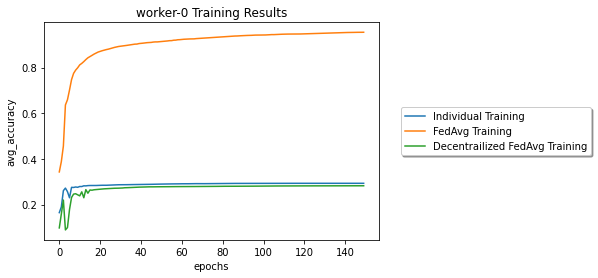

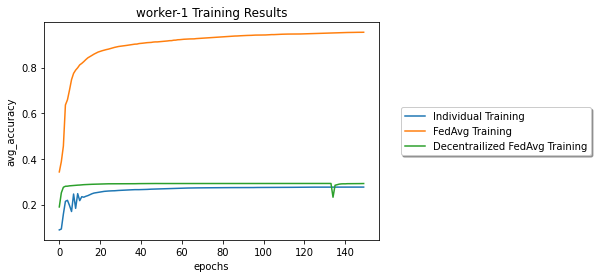

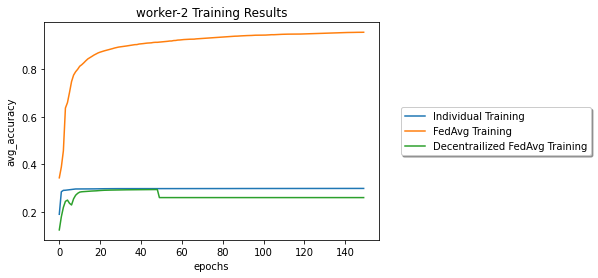

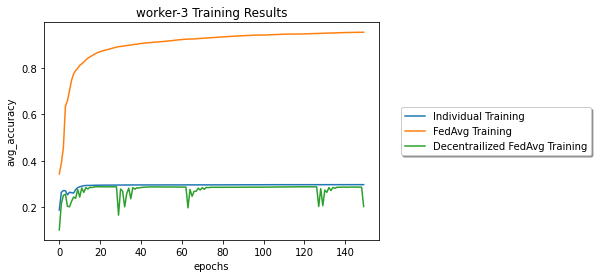

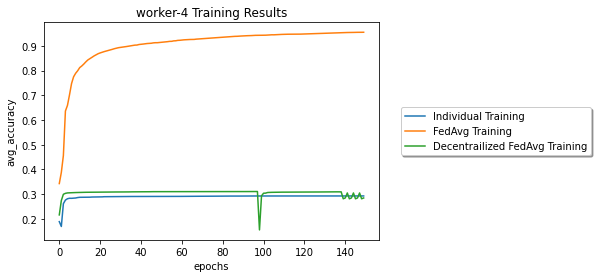

In [21]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes[:5]:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), shadow=True)
    # Display a figure.
    plt.show()